In [1]:
%load_ext watermark
%watermark -v -p numpy,sklearn,scipy,matplotlib,tensorflow

CPython 3.6.6
IPython 6.4.0

numpy 1.14.5
sklearn 0.19.1
scipy 1.1.0
matplotlib 2.2.2
tensorflow 1.9.0


**11장 – 심층 신경망 훈련**

_이 노트북은 11장에 있는 연습문제 해답을 가지고 있습니다._

# 설정

파이썬 2와 3을 모두 지원합니다. 공통 모듈을 임포트하고 맷플롯립 그림이 노트북 안에 포함되도록 설정하고 생성한 그림을 저장하기 위한 함수를 준비합니다:

In [2]:
# 파이썬 2와 파이썬 3 지원
from __future__ import division, print_function, unicode_literals

# 공통
import numpy as np
import os

# 일관된 출력을 위해 유사난수 초기화
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# 맷플롯립 설정
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['axes.unicode_minus'] = False

# 그림을 저장할 폴더
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [3]:
import tensorflow as tf

# 연습문제 해답

## 1. to 7.

부록 A 참조.

## 8. 딥러닝

### 8.1.

_문제: He 초기화와 ELU 활성화 함수를 사용하여 각각 뉴런이 100개인 은닉층 다섯 개를 가진 DNN을 만드세요._

다음 연습문제도 비슷한 모델을 만들어야하므로 여기서 DNN을 구성하는 함수를 만들겠습니다:

In [4]:
he_init = tf.variance_scaling_initializer()

def dnn(inputs, n_hidden_layers=5, n_neurons=100, name=None,
        activation=tf.nn.elu, initializer=he_init):
    with tf.variable_scope(name, "dnn"):
        for layer in range(n_hidden_layers):
            inputs = tf.layers.dense(inputs, n_neurons, activation=activation,
                                     kernel_initializer=initializer,
                                     name="hidden%d" % (layer + 1))
        return inputs

In [5]:
n_inputs = 28 * 28 # MNIST
n_outputs = 5

reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

dnn_outputs = dnn(X)

logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init, name="logits")
Y_proba = tf.nn.softmax(logits, name="Y_proba")

### 8.2.

_문제: Adam 최적화와 조기 종료를 사용하여 MNIST 데이터셋에 훈련시키되 0에서 4까지의 숫자만 사용하세요. 다음 연습문제에서 5에서 9까지의 숫자에 대해 전이 학습을 사용할 것입니다. 출력층은 다섯 개의 뉴런에 소프트맥스 함수를 사용합니다. 나중에 재사용할 수 있도록 항상 일정한 간격으로 체크포인트와 최종 모델을 저장하세요._

비용 함수, 훈련 연산과 다른 필요한 구성 요소를 만듭니다:

In [6]:
learning_rate = 0.01

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss, name="training_op")

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

init = tf.global_variables_initializer()
saver = tf.train.Saver()

MNIST 데이터셋을 로드합니다:

주의: `tf.examples.tutorials.mnist`은 삭제될 예정이므로 대신 `tf.keras.datasets.mnist`를 사용하겠습니다.

In [7]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

훈련 세트, 검증 세트, 테스트 세트를 만듭니다(검증 세트는 조기 종료에 사용합니다):

In [8]:
X_train1 = X_train[y_train < 5]
y_train1 = y_train[y_train < 5]
X_valid1 = X_valid[y_valid < 5]
y_valid1 = y_valid[y_valid < 5]
X_test1 = X_test[y_test < 5]
y_test1 = y_test[y_test < 5]

In [9]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train1))
        for rnd_indices in np.array_split(rnd_idx, len(X_train1) // batch_size):
            X_batch, y_batch = X_train1[rnd_indices], y_train1[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid1, y: y_valid1})
        if loss_val < best_loss:
            save_path = saver.save(sess, "./my_mnist_model_0_to_4.ckpt")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("조기 종료!")
                break
        print("{}\t검증 세트 손실: {:.6f}\t최선의 손실: {:.6f}\t정확도: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    saver.restore(sess, "./my_mnist_model_0_to_4.ckpt")
    acc_test = accuracy.eval(feed_dict={X: X_test1, y: y_test1})
    print("최종 테스트 정확도: {:.2f}%".format(acc_test * 100))

0	검증 세트 손실: 0.315916	최선의 손실: 0.315916	정확도: 91.75%
1	검증 세트 손실: 0.108266	최선의 손실: 0.108266	정확도: 97.69%
2	검증 세트 손실: 0.152090	최선의 손실: 0.108266	정확도: 96.52%
3	검증 세트 손실: 0.450262	최선의 손실: 0.108266	정확도: 79.20%
4	검증 세트 손실: 0.219761	최선의 손실: 0.108266	정확도: 97.11%
5	검증 세트 손실: 0.168875	최선의 손실: 0.108266	정확도: 95.97%
6	검증 세트 손실: 0.368295	최선의 손실: 0.108266	정확도: 91.40%
7	검증 세트 손실: 0.191750	최선의 손실: 0.108266	정확도: 97.89%
8	검증 세트 손실: 0.239490	최선의 손실: 0.108266	정확도: 94.02%
9	검증 세트 손실: 0.210928	최선의 손실: 0.108266	정확도: 95.27%
10	검증 세트 손실: 0.341953	최선의 손실: 0.108266	정확도: 92.65%
11	검증 세트 손실: 0.162905	최선의 손실: 0.108266	정확도: 97.38%
12	검증 세트 손실: 0.324021	최선의 손실: 0.108266	정확도: 96.05%
13	검증 세트 손실: 0.375460	최선의 손실: 0.108266	정확도: 94.10%
14	검증 세트 손실: 0.215060	최선의 손실: 0.108266	정확도: 92.85%
15	검증 세트 손실: 0.179451	최선의 손실: 0.108266	정확도: 97.26%
16	검증 세트 손실: 0.194235	최선의 손실: 0.108266	정확도: 96.56%
17	검증 세트 손실: 0.228341	최선의 손실: 0.108266	정확도: 96.56%
18	검증 세트 손실: 0.230246	최선의 손실: 0.108266	정확도: 97.89%
19	검증 세트 손실: 0.164270	최선의 손실: 0.108266	정확

아주 나쁘지는 않지만 하이퍼파라미터를 튜닝하여 더 개선할 수 있을지 보겠습니다.

### 8.3.

_문제: 교차 검증을 사용하여 하이퍼파라미터를 튜닝하고 얼마의 성능을 달성할 수 있는지 확인해보세요._

하이퍼파라미터 튜닝을 하기 위해 사이킷런의 `RandomizedSearchCV` 클래스와 호환되는 `DNNClassifier` 클래스를 만듭니다. 이 클래스의 핵심은 다음과 같습니다:
* `__init__()` 메서드(생성자)는 각 하이퍼파라미터에 대한 인스턴스 변수를 만듭니다.
* `fit()` 메서드는 그래프를 만들고 세션을 시작해 모델을 훈련시킵니다:
  * `_build_graph()` 메서드를 호출해 그래프를 만듭니다(앞서 만든 그래프와 비슷합니다). 그래프가 만들어지면 다른 메서드에서 접근할 수 있도록 중요한 연산은 모두 인스턴스 변수로 저장합니다.
  * `_dnn()` 메서드는 위의 `dnn()` 함수와 비슷하게 은닉층을 만들고 배치 정규화와 드롭아웃을 추가합니다(다음 연습문제를 위해).
  * `fit()` 메서드에는 검증 세트(`X_valid`와 `y_valid`)가 주어지면 조기 종료를 실행합니다. 여기에서는 디스키 대신 메모리에 최상의 모델을 저장합니다. 이 함수는 그래프의 모든 변수와 값을 가져오기 위해 `_get_model_params()` 함수를 사용하고 (최상의 모델에서) 변수 값을 복원하기 위해 `_restore_model_params()` 함수를 사용합니다. 이런 방식은 훈련 속도를 높여 줍니다.
  * `fit()` 메서드가 모델 훈련을 마치면 예측을 만들기 위해 모델을 저장하고 복원하는 대신에 빠르게 예측을 만들기 위해 그대로 세션을 열어 둡니다. `close_session()` 메서드를 호출해 세션을 닫을 수 있습니다.
  * `predict_proba()` 메서드는 훈련 모델을 사용해 클래스 확률을 예측합니다.
  * `predict()` 메서드는 `predict_proba()`를 호출해 각 샘플에 대해 가장 높은 확률을 가진 클래스를 반환합니다.

In [10]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.exceptions import NotFittedError

class DNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_hidden_layers=5, n_neurons=100, optimizer_class=tf.train.AdamOptimizer,
                 learning_rate=0.01, batch_size=20, activation=tf.nn.elu, initializer=he_init,
                 batch_norm_momentum=None, dropout_rate=None, random_state=None):
        """모든 하이퍼파파미터를 저장하는 것으로 DNNClassifier를 초기화합니다."""
        self.n_hidden_layers = n_hidden_layers
        self.n_neurons = n_neurons
        self.optimizer_class = optimizer_class
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.activation = activation
        self.initializer = initializer
        self.batch_norm_momentum = batch_norm_momentum
        self.dropout_rate = dropout_rate
        self.random_state = random_state
        self._session = None

    def _dnn(self, inputs):
        """배치 정규화와 드롭아웃 기능을 넣어 은닉층을 구성합니다."""
        for layer in range(self.n_hidden_layers):
            if self.dropout_rate:
                inputs = tf.layers.dropout(inputs, self.dropout_rate, training=self._training)
            inputs = tf.layers.dense(inputs, self.n_neurons,
                                     kernel_initializer=self.initializer,
                                     name="hidden%d" % (layer + 1))
            if self.batch_norm_momentum:
                inputs = tf.layers.batch_normalization(inputs, momentum=self.batch_norm_momentum,
                                                       training=self._training)
            inputs = self.activation(inputs, name="hidden%d_out" % (layer + 1))
        return inputs

    def _build_graph(self, n_inputs, n_outputs):
        """이전과 동일한 모델을 만듭니다."""
        if self.random_state is not None:
            tf.set_random_seed(self.random_state)
            np.random.seed(self.random_state)

        X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
        y = tf.placeholder(tf.int32, shape=(None), name="y")

        if self.batch_norm_momentum or self.dropout_rate:
            self._training = tf.placeholder_with_default(False, shape=(), name='training')
        else:
            self._training = None

        dnn_outputs = self._dnn(X)

        logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init, name="logits")
        Y_proba = tf.nn.softmax(logits, name="Y_proba")

        xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                                  logits=logits)
        loss = tf.reduce_mean(xentropy, name="loss")

        optimizer = self.optimizer_class(learning_rate=self.learning_rate)
        training_op = optimizer.minimize(loss)

        correct = tf.nn.in_top_k(logits, y, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

        init = tf.global_variables_initializer()
        saver = tf.train.Saver()

        # 중요한 연산은 인스턴스 변수로 저장하여 참조하기 쉽게 합니다.
        self._X, self._y = X, y
        self._Y_proba, self._loss = Y_proba, loss
        self._training_op, self._accuracy = training_op, accuracy
        self._init, self._saver = init, saver

    def close_session(self):
        if self._session:
            self._session.close()

    def _get_model_params(self):
        """모든 변수 값을 가져옵니다 (조기 종료를 위해 사용하며 디스크에 저장하는 것보다 빠릅니다)"""
        with self._graph.as_default():
            gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
        return {gvar.op.name: value for gvar, value in zip(gvars, self._session.run(gvars))}

    def _restore_model_params(self, model_params):
        """모든 변수를 주어진 값으로 설정합니다 (조기 종료를 위해 사용하며 디스크에 저장하는 것보다 빠릅니다)"""
        gvar_names = list(model_params.keys())
        assign_ops = {gvar_name: self._graph.get_operation_by_name(gvar_name + "/Assign")
                      for gvar_name in gvar_names}
        init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
        feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
        self._session.run(assign_ops, feed_dict=feed_dict)

    def fit(self, X, y, n_epochs=100, X_valid=None, y_valid=None):
        """훈련 세트에 모델을 훈련시킵니다. X_valid와 y_valid가 주어지면 조기 종료를 적용합니다."""
        self.close_session()

        # 훈련 세트로부터 n_inputs와 n_outputs를 구합니다.
        n_inputs = X.shape[1]
        self.classes_ = np.unique(y)
        n_outputs = len(self.classes_)
        
        # 레이블 벡터를 정렬된 클래스 인덱스 벡터로 변환합니다.
        # 0부터 n_outputs - 1까지의 정수를 담고 있게 됩니다.
        # 예를 들어, y가 [8, 8, 9, 5, 7, 6, 6, 6]이면 
        # 정렬된 클래스 레이블(self.classes_)은 [5, 6, 7, 8, 9]가 되고
        # 레이블 벡터는 [3, 3, 4, 0, 2, 1, 1, 1]로 변환됩니다.
        self.class_to_index_ = {label: index
                                for index, label in enumerate(self.classes_)}
        y = np.array([self.class_to_index_[label]
                      for label in y], dtype=np.int32)
        
        self._graph = tf.Graph()
        with self._graph.as_default():
            self._build_graph(n_inputs, n_outputs)
            # 배치 정규화를 위한 추가 연산
            extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

        # 조기 종료를 위해
        max_checks_without_progress = 20
        checks_without_progress = 0
        best_loss = np.infty
        best_params = None
        
        # 이제 모델을 훈련합니다!
        self._session = tf.Session(graph=self._graph)
        with self._session.as_default() as sess:
            self._init.run()
            for epoch in range(n_epochs):
                rnd_idx = np.random.permutation(len(X))
                for rnd_indices in np.array_split(rnd_idx, len(X) // self.batch_size):
                    X_batch, y_batch = X[rnd_indices], y[rnd_indices]
                    feed_dict = {self._X: X_batch, self._y: y_batch}
                    if self._training is not None:
                        feed_dict[self._training] = True
                    sess.run(self._training_op, feed_dict=feed_dict)
                    if extra_update_ops:
                        sess.run(extra_update_ops, feed_dict=feed_dict)
                if X_valid is not None and y_valid is not None:
                    loss_val, acc_val = sess.run([self._loss, self._accuracy],
                                                 feed_dict={self._X: X_valid,
                                                            self._y: y_valid})
                    if loss_val < best_loss:
                        best_params = self._get_model_params()
                        best_loss = loss_val
                        checks_without_progress = 0
                    else:
                        checks_without_progress += 1
                    print("{}\t검증 세트 손실: {:.6f}\t최선의 손실: {:.6f}\t정확도: {:.2f}%".format(
                        epoch, loss_val, best_loss, acc_val * 100))
                    if checks_without_progress > max_checks_without_progress:
                        print("조기 종료!")
                        break
                else:
                    loss_train, acc_train = sess.run([self._loss, self._accuracy],
                                                     feed_dict={self._X: X_batch,
                                                                self._y: y_batch})
                    print("{}\t마지막 훈련 배치 손실: {:.6f}\tAccuracy: {:.2f}%".format(
                        epoch, loss_train, acc_train * 100))
            # 조기 종료를 사용하면 이전의 최상의 모델로 되돌립니다.
            if best_params:
                self._restore_model_params(best_params)
            return self

    def predict_proba(self, X):
        if not self._session:
            raise NotFittedError("%s 객체가 아직 훈련되지 않았습니다" % self.__class__.__name__)
        with self._session.as_default() as sess:
            return self._Y_proba.eval(feed_dict={self._X: X})

    def predict(self, X):
        class_indices = np.argmax(self.predict_proba(X), axis=1)
        return np.array([[self.classes_[class_index]]
                         for class_index in class_indices], np.int32)

    def save(self, path):
        self._saver.save(self._session, path)

이 클래스를 사용하여 이전과 비슷한 정확도가 나오는지 확인해 보죠(드롭아웃과 배치 정규화는 사용하지 않습니다):

In [11]:
dnn_clf = DNNClassifier(random_state=42)
dnn_clf.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	검증 세트 손실: 0.129222	최선의 손실: 0.129222	정확도: 97.22%
1	검증 세트 손실: 0.559770	최선의 손실: 0.129222	정확도: 74.35%
2	검증 세트 손실: 0.147327	최선의 손실: 0.129222	정확도: 97.58%
3	검증 세트 손실: 0.144827	최선의 손실: 0.129222	정확도: 97.89%
4	검증 세트 손실: 0.127843	최선의 손실: 0.127843	정확도: 97.42%
5	검증 세트 손실: 0.143233	최선의 손실: 0.127843	정확도: 97.97%
6	검증 세트 손실: 0.121280	최선의 손실: 0.121280	정확도: 97.97%
7	검증 세트 손실: 0.109261	최선의 손실: 0.109261	정확도: 98.28%
8	검증 세트 손실: 0.198748	최선의 손실: 0.109261	정확도: 96.29%
9	검증 세트 손실: 0.155379	최선의 손실: 0.109261	정확도: 97.42%
10	검증 세트 손실: 0.206531	최선의 손실: 0.109261	정확도: 96.76%
11	검증 세트 손실: 0.883356	최선의 손실: 0.109261	정확도: 60.24%
12	검증 세트 손실: 4.297064	최선의 손실: 0.109261	정확도: 65.91%
13	검증 세트 손실: 1.220423	최선의 손실: 0.109261	정확도: 42.65%
14	검증 세트 손실: 1.225584	최선의 손실: 0.109261	정확도: 39.44%
15	검증 세트 손실: 1.658190	최선의 손실: 0.109261	정확도: 19.27%
16	검증 세트 손실: 1.660811	최선의 손실: 0.109261	정확도: 19.08%
17	검증 세트 손실: 1.641901	최선의 손실: 0.109261	정확도: 19.27%
18	검증 세트 손실: 1.685859	최선의 손실: 0.109261	정확도: 19.27%
19	검증 세트 손실: 1.641611	최선의 손실: 0.109261	정확

DNNClassifier(activation=<function elu at 0x7fed849ba9d8>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7fed77f0e9b0>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

모델 훈련이 완료되면 이전과 비슷한 정확도가 나오는지 확인해 보겠습니다:

In [12]:
from sklearn.metrics import accuracy_score

y_pred = dnn_clf.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9828760459233314

좋네요! 잘 작동합니다. 이제 사이킷런의 `RandomizedSearchCV` 클래스를 사용해서 더 나은 하이퍼파라미터를 찾아보겠습니다(시스템에 따라 이 작업은 한 시간 이상 걸릴지 모릅니다):

In [13]:
from sklearn.model_selection import RandomizedSearchCV

def leaky_relu(alpha=0.01):
    def parametrized_leaky_relu(z, name=None):
        return tf.maximum(alpha * z, z, name=name)
    return parametrized_leaky_relu

param_distribs = {
    "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    # 은닉층의 수나 옵티마이저 등을 달리하여 탐색해 볼 수 있습니다.
    #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
}

# 생성자에 넘겨주는 fit_params 매개변수는 사이킷런 0.19 버전부터 경고가 발생하고 0.21 버전에서 사라지므로
# 대신 fit() 메서드에 매개변수로 전달해야 합니다.:
rnd_search = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
                                random_state=42, verbose=2)
fit_params={"X_valid": X_valid1, "y_valid": y_valid1, "n_epochs": 1000}
rnd_search.fit(X_train1, y_train1, **fit_params)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] n_neurons=10, learning_rate=0.05, batch_size=100, activation=<function elu at 0x7fed849ba9d8> 
0	검증 세트 손실: 0.157931	최선의 손실: 0.157931	정확도: 95.58%
1	검증 세트 손실: 0.158850	최선의 손실: 0.157931	정확도: 95.86%
2	검증 세트 손실: 0.124296	최선의 손실: 0.124296	정확도: 96.99%
3	검증 세트 손실: 0.134936	최선의 손실: 0.124296	정확도: 96.21%
4	검증 세트 손실: 0.145822	최선의 손실: 0.124296	정확도: 96.48%
5	검증 세트 손실: 0.276372	최선의 손실: 0.124296	정확도: 95.78%
6	검증 세트 손실: 0.980492	최선의 손실: 0.124296	정확도: 54.46%
7	검증 세트 손실: 0.815101	최선의 손실: 0.124296	정확도: 60.36%
8	검증 세트 손실: 0.793298	최선의 손실: 0.124296	정확도: 59.73%
9	검증 세트 손실: 0.768689	최선의 손실: 0.124296	정확도: 60.52%
10	검증 세트 손실: 0.769484	최선의 손실: 0.124296	정확도: 60.71%
11	검증 세트 손실: 0.760545	최선의 손실: 0.124296	정확도: 56.29%
12	검증 세트 손실: 0.763271	최선의 손실: 0.124296	정확도: 60.99%
13	검증 세트 손실: 0.785367	최선의 손실: 0.124296	정확도: 56.65%
14	검증 세트 손실: 0.726823	최선의 손실: 0.124296	정확도: 61.26%
15	검증 세트 손실: 0.733430	최선의 손실: 0.124296	정확도: 60.87%
16	검증 세트 손실: 0.748234	최선의 손실: 0.

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.6s remaining:    0.0s


0	검증 세트 손실: 0.140925	최선의 손실: 0.140925	정확도: 96.25%
1	검증 세트 손실: 0.157028	최선의 손실: 0.140925	정확도: 95.90%
2	검증 세트 손실: 0.113692	최선의 손실: 0.113692	정확도: 97.26%
3	검증 세트 손실: 0.117066	최선의 손실: 0.113692	정확도: 97.30%
4	검증 세트 손실: 0.119602	최선의 손실: 0.113692	정확도: 96.87%
5	검증 세트 손실: 1.052951	최선의 손실: 0.113692	정확도: 70.76%
6	검증 세트 손실: 0.853281	최선의 손실: 0.113692	정확도: 63.37%
7	검증 세트 손실: 0.605615	최선의 손실: 0.113692	정확도: 75.25%
8	검증 세트 손실: 0.722925	최선의 손실: 0.113692	정확도: 87.88%
9	검증 세트 손실: 0.659561	최선의 손실: 0.113692	정확도: 81.39%
10	검증 세트 손실: 0.465405	최선의 손실: 0.113692	정확도: 90.19%
11	검증 세트 손실: 0.382198	최선의 손실: 0.113692	정확도: 90.11%
12	검증 세트 손실: 0.424138	최선의 손실: 0.113692	정확도: 92.57%
13	검증 세트 손실: 0.479373	최선의 손실: 0.113692	정확도: 90.11%
14	검증 세트 손실: 0.311892	최선의 손실: 0.113692	정확도: 93.08%
15	검증 세트 손실: 0.371091	최선의 손실: 0.113692	정확도: 92.06%
16	검증 세트 손실: 0.410592	최선의 손실: 0.113692	정확도: 89.21%
17	검증 세트 손실: 0.331743	최선의 손실: 0.113692	정확도: 92.53%
18	검증 세트 손실: 0.479851	최선의 손실: 0.113692	정확도: 87.69%
19	검증 세트 손실: 0.500105	최선의 손실: 0.113692	정확

0	검증 세트 손실: 5.824070	최선의 손실: 5.824070	정확도: 55.04%
1	검증 세트 손실: 0.764341	최선의 손실: 0.764341	정확도: 67.87%
2	검증 세트 손실: 0.640605	최선의 손실: 0.640605	정확도: 75.80%
3	검증 세트 손실: 17.859846	최선의 손실: 0.640605	정확도: 41.40%
4	검증 세트 손실: 9012.163086	최선의 손실: 0.640605	정확도: 18.92%
5	검증 세트 손실: 66.371674	최선의 손실: 0.640605	정확도: 51.99%
6	검증 세트 손실: 55195.433594	최선의 손실: 0.640605	정확도: 19.27%
7	검증 세트 손실: 749.014832	최선의 손실: 0.640605	정확도: 28.58%
8	검증 세트 손실: 172.558350	최선의 손실: 0.640605	정확도: 60.63%
9	검증 세트 손실: 114.708305	최선의 손실: 0.640605	정확도: 57.31%
10	검증 세트 손실: 54.363884	최선의 손실: 0.640605	정확도: 71.19%
11	검증 세트 손실: 93.329643	최선의 손실: 0.640605	정확도: 54.14%
12	검증 세트 손실: 34.989777	최선의 손실: 0.640605	정확도: 81.51%
13	검증 세트 손실: 23.488392	최선의 손실: 0.640605	정확도: 83.07%
14	검증 세트 손실: 41.258888	최선의 손실: 0.640605	정확도: 68.53%
15	검증 세트 손실: 31.697817	최선의 손실: 0.640605	정확도: 82.49%
16	검증 세트 손실: 25.482103	최선의 손실: 0.640605	정확도: 85.30%
17	검증 세트 손실: 19.650114	최선의 손실: 0.640605	정확도: 89.91%
18	검증 세트 손실: 23.798889	최선의 손실: 0.640605	정확도: 85.42%
19	검증 세트 손실: 19.3

0	검증 세트 손실: 233.192017	최선의 손실: 233.192017	정확도: 92.96%
1	검증 세트 손실: 55.475880	최선의 손실: 55.475880	정확도: 93.94%
2	검증 세트 손실: 42.276989	최선의 손실: 42.276989	정확도: 95.43%
3	검증 세트 손실: 22.107286	최선의 손실: 22.107286	정확도: 95.54%
4	검증 세트 손실: 54.573017	최선의 손실: 22.107286	정확도: 93.43%
5	검증 세트 손실: 5959717.500000	최선의 손실: 22.107286	정확도: 40.07%
6	검증 세트 손실: 53203.691406	최선의 손실: 22.107286	정확도: 84.83%
7	검증 세트 손실: 32021.093750	최선의 손실: 22.107286	정확도: 90.81%
8	검증 세트 손실: 22744.373047	최선의 손실: 22.107286	정확도: 91.95%
9	검증 세트 손실: 21740.089844	최선의 손실: 22.107286	정확도: 94.25%
10	검증 세트 손실: 11899.331055	최선의 손실: 22.107286	정확도: 94.37%
11	검증 세트 손실: 18817.242188	최선의 손실: 22.107286	정확도: 93.35%
12	검증 세트 손실: 14014.827148	최선의 손실: 22.107286	정확도: 92.30%
13	검증 세트 손실: 14605.044922	최선의 손실: 22.107286	정확도: 94.10%
14	검증 세트 손실: 41815.691406	최선의 손실: 22.107286	정확도: 93.04%
15	검증 세트 손실: 16176.915039	최선의 손실: 22.107286	정확도: 93.94%
16	검증 세트 손실: 9348.519531	최선의 손실: 22.107286	정확도: 96.72%
17	검증 세트 손실: 12802.357422	최선의 손실: 22.107286	정확도: 92.34%
18	검증 세트 손실: 1

11	검증 세트 손실: 0.063435	최선의 손실: 0.050423	정확도: 98.91%
12	검증 세트 손실: 0.070392	최선의 손실: 0.050423	정확도: 98.59%
13	검증 세트 손실: 0.066557	최선의 손실: 0.050423	정확도: 98.71%
14	검증 세트 손실: 0.063255	최선의 손실: 0.050423	정확도: 98.75%
15	검증 세트 손실: 0.069891	최선의 손실: 0.050423	정확도: 98.48%
16	검증 세트 손실: 0.086285	최선의 손실: 0.050423	정확도: 98.63%
17	검증 세트 손실: 0.057015	최선의 손실: 0.050423	정확도: 98.79%
18	검증 세트 손실: 0.057664	최선의 손실: 0.050423	정확도: 98.94%
19	검증 세트 손실: 0.046806	최선의 손실: 0.046806	정확도: 98.91%
20	검증 세트 손실: 0.066428	최선의 손실: 0.046806	정확도: 98.91%
21	검증 세트 손실: 0.059911	최선의 손실: 0.046806	정확도: 99.10%
22	검증 세트 손실: 0.067280	최선의 손실: 0.046806	정확도: 98.79%
23	검증 세트 손실: 0.072089	최선의 손실: 0.046806	정확도: 98.67%
24	검증 세트 손실: 0.079342	최선의 손실: 0.046806	정확도: 99.10%
25	검증 세트 손실: 0.075213	최선의 손실: 0.046806	정확도: 98.63%
26	검증 세트 손실: 0.086593	최선의 손실: 0.046806	정확도: 98.51%
27	검증 세트 손실: 0.056003	최선의 손실: 0.046806	정확도: 99.14%
28	검증 세트 손실: 0.082079	최선의 손실: 0.046806	정확도: 98.94%
29	검증 세트 손실: 0.100522	최선의 손실: 0.046806	정확도: 98.87%
30	검증 세트 손실: 0.069183	최선의 손실: 0

24	검증 세트 손실: 0.062766	최선의 손실: 0.042922	정확도: 98.98%
25	검증 세트 손실: 0.075209	최선의 손실: 0.042922	정확도: 98.83%
26	검증 세트 손실: 0.057347	최선의 손실: 0.042922	정확도: 98.87%
27	검증 세트 손실: 0.057633	최선의 손실: 0.042922	정확도: 99.06%
28	검증 세트 손실: 0.049993	최선의 손실: 0.042922	정확도: 98.98%
29	검증 세트 손실: 0.056238	최선의 손실: 0.042922	정확도: 98.94%
30	검증 세트 손실: 0.063938	최선의 손실: 0.042922	정확도: 98.83%
31	검증 세트 손실: 0.067074	최선의 손실: 0.042922	정확도: 98.94%
32	검증 세트 손실: 0.065557	최선의 손실: 0.042922	정확도: 98.87%
33	검증 세트 손실: 0.058577	최선의 손실: 0.042922	정확도: 98.98%
34	검증 세트 손실: 0.108174	최선의 손실: 0.042922	정확도: 98.59%
35	검증 세트 손실: 0.074208	최선의 손실: 0.042922	정확도: 98.75%
36	검증 세트 손실: 0.084349	최선의 손실: 0.042922	정확도: 98.83%
37	검증 세트 손실: 0.095986	최선의 손실: 0.042922	정확도: 98.67%
38	검증 세트 손실: 0.089219	최선의 손실: 0.042922	정확도: 98.71%
39	검증 세트 손실: 0.089324	최선의 손실: 0.042922	정확도: 98.83%
40	검증 세트 손실: 0.079374	최선의 손실: 0.042922	정확도: 98.51%
41	검증 세트 손실: 0.082104	최선의 손실: 0.042922	정확도: 98.91%
조기 종료!
[CV]  n_neurons=140, learning_rate=0.01, batch_size=500, activation=<functi

41	검증 세트 손실: 1.634035	최선의 손실: 1.607884	정확도: 22.01%
42	검증 세트 손실: 1.618333	최선의 손실: 1.607884	정확도: 20.91%
43	검증 세트 손실: 1.618746	최선의 손실: 1.607884	정확도: 22.01%
44	검증 세트 손실: 1.621663	최선의 손실: 1.607884	정확도: 19.08%
45	검증 세트 손실: 1.629384	최선의 손실: 1.607884	정확도: 22.01%
46	검증 세트 손실: 1.637659	최선의 손실: 1.607884	정확도: 18.73%
47	검증 세트 손실: 1.609606	최선의 손실: 1.607884	정확도: 22.01%
48	검증 세트 손실: 1.612161	최선의 손실: 1.607884	정확도: 22.01%
49	검증 세트 손실: 1.643129	최선의 손실: 1.607884	정확도: 19.27%
50	검증 세트 손실: 1.611989	최선의 손실: 1.607884	정확도: 22.01%
51	검증 세트 손실: 1.619973	최선의 손실: 1.607884	정확도: 19.08%
52	검증 세트 손실: 1.627020	최선의 손실: 1.607884	정확도: 19.08%
53	검증 세트 손실: 1.618522	최선의 손실: 1.607884	정확도: 22.01%
54	검증 세트 손실: 1.654810	최선의 손실: 1.607884	정확도: 18.73%
55	검증 세트 손실: 1.645115	최선의 손실: 1.607884	정확도: 18.73%
56	검증 세트 손실: 1.669472	최선의 손실: 1.607884	정확도: 19.08%
57	검증 세트 손실: 1.619669	최선의 손실: 1.607884	정확도: 18.73%
58	검증 세트 손실: 1.612547	최선의 손실: 1.607884	정확도: 22.01%
59	검증 세트 손실: 1.619514	최선의 손실: 1.607884	정확도: 22.01%
60	검증 세트 손실: 1.635965	최선의 손실: 1

10	검증 세트 손실: 0.070343	최선의 손실: 0.067958	정확도: 98.63%
11	검증 세트 손실: 0.104319	최선의 손실: 0.067958	정확도: 97.97%
12	검증 세트 손실: 0.082734	최선의 손실: 0.067958	정확도: 98.01%
13	검증 세트 손실: 0.075652	최선의 손실: 0.067958	정확도: 98.32%
14	검증 세트 손실: 0.105316	최선의 손실: 0.067958	정확도: 97.30%
15	검증 세트 손실: 0.084550	최선의 손실: 0.067958	정확도: 98.28%
16	검증 세트 손실: 0.082837	최선의 손실: 0.067958	정확도: 98.16%
17	검증 세트 손실: 0.097076	최선의 손실: 0.067958	정확도: 98.28%
18	검증 세트 손실: 0.122457	최선의 손실: 0.067958	정확도: 96.99%
19	검증 세트 손실: 0.107781	최선의 손실: 0.067958	정확도: 98.12%
20	검증 세트 손실: 0.142530	최선의 손실: 0.067958	정확도: 97.46%
21	검증 세트 손실: 0.078234	최선의 손실: 0.067958	정확도: 98.44%
22	검증 세트 손실: 0.091882	최선의 손실: 0.067958	정확도: 98.40%
23	검증 세트 손실: 0.116645	최선의 손실: 0.067958	정확도: 97.93%
24	검증 세트 손실: 0.079262	최선의 손실: 0.067958	정확도: 98.59%
25	검증 세트 손실: 0.210773	최선의 손실: 0.067958	정확도: 97.07%
26	검증 세트 손실: 0.174902	최선의 손실: 0.067958	정확도: 97.26%
27	검증 세트 손실: 0.119635	최선의 손실: 0.067958	정확도: 97.46%
28	검증 세트 손실: 0.095731	최선의 손실: 0.067958	정확도: 97.93%
29	검증 세트 손실: 0.091290	최선의 손실: 0

5	검증 세트 손실: 0.109245	최선의 손실: 0.070705	정확도: 97.81%
6	검증 세트 손실: 0.145248	최선의 손실: 0.070705	정확도: 97.97%
7	검증 세트 손실: 0.124358	최선의 손실: 0.070705	정확도: 96.83%
8	검증 세트 손실: 0.081146	최선의 손실: 0.070705	정확도: 98.08%
9	검증 세트 손실: 0.076451	최선의 손실: 0.070705	정확도: 98.05%
10	검증 세트 손실: 0.084351	최선의 손실: 0.070705	정확도: 98.28%
11	검증 세트 손실: 0.083036	최선의 손실: 0.070705	정확도: 98.55%
12	검증 세트 손실: 0.098250	최선의 손실: 0.070705	정확도: 98.08%
13	검증 세트 손실: 0.123132	최선의 손실: 0.070705	정확도: 97.34%
14	검증 세트 손실: 0.145748	최선의 손실: 0.070705	정확도: 98.63%
15	검증 세트 손실: 6.251429	최선의 손실: 0.070705	정확도: 95.70%
16	검증 세트 손실: 0.461073	최선의 손실: 0.070705	정확도: 97.50%
17	검증 세트 손실: 0.258748	최선의 손실: 0.070705	정확도: 98.20%
18	검증 세트 손실: 0.272504	최선의 손실: 0.070705	정확도: 97.38%
19	검증 세트 손실: 0.231348	최선의 손실: 0.070705	정확도: 97.93%
20	검증 세트 손실: 0.220968	최선의 손실: 0.070705	정확도: 98.12%
21	검증 세트 손실: 0.252581	최선의 손실: 0.070705	정확도: 98.28%
22	검증 세트 손실: 0.187132	최선의 손실: 0.070705	정확도: 98.16%
23	검증 세트 손실: 0.150517	최선의 손실: 0.070705	정확도: 98.36%
24	검증 세트 손실: 0.165383	최선의 손실: 0.0707

16	검증 세트 손실: 0.136163	최선의 손실: 0.131653	정확도: 96.83%
17	검증 세트 손실: 0.126361	최선의 손실: 0.126361	정확도: 97.19%
18	검증 세트 손실: 0.124708	최선의 손실: 0.124708	정확도: 96.99%
19	검증 세트 손실: 0.125312	최선의 손실: 0.124708	정확도: 96.95%
20	검증 세트 손실: 0.128900	최선의 손실: 0.124708	정확도: 97.15%
21	검증 세트 손실: 0.119106	최선의 손실: 0.119106	정확도: 97.19%
22	검증 세트 손실: 0.129391	최선의 손실: 0.119106	정확도: 97.22%
23	검증 세트 손실: 0.122224	최선의 손실: 0.119106	정확도: 97.30%
24	검증 세트 손실: 0.130360	최선의 손실: 0.119106	정확도: 97.07%
25	검증 세트 손실: 0.127968	최선의 손실: 0.119106	정확도: 97.34%
26	검증 세트 손실: 0.102513	최선의 손실: 0.102513	정확도: 97.85%
27	검증 세트 손실: 0.129643	최선의 손실: 0.102513	정확도: 97.30%
28	검증 세트 손실: 0.125512	최선의 손실: 0.102513	정확도: 97.54%
29	검증 세트 손실: 0.113508	최선의 손실: 0.102513	정확도: 97.34%
30	검증 세트 손실: 0.147300	최선의 손실: 0.102513	정확도: 97.30%
31	검증 세트 손실: 0.115136	최선의 손실: 0.102513	정확도: 97.69%
32	검증 세트 손실: 0.123855	최선의 손실: 0.102513	정확도: 97.42%
33	검증 세트 손실: 0.130982	최선의 손실: 0.102513	정확도: 97.19%
34	검증 세트 손실: 0.144874	최선의 손실: 0.102513	정확도: 97.22%
35	검증 세트 손실: 0.134446	최선의 손실: 0

0	검증 세트 손실: 1.264718	최선의 손실: 1.264718	정확도: 52.89%
1	검증 세트 손실: 4565.926270	최선의 손실: 1.264718	정확도: 20.21%
2	검증 세트 손실: 11762.987305	최선의 손실: 1.264718	정확도: 58.37%
3	검증 세트 손실: 8281.513672	최선의 손실: 1.264718	정확도: 58.48%
4	검증 세트 손실: 3847.000000	최선의 손실: 1.264718	정확도: 82.21%
5	검증 세트 손실: 76403.468750	최선의 손실: 1.264718	정확도: 42.18%
6	검증 세트 손실: 4673.712891	최선의 손실: 1.264718	정확도: 83.50%
7	검증 세트 손실: 5474.395020	최선의 손실: 1.264718	정확도: 87.45%
8	검증 세트 손실: 3938.646484	최선의 손실: 1.264718	정확도: 84.40%
9	검증 세트 손실: 2165.793701	최선의 손실: 1.264718	정확도: 88.74%
10	검증 세트 손실: 2500.000488	최선의 손실: 1.264718	정확도: 84.44%
11	검증 세트 손실: 2294.362305	최선의 손실: 1.264718	정확도: 87.92%
12	검증 세트 손실: 3131.311279	최선의 손실: 1.264718	정확도: 86.63%
13	검증 세트 손실: 1950.583862	최선의 손실: 1.264718	정확도: 88.39%
14	검증 세트 손실: 1738.419434	최선의 손실: 1.264718	정확도: 90.97%
15	검증 세트 손실: 1250.758057	최선의 손실: 1.264718	정확도: 93.55%
16	검증 세트 손실: 1075.321777	최선의 손실: 1.264718	정확도: 92.26%
17	검증 세트 손실: 309895.093750	최선의 손실: 1.264718	정확도: 34.87%
18	검증 세트 손실: 30916.941406	최선의 손실: 1.2

0	검증 세트 손실: 1.980269	최선의 손실: 1.980269	정확도: 18.73%
1	검증 세트 손실: 2.317917	최선의 손실: 1.980269	정확도: 18.73%
2	검증 세트 손실: 2.284724	최선의 손실: 1.980269	정확도: 20.91%
3	검증 세트 손실: 2.233554	최선의 손실: 1.980269	정확도: 19.27%
4	검증 세트 손실: 2.035042	최선의 손실: 1.980269	정확도: 19.27%
5	검증 세트 손실: 1.689852	최선의 손실: 1.689852	정확도: 20.91%
6	검증 세트 손실: 2.098186	최선의 손실: 1.689852	정확도: 18.73%
7	검증 세트 손실: 1.991255	최선의 손실: 1.689852	정확도: 19.08%
8	검증 세트 손실: 1.886127	최선의 손실: 1.689852	정확도: 19.08%
9	검증 세트 손실: 2.482887	최선의 손실: 1.689852	정확도: 19.27%
10	검증 세트 손실: 1.726857	최선의 손실: 1.689852	정확도: 20.91%
11	검증 세트 손실: 1.677547	최선의 손실: 1.677547	정확도: 22.01%
12	검증 세트 손실: 1.999842	최선의 손실: 1.677547	정확도: 19.08%
13	검증 세트 손실: 1.756566	최선의 손실: 1.677547	정확도: 19.08%
14	검증 세트 손실: 2.995750	최선의 손실: 1.677547	정확도: 20.91%
15	검증 세트 손실: 1.696038	최선의 손실: 1.677547	정확도: 19.27%
16	검증 세트 손실: 2.644184	최선의 손실: 1.677547	정확도: 20.91%
17	검증 세트 손실: 2.019501	최선의 손실: 1.677547	정확도: 20.91%
18	검증 세트 손실: 2.568139	최선의 손실: 1.677547	정확도: 22.01%
19	검증 세트 손실: 2.833772	최선의 손실: 1.677547	정확

12	검증 세트 손실: 0.041913	최선의 손실: 0.041913	정확도: 98.87%
13	검증 세트 손실: 0.057361	최선의 손실: 0.041913	정확도: 98.91%
14	검증 세트 손실: 0.076994	최선의 손실: 0.041913	정확도: 98.51%
15	검증 세트 손실: 0.069242	최선의 손실: 0.041913	정확도: 98.63%
16	검증 세트 손실: 0.065694	최선의 손실: 0.041913	정확도: 98.48%
17	검증 세트 손실: 0.060566	최선의 손실: 0.041913	정확도: 98.79%
18	검증 세트 손실: 0.063978	최선의 손실: 0.041913	정확도: 98.83%
19	검증 세트 손실: 0.072846	최선의 손실: 0.041913	정확도: 98.63%
20	검증 세트 손실: 0.069316	최선의 손실: 0.041913	정확도: 98.83%
21	검증 세트 손실: 0.102993	최선의 손실: 0.041913	정확도: 98.51%
22	검증 세트 손실: 0.080910	최선의 손실: 0.041913	정확도: 98.91%
23	검증 세트 손실: 0.076654	최선의 손실: 0.041913	정확도: 98.71%
24	검증 세트 손실: 0.061774	최선의 손실: 0.041913	정확도: 98.75%
25	검증 세트 손실: 0.072621	최선의 손실: 0.041913	정확도: 98.59%
26	검증 세트 손실: 0.077844	최선의 손실: 0.041913	정확도: 98.44%
27	검증 세트 손실: 0.088977	최선의 손실: 0.041913	정확도: 98.75%
28	검증 세트 손실: 0.098323	최선의 손실: 0.041913	정확도: 98.79%
29	검증 세트 손실: 0.093108	최선의 손실: 0.041913	정확도: 98.71%
30	검증 세트 손실: 0.073026	최선의 손실: 0.041913	정확도: 98.71%
31	검증 세트 손실: 0.072348	최선의 손실: 0

16	검증 세트 손실: 1.061926	최선의 손실: 0.307585	정확도: 37.53%
17	검증 세트 손실: 1.047832	최선의 손실: 0.307585	정확도: 36.86%
18	검증 세트 손실: 1.035868	최선의 손실: 0.307585	정확도: 40.03%
19	검증 세트 손실: 1.071209	최선의 손실: 0.307585	정확도: 40.50%
20	검증 세트 손실: 1.183275	최선의 손실: 0.307585	정확도: 38.19%
21	검증 세트 손실: 1.215256	최선의 손실: 0.307585	정확도: 39.33%
조기 종료!
[CV]  n_neurons=30, learning_rate=0.05, batch_size=50, activation=<function relu at 0x7fed849ebd08>, total=   7.6s
[CV] n_neurons=50, learning_rate=0.05, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fed58099a60> 
0	검증 세트 손실: 0.144269	최선의 손실: 0.144269	정확도: 96.13%
1	검증 세트 손실: 0.102860	최선의 손실: 0.102860	정확도: 97.03%
2	검증 세트 손실: 0.105750	최선의 손실: 0.102860	정확도: 97.38%
3	검증 세트 손실: 25.374231	최선의 손실: 0.102860	정확도: 81.94%
4	검증 세트 손실: 14.755222	최선의 손실: 0.102860	정확도: 86.24%
5	검증 세트 손실: 9.762177	최선의 손실: 0.102860	정확도: 89.80%
6	검증 세트 손실: 7.722386	최선의 손실: 0.102860	정확도: 89.13%
7	검증 세트 손실: 6.177895	최선의 손실: 0.102860	정확도: 92.46%
8	검증 세트 손실: 4.340258	최선의 손실: 0

23	검증 세트 손실: 1.167332	최선의 손실: 0.111103	정확도: 40.34%
24	검증 세트 손실: 1.210595	최선의 손실: 0.111103	정확도: 39.91%
25	검증 세트 손실: 1.152971	최선의 손실: 0.111103	정확도: 40.42%
26	검증 세트 손실: 1.313153	최선의 손실: 0.111103	정확도: 36.98%
조기 종료!
[CV]  n_neurons=10, learning_rate=0.02, batch_size=10, activation=<function elu at 0x7fed849ba9d8>, total=  41.9s
[CV] n_neurons=10, learning_rate=0.02, batch_size=10, activation=<function elu at 0x7fed849ba9d8> 
0	검증 세트 손실: 0.137239	최선의 손실: 0.137239	정확도: 96.60%
1	검증 세트 손실: 0.188541	최선의 손실: 0.137239	정확도: 95.43%
2	검증 세트 손실: 0.196889	최선의 손실: 0.137239	정확도: 96.05%
3	검증 세트 손실: 0.147066	최선의 손실: 0.137239	정확도: 96.64%
4	검증 세트 손실: 0.118545	최선의 손실: 0.118545	정확도: 96.76%
5	검증 세트 손실: 0.168418	최선의 손실: 0.118545	정확도: 95.47%
6	검증 세트 손실: 0.144134	최선의 손실: 0.118545	정확도: 96.79%
7	검증 세트 손실: 0.213506	최선의 손실: 0.118545	정확도: 95.97%
8	검증 세트 손실: 1.507360	최선의 손실: 0.118545	정확도: 95.97%
9	검증 세트 손실: 0.169932	최선의 손실: 0.118545	정확도: 95.86%
10	검증 세트 손실: 0.150381	최선의 손실: 0.118545	정확도: 96.52%
11	검증 세트 손실: 0.309805	최선의

10	검증 세트 손실: 0.078377	최선의 손실: 0.076277	정확도: 97.81%
11	검증 세트 손실: 0.074651	최선의 손실: 0.074651	정확도: 98.01%
12	검증 세트 손실: 0.089704	최선의 손실: 0.074651	정확도: 97.62%
13	검증 세트 손실: 0.071087	최선의 손실: 0.071087	정확도: 98.16%
14	검증 세트 손실: 0.071123	최선의 손실: 0.071087	정확도: 98.32%
15	검증 세트 손실: 0.071368	최선의 손실: 0.071087	정확도: 98.08%
16	검증 세트 손실: 0.091405	최선의 손실: 0.071087	정확도: 97.81%
17	검증 세트 손실: 0.088870	최선의 손실: 0.071087	정확도: 97.85%
18	검증 세트 손실: 0.084488	최선의 손실: 0.071087	정확도: 98.05%
19	검증 세트 손실: 0.080751	최선의 손실: 0.071087	정확도: 98.01%
20	검증 세트 손실: 0.079582	최선의 손실: 0.071087	정확도: 98.08%
21	검증 세트 손실: 0.063847	최선의 손실: 0.063847	정확도: 98.20%
22	검증 세트 손실: 0.061594	최선의 손실: 0.061594	정확도: 98.44%
23	검증 세트 손실: 0.075458	최선의 손실: 0.061594	정확도: 98.28%
24	검증 세트 손실: 0.101504	최선의 손실: 0.061594	정확도: 98.08%
25	검증 세트 손실: 0.077743	최선의 손실: 0.061594	정확도: 98.05%
26	검증 세트 손실: 0.121103	최선의 손실: 0.061594	정확도: 98.20%
27	검증 세트 손실: 0.117741	최선의 손실: 0.061594	정확도: 97.54%
28	검증 세트 손실: 0.084590	최선의 손실: 0.061594	정확도: 98.08%
29	검증 세트 손실: 0.119543	최선의 손실: 0

28	검증 세트 손실: 0.092038	최선의 손실: 0.075205	정확도: 97.81%
29	검증 세트 손실: 0.102564	최선의 손실: 0.075205	정확도: 97.97%
30	검증 세트 손실: 0.107029	최선의 손실: 0.075205	정확도: 98.08%
31	검증 세트 손실: 0.108465	최선의 손실: 0.075205	정확도: 97.58%
32	검증 세트 손실: 0.117054	최선의 손실: 0.075205	정확도: 97.69%
조기 종료!
[CV]  n_neurons=10, learning_rate=0.02, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fed58117378>, total=   2.6s
[CV] n_neurons=10, learning_rate=0.02, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fed58117378> 
0	검증 세트 손실: 0.180241	최선의 손실: 0.180241	정확도: 94.76%
1	검증 세트 손실: 0.119239	최선의 손실: 0.119239	정확도: 96.72%
2	검증 세트 손실: 0.104731	최선의 손실: 0.104731	정확도: 96.99%
3	검증 세트 손실: 0.103245	최선의 손실: 0.103245	정확도: 97.03%
4	검증 세트 손실: 0.099223	최선의 손실: 0.099223	정확도: 97.26%
5	검증 세트 손실: 0.091124	최선의 손실: 0.091124	정확도: 97.42%
6	검증 세트 손실: 0.102784	최선의 손실: 0.091124	정확도: 97.22%
7	검증 세트 손실: 0.095712	최선의 손실: 0.091124	정확도: 97.26%
8	검증 세트 손실: 0.087833	최선의 손실: 0.087833	정확도: 

14	검증 세트 손실: 1.665313	최선의 손실: 0.073403	정확도: 19.08%
15	검증 세트 손실: 1.671657	최선의 손실: 0.073403	정확도: 20.91%
16	검증 세트 손실: 1.671849	최선의 손실: 0.073403	정확도: 18.73%
17	검증 세트 손실: 1.653826	최선의 손실: 0.073403	정확도: 20.91%
18	검증 세트 손실: 1.661857	최선의 손실: 0.073403	정확도: 18.73%
19	검증 세트 손실: 1.621066	최선의 손실: 0.073403	정확도: 19.27%
20	검증 세트 손실: 1.609560	최선의 손실: 0.073403	정확도: 22.01%
21	검증 세트 손실: 1.680154	최선의 손실: 0.073403	정확도: 22.01%
22	검증 세트 손실: 1.618700	최선의 손실: 0.073403	정확도: 19.08%
23	검증 세트 손실: 1.707106	최선의 손실: 0.073403	정확도: 22.01%
24	검증 세트 손실: 1.758428	최선의 손실: 0.073403	정확도: 20.91%
조기 종료!
[CV]  n_neurons=70, learning_rate=0.02, batch_size=100, activation=<function elu at 0x7fed849ba9d8>, total=   4.7s
[CV] n_neurons=30, learning_rate=0.02, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fed58099a60> 
0	검증 세트 손실: 0.115306	최선의 손실: 0.115306	정확도: 96.87%
1	검증 세트 손실: 0.108085	최선의 손실: 0.108085	정확도: 97.11%
2	검증 세트 손실: 0.091802	최선의 손실: 0.091802	정확도: 97.77%
3	검증 세트 손실: 0.087903	최선의 손실

9	검증 세트 손실: 3.181861	최선의 손실: 2.001534	정확도: 19.27%
10	검증 세트 손실: 2.173913	최선의 손실: 2.001534	정확도: 20.91%
11	검증 세트 손실: 1.974649	최선의 손실: 1.974649	정확도: 19.08%
12	검증 세트 손실: 2.485266	최선의 손실: 1.974649	정확도: 20.91%
13	검증 세트 손실: 2.703280	최선의 손실: 1.974649	정확도: 22.01%
14	검증 세트 손실: 2.730226	최선의 손실: 1.974649	정확도: 18.73%
15	검증 세트 손실: 2.197255	최선의 손실: 1.974649	정확도: 19.27%
16	검증 세트 손실: 2.901045	최선의 손실: 1.974649	정확도: 18.73%
17	검증 세트 손실: 3.312029	최선의 손실: 1.974649	정확도: 20.91%
18	검증 세트 손실: 2.688226	최선의 손실: 1.974649	정확도: 20.91%
19	검증 세트 손실: 3.824219	최선의 손실: 1.974649	정확도: 22.01%
20	검증 세트 손실: 2.298552	최선의 손실: 1.974649	정확도: 22.01%
21	검증 세트 손실: 3.549341	최선의 손실: 1.974649	정확도: 20.91%
22	검증 세트 손실: 1.951033	최선의 손실: 1.951033	정확도: 22.01%
23	검증 세트 손실: 1.948178	최선의 손실: 1.948178	정확도: 20.91%
24	검증 세트 손실: 2.563545	최선의 손실: 1.948178	정확도: 20.91%
25	검증 세트 손실: 2.131238	최선의 손실: 1.948178	정확도: 19.27%
26	검증 세트 손실: 3.034185	최선의 손실: 1.948178	정확도: 20.91%
27	검증 세트 손실: 1.882830	최선의 손실: 1.882830	정확도: 22.01%
28	검증 세트 손실: 3.305431	최선의 손실: 1.

18	검증 세트 손실: 1.666175	최선의 손실: 0.107256	정확도: 22.01%
19	검증 세트 손실: 1.631419	최선의 손실: 0.107256	정확도: 18.73%
20	검증 세트 손실: 1.658107	최선의 손실: 0.107256	정확도: 20.91%
21	검증 세트 손실: 1.630900	최선의 손실: 0.107256	정확도: 18.73%
22	검증 세트 손실: 1.618287	최선의 손실: 0.107256	정확도: 19.27%
23	검증 세트 손실: 1.681174	최선의 손실: 0.107256	정확도: 22.01%
24	검증 세트 손실: 1.779398	최선의 손실: 0.107256	정확도: 20.91%
25	검증 세트 손실: 1.681879	최선의 손실: 0.107256	정확도: 20.91%
26	검증 세트 손실: 1.633819	최선의 손실: 0.107256	정확도: 19.27%
27	검증 세트 손실: 1.631687	최선의 손실: 0.107256	정확도: 22.01%
28	검증 세트 손실: 1.746942	최선의 손실: 0.107256	정확도: 19.08%
29	검증 세트 손실: 1.684901	최선의 손실: 0.107256	정확도: 19.08%
30	검증 세트 손실: 1.693375	최선의 손실: 0.107256	정확도: 19.27%
31	검증 세트 손실: 1.702314	최선의 손실: 0.107256	정확도: 18.73%
32	검증 세트 손실: 1.691972	최선의 손실: 0.107256	정확도: 19.08%
33	검증 세트 손실: 1.812884	최선의 손실: 0.107256	정확도: 19.08%
34	검증 세트 손실: 1.657405	최선의 손실: 0.107256	정확도: 19.27%
조기 종료!
[CV]  n_neurons=90, learning_rate=0.1, batch_size=100, activation=<function elu at 0x7fed849ba9d8>, total=   6.5s
[CV] n_neuro

0	검증 세트 손실: 0.194613	최선의 손실: 0.194613	정확도: 93.67%
1	검증 세트 손실: 0.098417	최선의 손실: 0.098417	정확도: 96.87%
2	검증 세트 손실: 0.089063	최선의 손실: 0.089063	정확도: 97.11%
3	검증 세트 손실: 0.071410	최선의 손실: 0.071410	정확도: 97.73%
4	검증 세트 손실: 0.088962	최선의 손실: 0.071410	정확도: 97.34%
5	검증 세트 손실: 0.061263	최선의 손실: 0.061263	정확도: 98.16%
6	검증 세트 손실: 0.059282	최선의 손실: 0.059282	정확도: 98.44%
7	검증 세트 손실: 0.066514	최선의 손실: 0.059282	정확도: 98.20%
8	검증 세트 손실: 0.060330	최선의 손실: 0.059282	정확도: 98.28%
9	검증 세트 손실: 0.067635	최선의 손실: 0.059282	정확도: 98.28%
10	검증 세트 손실: 0.049017	최선의 손실: 0.049017	정확도: 98.67%
11	검증 세트 손실: 0.052433	최선의 손실: 0.049017	정확도: 98.63%
12	검증 세트 손실: 0.051455	최선의 손실: 0.049017	정확도: 98.63%
13	검증 세트 손실: 0.068034	최선의 손실: 0.049017	정확도: 98.24%
14	검증 세트 손실: 0.051022	최선의 손실: 0.049017	정확도: 99.06%
15	검증 세트 손실: 0.054822	최선의 손실: 0.049017	정확도: 98.55%
16	검증 세트 손실: 0.039849	최선의 손실: 0.039849	정확도: 99.06%
17	검증 세트 손실: 0.052761	최선의 손실: 0.039849	정확도: 98.83%
18	검증 세트 손실: 0.082902	최선의 손실: 0.039849	정확도: 98.20%
19	검증 세트 손실: 0.068306	최선의 손실: 0.039849	정확

2	검증 세트 손실: 0.064427	최선의 손실: 0.064427	정확도: 98.12%
3	검증 세트 손실: 0.077641	최선의 손실: 0.064427	정확도: 97.69%
4	검증 세트 손실: 0.057610	최선의 손실: 0.057610	정확도: 98.12%
5	검증 세트 손실: 0.069596	최선의 손실: 0.057610	정확도: 98.16%
6	검증 세트 손실: 0.062813	최선의 손실: 0.057610	정확도: 98.28%
7	검증 세트 손실: 0.066736	최선의 손실: 0.057610	정확도: 98.20%
8	검증 세트 손실: 0.070686	최선의 손실: 0.057610	정확도: 98.40%
9	검증 세트 손실: 0.053438	최선의 손실: 0.053438	정확도: 98.48%
10	검증 세트 손실: 0.087229	최선의 손실: 0.053438	정확도: 98.08%
11	검증 세트 손실: 0.063992	최선의 손실: 0.053438	정확도: 98.01%
12	검증 세트 손실: 0.077525	최선의 손실: 0.053438	정확도: 98.16%
13	검증 세트 손실: 0.061054	최선의 손실: 0.053438	정확도: 98.32%
14	검증 세트 손실: 0.079744	최선의 손실: 0.053438	정확도: 98.24%
15	검증 세트 손실: 0.069599	최선의 손실: 0.053438	정확도: 98.12%
16	검증 세트 손실: 0.074176	최선의 손실: 0.053438	정확도: 98.01%
17	검증 세트 손실: 0.087530	최선의 손실: 0.053438	정확도: 98.05%
18	검증 세트 손실: 0.090700	최선의 손실: 0.053438	정확도: 98.12%
19	검증 세트 손실: 0.086633	최선의 손실: 0.053438	정확도: 97.97%
20	검증 세트 손실: 0.081393	최선의 손실: 0.053438	정확도: 98.20%
21	검증 세트 손실: 0.075309	최선의 손실: 0.053438	

20	검증 세트 손실: 0.068422	최선의 손실: 0.068422	정확도: 98.48%
21	검증 세트 손실: 0.084182	최선의 손실: 0.068422	정확도: 98.28%
22	검증 세트 손실: 0.084952	최선의 손실: 0.068422	정확도: 98.24%
23	검증 세트 손실: 0.086092	최선의 손실: 0.068422	정확도: 98.28%
24	검증 세트 손실: 0.090124	최선의 손실: 0.068422	정확도: 98.01%
25	검증 세트 손실: 0.089843	최선의 손실: 0.068422	정확도: 98.16%
26	검증 세트 손실: 0.110751	최선의 손실: 0.068422	정확도: 98.05%
27	검증 세트 손실: 0.110584	최선의 손실: 0.068422	정확도: 98.40%
28	검증 세트 손실: 0.101977	최선의 손실: 0.068422	정확도: 98.12%
29	검증 세트 손실: 0.205912	최선의 손실: 0.068422	정확도: 98.12%
30	검증 세트 손실: 16507.664062	최선의 손실: 0.068422	정확도: 18.73%
31	검증 세트 손실: 23137.634766	최선의 손실: 0.068422	정확도: 22.52%
32	검증 세트 손실: 208.565231	최선의 손실: 0.068422	정확도: 71.42%
33	검증 세트 손실: 123.807274	최선의 손실: 0.068422	정확도: 72.36%
34	검증 세트 손실: 41.771477	최선의 손실: 0.068422	정확도: 82.41%
35	검증 세트 손실: 93.662949	최선의 손실: 0.068422	정확도: 74.04%
36	검증 세트 손실: 24.968267	최선의 손실: 0.068422	정확도: 88.98%
37	검증 세트 손실: 16.947849	최선의 손실: 0.068422	정확도: 91.13%
38	검증 세트 손실: 16.751764	최선의 손실: 0.068422	정확도: 88.43%
39	검증 세트 손실: 1

8	검증 세트 손실: 6.216402	최선의 손실: 0.222702	정확도: 95.58%
9	검증 세트 손실: 9.375409	최선의 손실: 0.222702	정확도: 93.39%
10	검증 세트 손실: 13.996927	최선의 손실: 0.222702	정확도: 90.30%
11	검증 세트 손실: 3.089878	최선의 손실: 0.222702	정확도: 95.62%
12	검증 세트 손실: 17.539911	최선의 손실: 0.222702	정확도: 93.78%
13	검증 세트 손실: 2.418013	최선의 손실: 0.222702	정확도: 97.22%
14	검증 세트 손실: 4.877091	최선의 손실: 0.222702	정확도: 96.05%
15	검증 세트 손실: 19.843363	최선의 손실: 0.222702	정확도: 96.91%
16	검증 세트 손실: 10.543668	최선의 손실: 0.222702	정확도: 95.86%
17	검증 세트 손실: 14.271942	최선의 손실: 0.222702	정확도: 96.01%
18	검증 세트 손실: 3.507175	최선의 손실: 0.222702	정확도: 97.07%
19	검증 세트 손실: 87.306328	최선의 손실: 0.222702	정확도: 95.27%
20	검증 세트 손실: 5.442085	최선의 손실: 0.222702	정확도: 96.52%
21	검증 세트 손실: 210.488251	최선의 손실: 0.222702	정확도: 92.22%
22	검증 세트 손실: 10.841551	최선의 손실: 0.222702	정확도: 97.46%
23	검증 세트 손실: 16.551403	최선의 손실: 0.222702	정확도: 96.64%
조기 종료!
[CV]  n_neurons=90, learning_rate=0.01, batch_size=10, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fed58099a60>, total=  49.1s
[CV] n_neurons=

0	검증 세트 손실: 0.095368	최선의 손실: 0.095368	정확도: 97.19%
1	검증 세트 손실: 0.118505	최선의 손실: 0.095368	정확도: 97.38%
2	검증 세트 손실: 0.107037	최선의 손실: 0.095368	정확도: 97.54%
3	검증 세트 손실: 0.123815	최선의 손실: 0.095368	정확도: 96.29%
4	검증 세트 손실: 0.131762	최선의 손실: 0.095368	정확도: 97.73%
5	검증 세트 손실: 0.179331	최선의 손실: 0.095368	정확도: 95.90%
6	검증 세트 손실: 0.087298	최선의 손실: 0.087298	정확도: 97.69%
7	검증 세트 손실: 0.081346	최선의 손실: 0.081346	정확도: 98.12%
8	검증 세트 손실: 0.328986	최선의 손실: 0.081346	정확도: 91.99%
9	검증 세트 손실: 0.273109	최선의 손실: 0.081346	정확도: 92.89%
10	검증 세트 손실: 0.206461	최선의 손실: 0.081346	정확도: 94.92%
11	검증 세트 손실: 0.140384	최선의 손실: 0.081346	정확도: 96.17%
12	검증 세트 손실: 0.137386	최선의 손실: 0.081346	정확도: 96.44%
13	검증 세트 손실: 0.145005	최선의 손실: 0.081346	정확도: 96.05%
14	검증 세트 손실: 0.109493	최선의 손실: 0.081346	정확도: 97.42%
15	검증 세트 손실: 0.130245	최선의 손실: 0.081346	정확도: 96.91%
16	검증 세트 손실: 0.134907	최선의 손실: 0.081346	정확도: 97.19%
17	검증 세트 손실: 0.813001	최선의 손실: 0.081346	정확도: 57.74%
18	검증 세트 손실: 0.564473	최선의 손실: 0.081346	정확도: 74.51%
19	검증 세트 손실: 0.417847	최선의 손실: 0.081346	정확

0	검증 세트 손실: 0.190366	최선의 손실: 0.190366	정확도: 94.45%
1	검증 세트 손실: 0.136835	최선의 손실: 0.136835	정확도: 96.09%
2	검증 세트 손실: 0.106541	최선의 손실: 0.106541	정확도: 96.76%
3	검증 세트 손실: 0.111221	최선의 손실: 0.106541	정확도: 97.07%
4	검증 세트 손실: 0.092639	최선의 손실: 0.092639	정확도: 97.65%
5	검증 세트 손실: 0.122530	최선의 손실: 0.092639	정확도: 96.91%
6	검증 세트 손실: 0.113578	최선의 손실: 0.092639	정확도: 96.99%
7	검증 세트 손실: 0.108708	최선의 손실: 0.092639	정확도: 96.95%
8	검증 세트 손실: 0.107795	최선의 손실: 0.092639	정확도: 97.19%
9	검증 세트 손실: 0.119416	최선의 손실: 0.092639	정확도: 96.72%
10	검증 세트 손실: 0.122563	최선의 손실: 0.092639	정확도: 96.83%
11	검증 세트 손실: 0.096873	최선의 손실: 0.092639	정확도: 97.50%
12	검증 세트 손실: 0.093315	최선의 손실: 0.092639	정확도: 97.50%
13	검증 세트 손실: 0.110395	최선의 손실: 0.092639	정확도: 97.15%
14	검증 세트 손실: 0.107774	최선의 손실: 0.092639	정확도: 96.76%
15	검증 세트 손실: 0.121997	최선의 손실: 0.092639	정확도: 96.60%
16	검증 세트 손실: 0.109713	최선의 손실: 0.092639	정확도: 97.22%
17	검증 세트 손실: 0.079730	최선의 손실: 0.079730	정확도: 97.73%
18	검증 세트 손실: 0.099071	최선의 손실: 0.079730	정확도: 97.46%
19	검증 세트 손실: 0.170579	최선의 손실: 0.079730	정확

2	검증 세트 손실: 0.103739	최선의 손실: 0.094714	정확도: 97.42%
3	검증 세트 손실: 0.122217	최선의 손실: 0.094714	정확도: 97.34%
4	검증 세트 손실: 0.090815	최선의 손실: 0.090815	정확도: 97.89%
5	검증 세트 손실: 0.061239	최선의 손실: 0.061239	정확도: 98.44%
6	검증 세트 손실: 0.070522	최선의 손실: 0.061239	정확도: 98.16%
7	검증 세트 손실: 0.068564	최선의 손실: 0.061239	정확도: 98.32%
8	검증 세트 손실: 0.066702	최선의 손실: 0.061239	정확도: 98.71%
9	검증 세트 손실: 0.089006	최선의 손실: 0.061239	정확도: 98.51%
10	검증 세트 손실: 0.077844	최선의 손실: 0.061239	정확도: 98.44%
11	검증 세트 손실: 0.100747	최선의 손실: 0.061239	정확도: 98.12%
12	검증 세트 손실: 0.119381	최선의 손실: 0.061239	정확도: 98.36%
13	검증 세트 손실: 0.103712	최선의 손실: 0.061239	정확도: 98.05%
14	검증 세트 손실: 0.086933	최선의 손실: 0.061239	정확도: 98.79%
15	검증 세트 손실: 0.078333	최선의 손실: 0.061239	정확도: 98.40%
16	검증 세트 손실: 0.120993	최선의 손실: 0.061239	정확도: 98.16%
17	검증 세트 손실: 0.072982	최선의 손실: 0.061239	정확도: 98.20%
18	검증 세트 손실: 0.089473	최선의 손실: 0.061239	정확도: 98.20%
19	검증 세트 손실: 0.079185	최선의 손실: 0.061239	정확도: 98.44%
20	검증 세트 손실: 0.059066	최선의 손실: 0.059066	정확도: 98.83%
21	검증 세트 손실: 0.075149	최선의 손실: 0.059066	

3	검증 세트 손실: 3.419361	최선의 손실: 3.419361	정확도: 91.75%
4	검증 세트 손실: 2.378686	최선의 손실: 2.378686	정확도: 92.26%
5	검증 세트 손실: 3.053990	최선의 손실: 2.378686	정확도: 88.66%
6	검증 세트 손실: 1.631621	최선의 손실: 1.631621	정확도: 93.39%
7	검증 세트 손실: 2.177576	최선의 손실: 1.631621	정확도: 91.36%
8	검증 세트 손실: 3.486278	최선의 손실: 1.631621	정확도: 85.61%
9	검증 세트 손실: 1.199983	최선의 손실: 1.199983	정확도: 93.24%
10	검증 세트 손실: 1.025950	최선의 손실: 1.025950	정확도: 94.88%
11	검증 세트 손실: 1.429184	최선의 손실: 1.025950	정확도: 91.71%
12	검증 세트 손실: 0.946291	최선의 손실: 0.946291	정확도: 94.29%
13	검증 세트 손실: 1.198318	최선의 손실: 0.946291	정확도: 93.20%
14	검증 세트 손실: 0.736011	최선의 손실: 0.736011	정확도: 95.00%
15	검증 세트 손실: 1.317128	최선의 손실: 0.736011	정확도: 94.14%
16	검증 세트 손실: 0.768847	최선의 손실: 0.736011	정확도: 94.49%
17	검증 세트 손실: 1.770851	최선의 손실: 0.736011	정확도: 88.23%
18	검증 세트 손실: 4.408232	최선의 손실: 0.736011	정확도: 84.44%
19	검증 세트 손실: 0.820489	최선의 손실: 0.736011	정확도: 95.66%
20	검증 세트 손실: 0.819842	최선의 손실: 0.736011	정확도: 95.54%
21	검증 세트 손실: 0.492802	최선의 손실: 0.492802	정확도: 96.01%
22	검증 세트 손실: 0.991703	최선의 손실: 0.492802

25	검증 세트 손실: 0.189867	최선의 손실: 0.189867	정확도: 97.62%
26	검증 세트 손실: 0.178241	최선의 손실: 0.178241	정확도: 97.30%
27	검증 세트 손실: 6.039189	최선의 손실: 0.178241	정확도: 77.91%
28	검증 세트 손실: 0.790463	최선의 손실: 0.178241	정확도: 97.30%
29	검증 세트 손실: 0.511897	최선의 손실: 0.178241	정확도: 97.34%
30	검증 세트 손실: 0.391696	최선의 손실: 0.178241	정확도: 97.34%
31	검증 세트 손실: 0.314959	최선의 손실: 0.178241	정확도: 97.81%
32	검증 세트 손실: 0.324071	최선의 손실: 0.178241	정확도: 97.62%
33	검증 세트 손실: 0.361128	최선의 손실: 0.178241	정확도: 97.62%
34	검증 세트 손실: 1.288901	최선의 손실: 0.178241	정확도: 91.16%
35	검증 세트 손실: 0.350481	최선의 손실: 0.178241	정확도: 97.15%
36	검증 세트 손실: 0.321094	최선의 손실: 0.178241	정확도: 97.50%
37	검증 세트 손실: 0.374576	최선의 손실: 0.178241	정확도: 96.68%
38	검증 세트 손실: 0.302616	최선의 손실: 0.178241	정확도: 97.38%
39	검증 세트 손실: 0.279715	최선의 손실: 0.178241	정확도: 97.50%
40	검증 세트 손실: 0.258407	최선의 손실: 0.178241	정확도: 97.50%
41	검증 세트 손실: 0.275571	최선의 손실: 0.178241	정확도: 97.50%
42	검증 세트 손실: 0.246205	최선의 손실: 0.178241	정확도: 97.54%
43	검증 세트 손실: 0.229899	최선의 손실: 0.178241	정확도: 97.93%
44	검증 세트 손실: 0.334783	최선의 손실: 0

22	검증 세트 손실: 1.651264	최선의 손실: 1.634475	정확도: 20.91%
조기 종료!
[CV]  n_neurons=30, learning_rate=0.05, batch_size=10, activation=<function elu at 0x7fed849ba9d8>, total=  35.7s
[CV] n_neurons=30, learning_rate=0.05, batch_size=10, activation=<function elu at 0x7fed849ba9d8> 
0	검증 세트 손실: 1.840827	최선의 손실: 1.840827	정확도: 18.73%
1	검증 세트 손실: 1.672589	최선의 손실: 1.672589	정확도: 19.08%
2	검증 세트 손실: 1.788111	최선의 손실: 1.672589	정확도: 19.08%
3	검증 세트 손실: 1.837777	최선의 손실: 1.672589	정확도: 19.27%
4	검증 세트 손실: 1.800225	최선의 손실: 1.672589	정확도: 19.08%
5	검증 세트 손실: 1.669710	최선의 손실: 1.669710	정확도: 18.73%
6	검증 세트 손실: 1.851121	최선의 손실: 1.669710	정확도: 19.08%
7	검증 세트 손실: 1.649280	최선의 손실: 1.649280	정확도: 19.27%
8	검증 세트 손실: 1.899553	최선의 손실: 1.649280	정확도: 20.91%
9	검증 세트 손실: 1.914810	최선의 손실: 1.649280	정확도: 19.27%
10	검증 세트 손실: 1.686124	최선의 손실: 1.649280	정확도: 22.01%
11	검증 세트 손실: 1.647474	최선의 손실: 1.647474	정확도: 20.91%
12	검증 세트 손실: 1.853964	최선의 손실: 1.647474	정확도: 20.91%
13	검증 세트 손실: 1.669570	최선의 손실: 1.647474	정확도: 22.01%
14	검증 세트 손실: 1.703601	최선의

15	검증 세트 손실: 915.331726	최선의 손실: 0.167488	정확도: 46.21%
16	검증 세트 손실: 353.916718	최선의 손실: 0.167488	정확도: 59.77%
17	검증 세트 손실: 492.770416	최선의 손실: 0.167488	정확도: 52.35%
18	검증 세트 손실: 756.445496	최선의 손실: 0.167488	정확도: 47.15%
19	검증 세트 손실: 643.268066	최선의 손실: 0.167488	정확도: 56.37%
20	검증 세트 손실: 261.476624	최선의 손실: 0.167488	정확도: 70.72%
21	검증 세트 손실: 314.210846	최선의 손실: 0.167488	정확도: 68.53%
조기 종료!
[CV]  n_neurons=100, learning_rate=0.05, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fed58117378>, total=   5.6s
[CV] n_neurons=100, learning_rate=0.02, batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fed58117378> 
0	검증 세트 손실: 0.116193	최선의 손실: 0.116193	정확도: 97.38%
1	검증 세트 손실: 0.145750	최선의 손실: 0.116193	정확도: 96.44%
2	검증 세트 손실: 0.111466	최선의 손실: 0.111466	정확도: 97.50%
3	검증 세트 손실: 0.124158	최선의 손실: 0.111466	정확도: 96.76%
4	검증 세트 손실: 1.361944	최선의 손실: 0.111466	정확도: 92.92%
5	검증 세트 손실: 0.723995	최선의 손실: 0.111466	정확도: 90.27%
6	검증 세트 손실: 0.318748	최선의 손

18	검증 세트 손실: 1.981895	최선의 손실: 1.642620	정확도: 19.08%
19	검증 세트 손실: 1.750128	최선의 손실: 1.642620	정확도: 22.01%
20	검증 세트 손실: 2.134341	최선의 손실: 1.642620	정확도: 19.27%
21	검증 세트 손실: 1.879304	최선의 손실: 1.642620	정확도: 22.01%
22	검증 세트 손실: 2.148499	최선의 손실: 1.642620	정확도: 19.08%
23	검증 세트 손실: 2.088905	최선의 손실: 1.642620	정확도: 22.01%
24	검증 세트 손실: 1.838559	최선의 손실: 1.642620	정확도: 20.91%
25	검증 세트 손실: 1.905607	최선의 손실: 1.642620	정확도: 19.08%
26	검증 세트 손실: 2.406298	최선의 손실: 1.642620	정확도: 19.08%
조기 종료!
[CV]  n_neurons=70, learning_rate=0.05, batch_size=10, activation=<function elu at 0x7fed849ba9d8>, total=  42.0s
[CV] n_neurons=70, learning_rate=0.05, batch_size=10, activation=<function elu at 0x7fed849ba9d8> 
0	검증 세트 손실: 1.798356	최선의 손실: 1.798356	정확도: 22.01%
1	검증 세트 손실: 1.999317	최선의 손실: 1.798356	정확도: 19.27%
2	검증 세트 손실: 1.934556	최선의 손실: 1.798356	정확도: 19.08%
3	검증 세트 손실: 1.853792	최선의 손실: 1.798356	정확도: 19.27%
4	검증 세트 손실: 2.686671	최선의 손실: 1.798356	정확도: 19.08%
5	검증 세트 손실: 1.852313	최선의 손실: 1.798356	정확도: 20.91%
6	검증 세트 손실: 1.812496	

20	검증 세트 손실: 0.065292	최선의 손실: 0.037528	정확도: 98.75%
21	검증 세트 손실: 0.078771	최선의 손실: 0.037528	정확도: 98.79%
22	검증 세트 손실: 0.056877	최선의 손실: 0.037528	정확도: 98.75%
23	검증 세트 손실: 0.051391	최선의 손실: 0.037528	정확도: 99.02%
24	검증 세트 손실: 0.056197	최선의 손실: 0.037528	정확도: 98.75%
25	검증 세트 손실: 0.051189	최선의 손실: 0.037528	정확도: 99.06%
26	검증 세트 손실: 0.073979	최선의 손실: 0.037528	정확도: 98.59%
27	검증 세트 손실: 0.063545	최선의 손실: 0.037528	정확도: 98.67%
28	검증 세트 손실: 0.070755	최선의 손실: 0.037528	정확도: 98.63%
29	검증 세트 손실: 0.050929	최선의 손실: 0.037528	정확도: 98.91%
30	검증 세트 손실: 0.058341	최선의 손실: 0.037528	정확도: 98.87%
31	검증 세트 손실: 0.077671	최선의 손실: 0.037528	정확도: 98.67%
조기 종료!
[CV]  n_neurons=50, learning_rate=0.01, batch_size=500, activation=<function relu at 0x7fed849ebd08>, total=   2.2s
[CV] n_neurons=70, learning_rate=0.1, batch_size=50, activation=<function elu at 0x7fed849ba9d8> 
0	검증 세트 손실: 3.811279	최선의 손실: 3.811279	정확도: 18.73%
1	검증 세트 손실: 1.667082	최선의 손실: 1.667082	정확도: 19.08%
2	검증 세트 손실: 1.849465	최선의 손실: 1.667082	정확도: 19.27%
3	검증 세트 손실: 1.763

3	검증 세트 손실: 0.328252	최선의 손실: 0.201028	정확도: 94.72%
4	검증 세트 손실: 0.406605	최선의 손실: 0.201028	정확도: 94.10%
5	검증 세트 손실: 0.291169	최선의 손실: 0.201028	정확도: 95.62%
6	검증 세트 손실: 0.528081	최선의 손실: 0.201028	정확도: 87.65%
7	검증 세트 손실: 0.258262	최선의 손실: 0.201028	정확도: 95.66%
8	검증 세트 손실: 1.837020	최선의 손실: 0.201028	정확도: 23.73%
9	검증 세트 손실: 1.874812	최선의 손실: 0.201028	정확도: 20.91%
10	검증 세트 손실: 1.689445	최선의 손실: 0.201028	정확도: 18.73%
11	검증 세트 손실: 1.888029	최선의 손실: 0.201028	정확도: 18.73%
12	검증 세트 손실: 1.713276	최선의 손실: 0.201028	정확도: 19.08%
13	검증 세트 손실: 1.615721	최선의 손실: 0.201028	정확도: 22.01%
14	검증 세트 손실: 1.685658	최선의 손실: 0.201028	정확도: 19.08%
15	검증 세트 손실: 1.617443	최선의 손실: 0.201028	정확도: 22.01%
16	검증 세트 손실: 1.671427	최선의 손실: 0.201028	정확도: 18.73%
17	검증 세트 손실: 1.705878	최선의 손실: 0.201028	정확도: 18.73%
18	검증 세트 손실: 1.626351	최선의 손실: 0.201028	정확도: 22.01%
19	검증 세트 손실: 1.778337	최선의 손실: 0.201028	정확도: 18.73%
20	검증 세트 손실: 1.671901	최선의 손실: 0.201028	정확도: 22.01%
21	검증 세트 손실: 1.817695	최선의 손실: 0.201028	정확도: 22.01%
조기 종료!
[CV]  n_neurons=120, learning_r

42	검증 세트 손실: 0.490564	최선의 손실: 0.490564	정확도: 95.90%
43	검증 세트 손실: 0.868266	최선의 손실: 0.490564	정확도: 91.52%
44	검증 세트 손실: 0.806091	최선의 손실: 0.490564	정확도: 93.78%
45	검증 세트 손실: 0.427838	최선의 손실: 0.427838	정확도: 96.21%
46	검증 세트 손실: 0.450090	최선의 손실: 0.427838	정확도: 95.27%
47	검증 세트 손실: 0.411426	최선의 손실: 0.411426	정확도: 95.31%
48	검증 세트 손실: 0.431873	최선의 손실: 0.411426	정확도: 95.74%
49	검증 세트 손실: 0.370531	최선의 손실: 0.370531	정확도: 95.66%
50	검증 세트 손실: 0.482608	최선의 손실: 0.370531	정확도: 95.62%
51	검증 세트 손실: 1.580636	최선의 손실: 0.370531	정확도: 87.53%
52	검증 세트 손실: 70651656.000000	최선의 손실: 0.370531	정확도: 19.27%
53	검증 세트 손실: 7502809.000000	최선의 손실: 0.370531	정확도: 45.19%
54	검증 세트 손실: 290053.218750	최선의 손실: 0.370531	정확도: 80.41%
55	검증 세트 손실: 135046.750000	최선의 손실: 0.370531	정확도: 81.90%
56	검증 세트 손실: 90874.562500	최선의 손실: 0.370531	정확도: 85.22%
57	검증 세트 손실: 59404.984375	최선의 손실: 0.370531	정확도: 85.54%
58	검증 세트 손실: 31401.160156	최선의 손실: 0.370531	정확도: 88.43%
59	검증 세트 손실: 31585.113281	최선의 손실: 0.370531	정확도: 90.34%
60	검증 세트 손실: 59160.070312	최선의 손실: 0.370531	

51	검증 세트 손실: 13398.048828	최선의 손실: 0.272577	정확도: 88.43%
52	검증 세트 손실: 11787.286133	최선의 손실: 0.272577	정확도: 87.69%
53	검증 세트 손실: 9413.711914	최선의 손실: 0.272577	정확도: 89.01%
54	검증 세트 손실: 19481.041016	최선의 손실: 0.272577	정확도: 82.13%
55	검증 세트 손실: 10605.733398	최선의 손실: 0.272577	정확도: 88.35%
56	검증 세트 손실: 7862.625488	최선의 손실: 0.272577	정확도: 92.85%
57	검증 세트 손실: 7075.581543	최선의 손실: 0.272577	정확도: 92.03%
58	검증 세트 손실: 6658.583984	최선의 손실: 0.272577	정확도: 90.58%
59	검증 세트 손실: 5515.283203	최선의 손실: 0.272577	정확도: 92.18%
60	검증 세트 손실: 6257.278320	최선의 손실: 0.272577	정확도: 91.05%
61	검증 세트 손실: 5645.892090	최선의 손실: 0.272577	정확도: 92.10%
조기 종료!
[CV]  n_neurons=90, learning_rate=0.1, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fed58099a60>, total=   4.7s


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 37.2min finished


0	검증 세트 손실: 0.082453	최선의 손실: 0.082453	정확도: 97.46%
1	검증 세트 손실: 0.068512	최선의 손실: 0.068512	정확도: 97.85%
2	검증 세트 손실: 0.055776	최선의 손실: 0.055776	정확도: 98.32%
3	검증 세트 손실: 0.053412	최선의 손실: 0.053412	정확도: 98.55%
4	검증 세트 손실: 0.047264	최선의 손실: 0.047264	정확도: 98.79%
5	검증 세트 손실: 0.048658	최선의 손실: 0.047264	정확도: 98.59%
6	검증 세트 손실: 0.043274	최선의 손실: 0.043274	정확도: 98.91%
7	검증 세트 손실: 0.042725	최선의 손실: 0.042725	정확도: 98.59%
8	검증 세트 손실: 0.047632	최선의 손실: 0.042725	정확도: 98.83%
9	검증 세트 손실: 0.038022	최선의 손실: 0.038022	정확도: 99.02%
10	검증 세트 손실: 0.043385	최선의 손실: 0.038022	정확도: 98.83%
11	검증 세트 손실: 0.059880	최선의 손실: 0.038022	정확도: 98.44%
12	검증 세트 손실: 0.051790	최선의 손실: 0.038022	정확도: 98.79%
13	검증 세트 손실: 0.039572	최선의 손실: 0.038022	정확도: 99.14%
14	검증 세트 손실: 0.037717	최선의 손실: 0.037717	정확도: 99.18%
15	검증 세트 손실: 0.036490	최선의 손실: 0.036490	정확도: 99.02%
16	검증 세트 손실: 0.047521	최선의 손실: 0.036490	정확도: 98.83%
17	검증 세트 손실: 0.047056	최선의 손실: 0.036490	정확도: 98.94%
18	검증 세트 손실: 0.059952	최선의 손실: 0.036490	정확도: 99.02%
19	검증 세트 손실: 0.080487	최선의 손실: 0.036490	정확

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=DNNClassifier(activation=<function elu at 0x7fed849ba9d8>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7fed77f0e9b0>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42),
          fit_params=None, iid=True, n_iter=50, n_jobs=1,
          param_distributions={'n_neurons': [10, 30, 50, 70, 90, 100, 120, 140, 160], 'batch_size': [10, 50, 100, 500], 'learning_rate': [0.01, 0.02, 0.05, 0.1], 'activation': [<function relu at 0x7fed849ebd08>, <function elu at 0x7fed849ba9d8>, <function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fed58117378>, <function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fed58099a60>]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_scor

In [14]:
rnd_search.best_params_

{'n_neurons': 140,
 'learning_rate': 0.01,
 'batch_size': 500,
 'activation': <function tensorflow.python.ops.gen_nn_ops.elu(features, name=None)>}

In [15]:
y_pred = rnd_search.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9922163845106052

아주 좋습니다! 하이퍼파라미터 튜닝을 하니 정확도가 99.2%까지 올라갔습니다! 98%에서 99.2%로 향상된 것이 크게 느껴지지 않을지 모르지만 오류 비율을 생각해 보면 대략 2%에서 0.8%로 줄어든 것입니다. 이는 모델이 만든 에러의 개수를 60%가 감소시킨 것입니다!

모델은 저장하는 것이 좋습니다:

In [16]:
rnd_search.best_estimator_.save("./my_best_mnist_model_0_to_4")

### 8.4.

_문제: 배치 정규화를 추가한 다음 학습 곡선을 비교해보세요. 이전보다 수렴이 빨라졌나요? 모델의 성능이 더 나아졌나요?_

앞서 찾은 최상의 모델이 얼마나 빠르게 수렴하는지 보기 위해 다시 훈련시켜 보겠습니다(다른 방법으로는 텐서보드에서 학습 곡선을 그리기 위해 서머리를 저장하도록 코드를 조금 바꿀 수 있습니다):

In [17]:
dnn_clf = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                        n_neurons=120, random_state=42)
dnn_clf.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	검증 세트 손실: 0.062766	최선의 손실: 0.062766	정확도: 98.20%
1	검증 세트 손실: 0.059911	최선의 손실: 0.059911	정확도: 98.36%
2	검증 세트 손실: 0.043487	최선의 손실: 0.043487	정확도: 98.67%
3	검증 세트 손실: 0.048083	최선의 손실: 0.043487	정확도: 98.79%
4	검증 세트 손실: 0.051063	최선의 손실: 0.043487	정확도: 98.55%
5	검증 세트 손실: 0.060805	최선의 손실: 0.043487	정확도: 98.48%
6	검증 세트 손실: 0.042182	최선의 손실: 0.042182	정확도: 98.94%
7	검증 세트 손실: 0.042377	최선의 손실: 0.042182	정확도: 99.02%
8	검증 세트 손실: 0.044115	최선의 손실: 0.042182	정확도: 98.79%
9	검증 세트 손실: 0.053344	최선의 손실: 0.042182	정확도: 98.75%
10	검증 세트 손실: 0.064682	최선의 손실: 0.042182	정확도: 98.63%
11	검증 세트 손실: 0.044915	최선의 손실: 0.042182	정확도: 98.87%
12	검증 세트 손실: 0.041098	최선의 손실: 0.041098	정확도: 98.71%
13	검증 세트 손실: 0.049850	최선의 손실: 0.041098	정확도: 98.83%
14	검증 세트 손실: 0.041863	최선의 손실: 0.041098	정확도: 98.79%
15	검증 세트 손실: 0.039796	최선의 손실: 0.039796	정확도: 98.79%
16	검증 세트 손실: 0.093167	최선의 손실: 0.039796	정확도: 98.91%
17	검증 세트 손실: 0.058296	최선의 손실: 0.039796	정확도: 99.22%
18	검증 세트 손실: 0.059118	최선의 손실: 0.039796	정확도: 99.10%
19	검증 세트 손실: 0.058560	최선의 손실: 0.039796	정확

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fed580ca1e0>,
       batch_norm_momentum=None, batch_size=500, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7fed77f0e9b0>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=120,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

에포크 7에서 가장 좋은 손실에 도달했습니다.

테스트 세트에서 어느 정확도를 얻을 수 있는지 확인해 보겠습니다:

In [18]:
y_pred = dnn_clf.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9898812998637867

좋습니다. 이제 같은 모델을 사용해서 배치 정규화를 적용해 봅니다:

In [19]:
dnn_clf_bn = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                           n_neurons=120, random_state=42,
                           batch_norm_momentum=0.95)
dnn_clf_bn.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	검증 세트 손실: 0.045277	최선의 손실: 0.045277	정확도: 98.67%
1	검증 세트 손실: 0.047577	최선의 손실: 0.045277	정확도: 98.44%
2	검증 세트 손실: 0.039849	최선의 손실: 0.039849	정확도: 98.79%
3	검증 세트 손실: 0.054951	최선의 손실: 0.039849	정확도: 98.51%
4	검증 세트 손실: 0.052551	최선의 손실: 0.039849	정확도: 98.44%
5	검증 세트 손실: 0.034505	최선의 손실: 0.034505	정확도: 99.10%
6	검증 세트 손실: 0.053845	최선의 손실: 0.034505	정확도: 98.55%
7	검증 세트 손실: 0.039194	최선의 손실: 0.034505	정확도: 98.75%
8	검증 세트 손실: 0.034314	최선의 손실: 0.034314	정확도: 98.98%
9	검증 세트 손실: 0.037992	최선의 손실: 0.034314	정확도: 98.87%
10	검증 세트 손실: 0.042839	최선의 손실: 0.034314	정확도: 98.83%
11	검증 세트 손실: 0.037798	최선의 손실: 0.034314	정확도: 99.14%
12	검증 세트 손실: 0.036822	최선의 손실: 0.034314	정확도: 99.18%
13	검증 세트 손실: 0.058917	최선의 손실: 0.034314	정확도: 98.71%
14	검증 세트 손실: 0.051292	최선의 손실: 0.034314	정확도: 98.94%
15	검증 세트 손실: 0.026840	최선의 손실: 0.026840	정확도: 99.18%
16	검증 세트 손실: 0.038040	최선의 손실: 0.026840	정확도: 99.18%
17	검증 세트 손실: 0.040928	최선의 손실: 0.026840	정확도: 98.87%
18	검증 세트 손실: 0.035365	최선의 손실: 0.026840	정확도: 99.22%
19	검증 세트 손실: 0.047385	최선의 손실: 0.026840	정확

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fed580ca7b8>,
       batch_norm_momentum=0.95, batch_size=500, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7fed77f0e9b0>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=120,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

에포크 7에서 최선의 값에 도달했습니다. 정확도를 살펴보겠습니다:

In [20]:
y_pred = dnn_clf_bn.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9949406499318934

배치 정규화로 정확도가 조금 향상되었습니다. 배치 정규화를 사용했을 때 하이퍼파라미터 탐색이 달라질 수 있는지 확인해 보죠:

In [21]:
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    # you could also try exploring different numbers of hidden layers, different optimizers, etc.
    #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
    "batch_norm_momentum": [0.9, 0.95, 0.98, 0.99, 0.999],
}

rnd_search_bn = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
                                   random_state=42, verbose=2)
fit_params={"X_valid": X_valid1, "y_valid": y_valid1, "n_epochs": 1000}
rnd_search_bn.fit(X_train1, y_train1, **fit_params)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] n_neurons=70, learning_rate=0.01, batch_size=50, batch_norm_momentum=0.99, activation=<function relu at 0x7fed849ebd08> 
0	검증 세트 손실: 0.106953	최선의 손실: 0.106953	정확도: 97.50%
1	검증 세트 손실: 0.066341	최선의 손실: 0.066341	정확도: 98.16%
2	검증 세트 손실: 0.077872	최선의 손실: 0.066341	정확도: 98.28%
3	검증 세트 손실: 0.049643	최선의 손실: 0.049643	정확도: 98.63%
4	검증 세트 손실: 0.047171	최선의 손실: 0.047171	정확도: 98.67%
5	검증 세트 손실: 0.050356	최선의 손실: 0.047171	정확도: 98.67%
6	검증 세트 손실: 0.042071	최선의 손실: 0.042071	정확도: 98.75%
7	검증 세트 손실: 0.051662	최선의 손실: 0.042071	정확도: 98.67%
8	검증 세트 손실: 0.040510	최선의 손실: 0.040510	정확도: 98.91%
9	검증 세트 손실: 0.047107	최선의 손실: 0.040510	정확도: 98.63%
10	검증 세트 손실: 0.049754	최선의 손실: 0.040510	정확도: 98.71%
11	검증 세트 손실: 0.061546	최선의 손실: 0.040510	정확도: 98.55%
12	검증 세트 손실: 0.057170	최선의 손실: 0.040510	정확도: 98.67%
13	검증 세트 손실: 0.059313	최선의 손실: 0.040510	정확도: 98.32%
14	검증 세트 손실: 0.050793	최선의 손실: 0.040510	정확도: 98.75%
15	검증 세트 손실: 0.052352	최선의 손실: 0.040510	정확도: 98.98%
16	검증 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s


0	검증 세트 손실: 0.159076	최선의 손실: 0.159076	정확도: 96.05%
1	검증 세트 손실: 0.051658	최선의 손실: 0.051658	정확도: 98.44%
2	검증 세트 손실: 0.058706	최선의 손실: 0.051658	정확도: 98.36%
3	검증 세트 손실: 0.061647	최선의 손실: 0.051658	정확도: 98.40%
4	검증 세트 손실: 0.045514	최선의 손실: 0.045514	정확도: 98.59%
5	검증 세트 손실: 0.086432	최선의 손실: 0.045514	정확도: 97.85%
6	검증 세트 손실: 0.048590	최선의 손실: 0.045514	정확도: 98.71%
7	검증 세트 손실: 0.046529	최선의 손실: 0.045514	정확도: 98.63%
8	검증 세트 손실: 0.049029	최선의 손실: 0.045514	정확도: 98.87%
9	검증 세트 손실: 0.055370	최선의 손실: 0.045514	정확도: 98.63%
10	검증 세트 손실: 0.041613	최선의 손실: 0.041613	정확도: 98.83%
11	검증 세트 손실: 0.051880	최선의 손실: 0.041613	정확도: 98.75%
12	검증 세트 손실: 0.039051	최선의 손실: 0.039051	정확도: 99.06%
13	검증 세트 손실: 0.047266	최선의 손실: 0.039051	정확도: 98.67%
14	검증 세트 손실: 0.037134	최선의 손실: 0.037134	정확도: 99.10%
15	검증 세트 손실: 0.032830	최선의 손실: 0.032830	정확도: 98.98%
16	검증 세트 손실: 0.055874	최선의 손실: 0.032830	정확도: 98.51%
17	검증 세트 손실: 0.040863	최선의 손실: 0.032830	정확도: 98.87%
18	검증 세트 손실: 0.048942	최선의 손실: 0.032830	정확도: 98.59%
19	검증 세트 손실: 0.041107	최선의 손실: 0.032830	정확

38	검증 세트 손실: 0.051670	최선의 손실: 0.032088	정확도: 98.63%
39	검증 세트 손실: 0.036129	최선의 손실: 0.032088	정확도: 98.87%
40	검증 세트 손실: 0.058615	최선의 손실: 0.032088	정확도: 98.48%
41	검증 세트 손실: 0.040489	최선의 손실: 0.032088	정확도: 98.71%
42	검증 세트 손실: 0.055187	최선의 손실: 0.032088	정확도: 98.87%
43	검증 세트 손실: 0.038216	최선의 손실: 0.032088	정확도: 98.91%
44	검증 세트 손실: 0.047398	최선의 손실: 0.032088	정확도: 98.75%
45	검증 세트 손실: 0.060517	최선의 손실: 0.032088	정확도: 98.59%
46	검증 세트 손실: 0.060951	최선의 손실: 0.032088	정확도: 98.44%
조기 종료!
[CV]  n_neurons=90, learning_rate=0.02, batch_size=10, batch_norm_momentum=0.9, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7febb40d3950>, total= 4.9min
[CV] n_neurons=90, learning_rate=0.02, batch_size=10, batch_norm_momentum=0.9, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7febb40d3950> 
0	검증 세트 손실: 0.102145	최선의 손실: 0.102145	정확도: 97.15%
1	검증 세트 손실: 0.067415	최선의 손실: 0.067415	정확도: 98.32%
2	검증 세트 손실: 0.065360	최선의 손실: 0.065360	정확도: 97.89%
3	검증 세트 손실: 0.058032	최선의 손실: 0.058032	정확도

0	검증 세트 손실: 0.092174	최선의 손실: 0.092174	정확도: 97.34%
1	검증 세트 손실: 0.062263	최선의 손실: 0.062263	정확도: 98.20%
2	검증 세트 손실: 0.047341	최선의 손실: 0.047341	정확도: 98.75%
3	검증 세트 손실: 0.054816	최선의 손실: 0.047341	정확도: 98.44%
4	검증 세트 손실: 0.058863	최선의 손실: 0.047341	정확도: 98.24%
5	검증 세트 손실: 0.048342	최선의 손실: 0.047341	정확도: 98.71%
6	검증 세트 손실: 0.049737	최선의 손실: 0.047341	정확도: 98.59%
7	검증 세트 손실: 0.063918	최선의 손실: 0.047341	정확도: 98.36%
8	검증 세트 손실: 0.042174	최선의 손실: 0.042174	정확도: 98.79%
9	검증 세트 손실: 0.067649	최선의 손실: 0.042174	정확도: 98.32%
10	검증 세트 손실: 0.048502	최선의 손실: 0.042174	정확도: 98.71%
11	검증 세트 손실: 0.050290	최선의 손실: 0.042174	정확도: 98.44%
12	검증 세트 손실: 0.057250	최선의 손실: 0.042174	정확도: 98.55%
13	검증 세트 손실: 0.046272	최선의 손실: 0.042174	정확도: 98.94%
14	검증 세트 손실: 0.058177	최선의 손실: 0.042174	정확도: 98.71%
15	검증 세트 손실: 0.053546	최선의 손실: 0.042174	정확도: 98.71%
16	검증 세트 손실: 0.073162	최선의 손실: 0.042174	정확도: 98.48%
17	검증 세트 손실: 0.060029	최선의 손실: 0.042174	정확도: 98.63%
18	검증 세트 손실: 0.050558	최선의 손실: 0.042174	정확도: 98.83%
19	검증 세트 손실: 0.041405	최선의 손실: 0.041405	정확

11	검증 세트 손실: 0.030184	최선의 손실: 0.030184	정확도: 98.79%
12	검증 세트 손실: 0.032526	최선의 손실: 0.030184	정확도: 99.10%
13	검증 세트 손실: 0.031166	최선의 손실: 0.030184	정확도: 99.14%
14	검증 세트 손실: 0.041379	최선의 손실: 0.030184	정확도: 98.71%
15	검증 세트 손실: 0.039619	최선의 손실: 0.030184	정확도: 98.67%
16	검증 세트 손실: 0.048913	최선의 손실: 0.030184	정확도: 98.48%
17	검증 세트 손실: 0.044426	최선의 손실: 0.030184	정확도: 98.83%
18	검증 세트 손실: 0.046199	최선의 손실: 0.030184	정확도: 98.79%
19	검증 세트 손실: 0.038335	최선의 손실: 0.030184	정확도: 99.02%
20	검증 세트 손실: 0.040604	최선의 손실: 0.030184	정확도: 99.02%
21	검증 세트 손실: 0.031038	최선의 손실: 0.030184	정확도: 99.10%
22	검증 세트 손실: 0.039728	최선의 손실: 0.030184	정확도: 98.87%
23	검증 세트 손실: 0.044010	최선의 손실: 0.030184	정확도: 98.83%
24	검증 세트 손실: 0.036796	최선의 손실: 0.030184	정확도: 98.83%
25	검증 세트 손실: 0.033607	최선의 손실: 0.030184	정확도: 98.98%
26	검증 세트 손실: 0.037642	최선의 손실: 0.030184	정확도: 99.06%
27	검증 세트 손실: 0.039838	최선의 손실: 0.030184	정확도: 98.67%
28	검증 세트 손실: 0.062701	최선의 손실: 0.030184	정확도: 98.28%
29	검증 세트 손실: 0.055283	최선의 손실: 0.030184	정확도: 98.28%
30	검증 세트 손실: 0.043034	최선의 손실: 0

19	검증 세트 손실: 0.048578	최선의 손실: 0.042656	정확도: 98.83%
20	검증 세트 손실: 0.051032	최선의 손실: 0.042656	정확도: 98.91%
21	검증 세트 손실: 0.054830	최선의 손실: 0.042656	정확도: 99.02%
22	검증 세트 손실: 0.071840	최선의 손실: 0.042656	정확도: 98.44%
23	검증 세트 손실: 0.057092	최선의 손실: 0.042656	정확도: 98.94%
24	검증 세트 손실: 0.076179	최선의 손실: 0.042656	정확도: 98.79%
25	검증 세트 손실: 0.072086	최선의 손실: 0.042656	정확도: 98.63%
26	검증 세트 손실: 0.052675	최선의 손실: 0.042656	정확도: 98.87%
27	검증 세트 손실: 0.047810	최선의 손실: 0.042656	정확도: 99.22%
28	검증 세트 손실: 0.059200	최선의 손실: 0.042656	정확도: 98.83%
29	검증 세트 손실: 0.061769	최선의 손실: 0.042656	정확도: 98.67%
30	검증 세트 손실: 0.042426	최선의 손실: 0.042426	정확도: 99.02%
31	검증 세트 손실: 0.084908	최선의 손실: 0.042426	정확도: 98.44%
32	검증 세트 손실: 0.055583	최선의 손실: 0.042426	정확도: 99.02%
33	검증 세트 손실: 0.144012	최선의 손실: 0.042426	정확도: 97.15%
34	검증 세트 손실: 0.066778	최선의 손실: 0.042426	정확도: 98.91%
35	검증 세트 손실: 0.047223	최선의 손실: 0.042426	정확도: 98.91%
36	검증 세트 손실: 0.035437	최선의 손실: 0.035437	정확도: 99.18%
37	검증 세트 손실: 0.038353	최선의 손실: 0.035437	정확도: 99.06%
38	검증 세트 손실: 0.055101	최선의 손실: 0

20	검증 세트 손실: 0.061625	최선의 손실: 0.053576	정확도: 98.48%
21	검증 세트 손실: 0.069559	최선의 손실: 0.053576	정확도: 98.67%
22	검증 세트 손실: 0.103777	최선의 손실: 0.053576	정확도: 97.89%
23	검증 세트 손실: 5.141867	최선의 손실: 0.053576	정확도: 83.42%
24	검증 세트 손실: 1.034878	최선의 손실: 0.053576	정확도: 97.38%
25	검증 세트 손실: 0.231485	최선의 손실: 0.053576	정확도: 97.89%
26	검증 세트 손실: 0.154334	최선의 손실: 0.053576	정확도: 98.55%
조기 종료!
[CV]  n_neurons=90, learning_rate=0.1, batch_size=100, batch_norm_momentum=0.99, activation=<function elu at 0x7fed849ba9d8>, total=  18.6s
[CV] n_neurons=90, learning_rate=0.1, batch_size=100, batch_norm_momentum=0.99, activation=<function elu at 0x7fed849ba9d8> 
0	검증 세트 손실: 0.111876	최선의 손실: 0.111876	정확도: 97.50%
1	검증 세트 손실: 0.096790	최선의 손실: 0.096790	정확도: 97.65%
2	검증 세트 손실: 0.063934	최선의 손실: 0.063934	정확도: 97.89%
3	검증 세트 손실: 0.076347	최선의 손실: 0.063934	정확도: 98.16%
4	검증 세트 손실: 0.114747	최선의 손실: 0.063934	정확도: 97.69%
5	검증 세트 손실: 0.057029	최선의 손실: 0.057029	정확도: 98.32%
6	검증 세트 손실: 0.066112	최선의 손실: 0.057029	정확도: 98.28%
7	검증 세트 손실: 0.079360	

32	검증 세트 손실: 0.092378	최선의 손실: 0.053066	정확도: 98.12%
33	검증 세트 손실: 0.076499	최선의 손실: 0.053066	정확도: 98.51%
34	검증 세트 손실: 0.092960	최선의 손실: 0.053066	정확도: 98.48%
35	검증 세트 손실: 0.085752	최선의 손실: 0.053066	정확도: 98.67%
36	검증 세트 손실: 0.068959	최선의 손실: 0.053066	정확도: 98.87%
37	검증 세트 손실: 0.061123	최선의 손실: 0.053066	정확도: 98.91%
조기 종료!
[CV]  n_neurons=70, learning_rate=0.02, batch_size=500, batch_norm_momentum=0.98, activation=<function elu at 0x7fed849ba9d8>, total=   7.4s
[CV] n_neurons=70, learning_rate=0.02, batch_size=500, batch_norm_momentum=0.98, activation=<function elu at 0x7fed849ba9d8> 
0	검증 세트 손실: 0.227192	최선의 손실: 0.227192	정확도: 96.01%
1	검증 세트 손실: 0.085918	최선의 손실: 0.085918	정확도: 97.81%
2	검증 세트 손실: 0.073908	최선의 손실: 0.073908	정확도: 97.73%
3	검증 세트 손실: 0.070172	최선의 손실: 0.070172	정확도: 97.81%
4	검증 세트 손실: 0.056706	최선의 손실: 0.056706	정확도: 98.71%
5	검증 세트 손실: 0.090216	최선의 손실: 0.056706	정확도: 97.62%
6	검증 세트 손실: 0.057191	최선의 손실: 0.056706	정확도: 98.48%
7	검증 세트 손실: 0.053532	최선의 손실: 0.053532	정확도: 98.40%
8	검증 세트 손실: 0.069807

0	검증 세트 손실: 0.122944	최선의 손실: 0.122944	정확도: 96.13%
1	검증 세트 손실: 0.087102	최선의 손실: 0.087102	정확도: 97.46%
2	검증 세트 손실: 0.110955	최선의 손실: 0.087102	정확도: 96.52%
3	검증 세트 손실: 0.073322	최선의 손실: 0.073322	정확도: 97.93%
4	검증 세트 손실: 0.086029	최선의 손실: 0.073322	정확도: 97.19%
5	검증 세트 손실: 0.098011	최선의 손실: 0.073322	정확도: 97.03%
6	검증 세트 손실: 0.066569	최선의 손실: 0.066569	정확도: 98.16%
7	검증 세트 손실: 0.070199	최선의 손실: 0.066569	정확도: 97.89%
8	검증 세트 손실: 0.108299	최선의 손실: 0.066569	정확도: 97.07%
9	검증 세트 손실: 0.077938	최선의 손실: 0.066569	정확도: 97.93%
10	검증 세트 손실: 0.070812	최선의 손실: 0.066569	정확도: 97.89%
11	검증 세트 손실: 0.050883	최선의 손실: 0.050883	정확도: 98.48%
12	검증 세트 손실: 0.059578	최선의 손실: 0.050883	정확도: 98.24%
13	검증 세트 손실: 0.058680	최선의 손실: 0.050883	정확도: 98.51%
14	검증 세트 손실: 0.065510	최선의 손실: 0.050883	정확도: 98.16%
15	검증 세트 손실: 0.060725	최선의 손실: 0.050883	정확도: 98.28%
16	검증 세트 손실: 0.060691	최선의 손실: 0.050883	정확도: 98.44%
17	검증 세트 손실: 0.056846	최선의 손실: 0.050883	정확도: 98.12%
18	검증 세트 손실: 0.064256	최선의 손실: 0.050883	정확도: 98.24%
19	검증 세트 손실: 0.061198	최선의 손실: 0.050883	정확

0	검증 세트 손실: 0.167922	최선의 손실: 0.167922	정확도: 95.19%
1	검증 세트 손실: 0.107708	최선의 손실: 0.107708	정확도: 97.15%
2	검증 세트 손실: 0.068234	최선의 손실: 0.068234	정확도: 97.97%
3	검증 세트 손실: 0.082106	최선의 손실: 0.068234	정확도: 97.69%
4	검증 세트 손실: 0.079889	최선의 손실: 0.068234	정확도: 98.01%
5	검증 세트 손실: 0.069542	최선의 손실: 0.068234	정확도: 97.77%
6	검증 세트 손실: 0.076860	최선의 손실: 0.068234	정확도: 98.01%
7	검증 세트 손실: 0.067422	최선의 손실: 0.067422	정확도: 98.12%
8	검증 세트 손실: 0.070510	최선의 손실: 0.067422	정확도: 98.32%
9	검증 세트 손실: 0.099167	최선의 손실: 0.067422	정확도: 97.73%
10	검증 세트 손실: 0.073353	최선의 손실: 0.067422	정확도: 98.08%
11	검증 세트 손실: 0.069650	최선의 손실: 0.067422	정확도: 98.16%
12	검증 세트 손실: 0.079395	최선의 손실: 0.067422	정확도: 98.08%
13	검증 세트 손실: 0.066411	최선의 손실: 0.066411	정확도: 98.05%
14	검증 세트 손실: 0.081030	최선의 손실: 0.066411	정확도: 97.65%
15	검증 세트 손실: 0.067587	최선의 손실: 0.066411	정확도: 98.12%
16	검증 세트 손실: 0.073310	최선의 손실: 0.066411	정확도: 98.08%
17	검증 세트 손실: 0.069369	최선의 손실: 0.066411	정확도: 98.24%
18	검증 세트 손실: 0.061626	최선의 손실: 0.061626	정확도: 98.40%
19	검증 세트 손실: 0.075185	최선의 손실: 0.061626	정확

21	검증 세트 손실: 0.077962	최선의 손실: 0.059070	정확도: 98.83%
22	검증 세트 손실: 0.081652	최선의 손실: 0.059070	정확도: 98.67%
23	검증 세트 손실: 0.079032	최선의 손실: 0.059070	정확도: 98.51%
24	검증 세트 손실: 0.068821	최선의 손실: 0.059070	정확도: 98.59%
25	검증 세트 손실: 0.070525	최선의 손실: 0.059070	정확도: 98.48%
26	검증 세트 손실: 0.096756	최선의 손실: 0.059070	정확도: 98.12%
27	검증 세트 손실: 0.063490	최선의 손실: 0.059070	정확도: 98.75%
28	검증 세트 손실: 0.057392	최선의 손실: 0.057392	정확도: 98.83%
29	검증 세트 손실: 0.069186	최선의 손실: 0.057392	정확도: 98.83%
30	검증 세트 손실: 0.066291	최선의 손실: 0.057392	정확도: 98.91%
31	검증 세트 손실: 0.080080	최선의 손실: 0.057392	정확도: 98.79%
32	검증 세트 손실: 0.081277	최선의 손실: 0.057392	정확도: 98.36%
33	검증 세트 손실: 0.064722	최선의 손실: 0.057392	정확도: 98.67%
34	검증 세트 손실: 0.100928	최선의 손실: 0.057392	정확도: 98.75%
35	검증 세트 손실: 0.072308	최선의 손실: 0.057392	정확도: 98.87%
36	검증 세트 손실: 0.082418	최선의 손실: 0.057392	정확도: 98.75%
37	검증 세트 손실: 0.076934	최선의 손실: 0.057392	정확도: 98.63%
38	검증 세트 손실: 0.075069	최선의 손실: 0.057392	정확도: 98.63%
39	검증 세트 손실: 0.078989	최선의 손실: 0.057392	정확도: 98.71%
40	검증 세트 손실: 0.061483	최선의 손실: 0

0	검증 세트 손실: 37.673920	최선의 손실: 37.673920	정확도: 49.73%
1	검증 세트 손실: 12.631115	최선의 손실: 12.631115	정확도: 50.08%
2	검증 세트 손실: 6.597864	최선의 손실: 6.597864	정확도: 53.71%
3	검증 세트 손실: 6.378495	최선의 손실: 6.378495	정확도: 51.80%
4	검증 세트 손실: 0.781893	최선의 손실: 0.781893	정확도: 83.54%
5	검증 세트 손실: 0.681908	최선의 손실: 0.681908	정확도: 87.80%
6	검증 세트 손실: 0.570528	최선의 손실: 0.570528	정확도: 88.43%
7	검증 세트 손실: 0.673137	최선의 손실: 0.570528	정확도: 85.34%
8	검증 세트 손실: 0.230218	최선의 손실: 0.230218	정확도: 94.53%
9	검증 세트 손실: 0.299488	최선의 손실: 0.230218	정확도: 92.49%
10	검증 세트 손실: 0.236946	최선의 손실: 0.230218	정확도: 94.92%
11	검증 세트 손실: 0.391743	최선의 손실: 0.230218	정확도: 92.49%
12	검증 세트 손실: 0.117986	최선의 손실: 0.117986	정확도: 97.26%
13	검증 세트 손실: 0.331809	최선의 손실: 0.117986	정확도: 93.43%
14	검증 세트 손실: 0.107850	최선의 손실: 0.107850	정확도: 97.26%
15	검증 세트 손실: 0.357800	최선의 손실: 0.107850	정확도: 92.89%
16	검증 세트 손실: 0.276210	최선의 손실: 0.107850	정확도: 95.04%
17	검증 세트 손실: 0.199726	최선의 손실: 0.107850	정확도: 95.35%
18	검증 세트 손실: 0.146456	최선의 손실: 0.107850	정확도: 96.72%
19	검증 세트 손실: 0.114507	최선의 손실: 0.10785

15	검증 세트 손실: 0.040325	최선의 손실: 0.029897	정확도: 99.18%
16	검증 세트 손실: 0.041957	최선의 손실: 0.029897	정확도: 99.02%
17	검증 세트 손실: 0.069503	최선의 손실: 0.029897	정확도: 98.79%
18	검증 세트 손실: 0.042488	최선의 손실: 0.029897	정확도: 99.02%
19	검증 세트 손실: 0.052630	최선의 손실: 0.029897	정확도: 98.75%
20	검증 세트 손실: 0.046611	최선의 손실: 0.029897	정확도: 99.06%
21	검증 세트 손실: 0.037870	최선의 손실: 0.029897	정확도: 99.18%
22	검증 세트 손실: 0.049653	최선의 손실: 0.029897	정확도: 98.94%
23	검증 세트 손실: 0.046114	최선의 손실: 0.029897	정확도: 98.83%
24	검증 세트 손실: 0.043863	최선의 손실: 0.029897	정확도: 99.06%
25	검증 세트 손실: 0.064713	최선의 손실: 0.029897	정확도: 98.48%
26	검증 세트 손실: 0.049944	최선의 손실: 0.029897	정확도: 99.06%
27	검증 세트 손실: 0.061979	최선의 손실: 0.029897	정확도: 98.55%
28	검증 세트 손실: 0.043854	최선의 손실: 0.029897	정확도: 99.10%
29	검증 세트 손실: 0.056044	최선의 손실: 0.029897	정확도: 99.02%
30	검증 세트 손실: 0.048508	최선의 손실: 0.029897	정확도: 98.94%
31	검증 세트 손실: 0.043428	최선의 손실: 0.029897	정확도: 98.91%
32	검증 세트 손실: 0.051607	최선의 손실: 0.029897	정확도: 99.02%
33	검증 세트 손실: 0.036039	최선의 손실: 0.029897	정확도: 99.30%
34	검증 세트 손실: 0.038981	최선의 손실: 0

0	검증 세트 손실: 0.106630	최선의 손실: 0.106630	정확도: 96.87%
1	검증 세트 손실: 0.099807	최선의 손실: 0.099807	정확도: 97.42%
2	검증 세트 손실: 0.131584	최선의 손실: 0.099807	정확도: 95.93%
3	검증 세트 손실: 0.137312	최선의 손실: 0.099807	정확도: 96.01%
4	검증 세트 손실: 0.095261	최선의 손실: 0.095261	정확도: 96.87%
5	검증 세트 손실: 0.139021	최선의 손실: 0.095261	정확도: 96.21%
6	검증 세트 손실: 0.073428	최선의 손실: 0.073428	정확도: 98.01%
7	검증 세트 손실: 0.077169	최선의 손실: 0.073428	정확도: 97.93%
8	검증 세트 손실: 0.116465	최선의 손실: 0.073428	정확도: 98.01%
9	검증 세트 손실: 0.127357	최선의 손실: 0.073428	정확도: 96.99%
10	검증 세트 손실: 0.116487	최선의 손실: 0.073428	정확도: 97.69%
11	검증 세트 손실: 0.126511	최선의 손실: 0.073428	정확도: 96.01%
12	검증 세트 손실: 0.067483	최선의 손실: 0.067483	정확도: 98.32%
13	검증 세트 손실: 0.072768	최선의 손실: 0.067483	정확도: 98.16%
14	검증 세트 손실: 0.086952	최선의 손실: 0.067483	정확도: 98.28%
15	검증 세트 손실: 0.060239	최선의 손실: 0.060239	정확도: 98.40%
16	검증 세트 손실: 0.051121	최선의 손실: 0.051121	정확도: 98.91%
17	검증 세트 손실: 0.053462	최선의 손실: 0.051121	정확도: 98.55%
18	검증 세트 손실: 0.082568	최선의 손실: 0.051121	정확도: 98.36%
19	검증 세트 손실: 0.055548	최선의 손실: 0.051121	정확

29	검증 세트 손실: 0.049398	최선의 손실: 0.040219	정확도: 98.87%
30	검증 세트 손실: 0.056816	최선의 손실: 0.040219	정확도: 99.26%
31	검증 세트 손실: 0.056558	최선의 손실: 0.040219	정확도: 99.02%
32	검증 세트 손실: 0.035635	최선의 손실: 0.035635	정확도: 99.45%
33	검증 세트 손실: 0.070227	최선의 손실: 0.035635	정확도: 98.79%
34	검증 세트 손실: 0.309455	최선의 손실: 0.035635	정확도: 97.89%
35	검증 세트 손실: 0.054395	최선의 손실: 0.035635	정확도: 99.06%
36	검증 세트 손실: 0.054318	최선의 손실: 0.035635	정확도: 99.22%
37	검증 세트 손실: 0.047562	최선의 손실: 0.035635	정확도: 99.34%
38	검증 세트 손실: 0.064844	최선의 손실: 0.035635	정확도: 99.06%
39	검증 세트 손실: 0.049550	최선의 손실: 0.035635	정확도: 99.10%
40	검증 세트 손실: 0.088003	최선의 손실: 0.035635	정확도: 98.71%
41	검증 세트 손실: 0.045795	최선의 손실: 0.035635	정확도: 99.26%
42	검증 세트 손실: 0.035594	최선의 손실: 0.035594	정확도: 99.41%
43	검증 세트 손실: 0.040208	최선의 손실: 0.035594	정확도: 99.26%
44	검증 세트 손실: 0.038688	최선의 손실: 0.035594	정확도: 99.37%
45	검증 세트 손실: 0.042615	최선의 손실: 0.035594	정확도: 99.30%
46	검증 세트 손실: 0.048169	최선의 손실: 0.035594	정확도: 99.18%
47	검증 세트 손실: 0.038571	최선의 손실: 0.035594	정확도: 99.18%
48	검증 세트 손실: 0.044072	최선의 손실: 0

0	검증 세트 손실: 0.143968	최선의 손실: 0.143968	정확도: 96.91%
1	검증 세트 손실: 0.105569	최선의 손실: 0.105569	정확도: 97.50%
2	검증 세트 손실: 0.145978	최선의 손실: 0.105569	정확도: 96.64%
3	검증 세트 손실: 0.065364	최선의 손실: 0.065364	정확도: 98.32%
4	검증 세트 손실: 0.084220	최선의 손실: 0.065364	정확도: 97.50%
5	검증 세트 손실: 0.079074	최선의 손실: 0.065364	정확도: 98.24%
6	검증 세트 손실: 0.060307	최선의 손실: 0.060307	정확도: 98.20%
7	검증 세트 손실: 0.075515	최선의 손실: 0.060307	정확도: 98.16%
8	검증 세트 손실: 0.089900	최선의 손실: 0.060307	정확도: 98.28%
9	검증 세트 손실: 0.128677	최선의 손실: 0.060307	정확도: 97.65%
10	검증 세트 손실: 0.075668	최선의 손실: 0.060307	정확도: 98.28%
11	검증 세트 손실: 0.113612	최선의 손실: 0.060307	정확도: 98.01%
12	검증 세트 손실: 0.071229	최선의 손실: 0.060307	정확도: 98.48%
13	검증 세트 손실: 0.055566	최선의 손실: 0.055566	정확도: 98.87%
14	검증 세트 손실: 0.137493	최선의 손실: 0.055566	정확도: 98.20%
15	검증 세트 손실: 0.091398	최선의 손실: 0.055566	정확도: 98.12%
16	검증 세트 손실: 0.071638	최선의 손실: 0.055566	정확도: 98.55%
17	검증 세트 손실: 0.135551	최선의 손실: 0.055566	정확도: 97.26%
18	검증 세트 손실: 0.095049	최선의 손실: 0.055566	정확도: 98.32%
19	검증 세트 손실: 0.075192	최선의 손실: 0.055566	정확

29	검증 세트 손실: 0.062699	최선의 손실: 0.034053	정확도: 98.71%
30	검증 세트 손실: 0.065776	최선의 손실: 0.034053	정확도: 98.71%
31	검증 세트 손실: 0.050937	최선의 손실: 0.034053	정확도: 98.87%
32	검증 세트 손실: 0.094350	최선의 손실: 0.034053	정확도: 98.40%
33	검증 세트 손실: 0.063700	최선의 손실: 0.034053	정확도: 98.79%
34	검증 세트 손실: 0.062973	최선의 손실: 0.034053	정확도: 98.63%
35	검증 세트 손실: 0.052630	최선의 손실: 0.034053	정확도: 98.98%
36	검증 세트 손실: 0.054097	최선의 손실: 0.034053	정확도: 98.94%
37	검증 세트 손실: 0.072634	최선의 손실: 0.034053	정확도: 98.79%
38	검증 세트 손실: 0.068402	최선의 손실: 0.034053	정확도: 98.87%
39	검증 세트 손실: 0.071615	최선의 손실: 0.034053	정확도: 98.75%
40	검증 세트 손실: 0.059944	최선의 손실: 0.034053	정확도: 98.83%
41	검증 세트 손실: 0.054862	최선의 손실: 0.034053	정확도: 98.63%
42	검증 세트 손실: 0.050656	최선의 손실: 0.034053	정확도: 99.10%
43	검증 세트 손실: 0.071523	최선의 손실: 0.034053	정확도: 98.67%
44	검증 세트 손실: 0.083049	최선의 손실: 0.034053	정확도: 98.44%
조기 종료!
[CV]  n_neurons=100, learning_rate=0.05, batch_size=100, batch_norm_momentum=0.95, activation=<function relu at 0x7fed849ebd08>, total=  30.0s
[CV] n_neurons=100, learning_rate=

1	검증 세트 손실: 0.065003	최선의 손실: 0.065003	정확도: 98.20%
2	검증 세트 손실: 0.053130	최선의 손실: 0.053130	정확도: 98.48%
3	검증 세트 손실: 0.050034	최선의 손실: 0.050034	정확도: 98.32%
4	검증 세트 손실: 0.060751	최선의 손실: 0.050034	정확도: 98.40%
5	검증 세트 손실: 0.039292	최선의 손실: 0.039292	정확도: 98.83%
6	검증 세트 손실: 0.053016	최선의 손실: 0.039292	정확도: 98.63%
7	검증 세트 손실: 0.054888	최선의 손실: 0.039292	정확도: 98.40%
8	검증 세트 손실: 0.051666	최선의 손실: 0.039292	정확도: 98.71%
9	검증 세트 손실: 0.042638	최선의 손실: 0.039292	정확도: 98.98%
10	검증 세트 손실: 0.092392	최선의 손실: 0.039292	정확도: 97.69%
11	검증 세트 손실: 0.043847	최선의 손실: 0.039292	정확도: 98.98%
12	검증 세트 손실: 0.033773	최선의 손실: 0.033773	정확도: 99.26%
13	검증 세트 손실: 0.036122	최선의 손실: 0.033773	정확도: 99.02%
14	검증 세트 손실: 0.065796	최선의 손실: 0.033773	정확도: 98.44%
15	검증 세트 손실: 0.051631	최선의 손실: 0.033773	정확도: 98.87%
16	검증 세트 손실: 0.051268	최선의 손실: 0.033773	정확도: 98.87%
17	검증 세트 손실: 0.047219	최선의 손실: 0.033773	정확도: 98.87%
18	검증 세트 손실: 0.046812	최선의 손실: 0.033773	정확도: 99.02%
19	검증 세트 손실: 0.040668	최선의 손실: 0.033773	정확도: 98.71%
20	검증 세트 손실: 0.050617	최선의 손실: 0.033773	정

0	검증 세트 손실: 0.114093	최선의 손실: 0.114093	정확도: 96.36%
1	검증 세트 손실: 0.077241	최선의 손실: 0.077241	정확도: 97.50%
2	검증 세트 손실: 0.070841	최선의 손실: 0.070841	정확도: 97.73%
3	검증 세트 손실: 0.076666	최선의 손실: 0.070841	정확도: 97.54%
4	검증 세트 손실: 0.056463	최선의 손실: 0.056463	정확도: 98.40%
5	검증 세트 손실: 0.072252	최선의 손실: 0.056463	정확도: 97.89%
6	검증 세트 손실: 0.053143	최선의 손실: 0.053143	정확도: 98.40%
7	검증 세트 손실: 0.059870	최선의 손실: 0.053143	정확도: 98.12%
8	검증 세트 손실: 0.059920	최선의 손실: 0.053143	정확도: 98.32%
9	검증 세트 손실: 0.068437	최선의 손실: 0.053143	정확도: 98.28%
10	검증 세트 손실: 0.074917	최선의 손실: 0.053143	정확도: 98.20%
11	검증 세트 손실: 0.062906	최선의 손실: 0.053143	정확도: 98.28%
12	검증 세트 손실: 0.055800	최선의 손실: 0.053143	정확도: 98.44%
13	검증 세트 손실: 0.054519	최선의 손실: 0.053143	정확도: 98.59%
14	검증 세트 손실: 0.064303	최선의 손실: 0.053143	정확도: 98.48%
15	검증 세트 손실: 0.056171	최선의 손실: 0.053143	정확도: 98.59%
16	검증 세트 손실: 0.061532	최선의 손실: 0.053143	정확도: 98.55%
17	검증 세트 손실: 0.058179	최선의 손실: 0.053143	정확도: 98.71%
18	검증 세트 손실: 0.054144	최선의 손실: 0.053143	정확도: 98.75%
19	검증 세트 손실: 0.059173	최선의 손실: 0.053143	정확

29	검증 세트 손실: 0.041934	최선의 손실: 0.030178	정확도: 99.18%
30	검증 세트 손실: 0.057533	최선의 손실: 0.030178	정확도: 98.98%
조기 종료!
[CV]  n_neurons=140, learning_rate=0.02, batch_size=100, batch_norm_momentum=0.95, activation=<function elu at 0x7fed849ba9d8>, total=  21.3s
[CV] n_neurons=120, learning_rate=0.1, batch_size=50, batch_norm_momentum=0.99, activation=<function elu at 0x7fed849ba9d8> 
0	검증 세트 손실: 0.233479	최선의 손실: 0.233479	정확도: 94.80%
1	검증 세트 손실: 0.109350	최선의 손실: 0.109350	정확도: 97.42%
2	검증 세트 손실: 0.071763	최선의 손실: 0.071763	정확도: 98.24%
3	검증 세트 손실: 0.106892	최선의 손실: 0.071763	정확도: 97.81%
4	검증 세트 손실: 0.416263	최선의 손실: 0.071763	정확도: 96.36%
5	검증 세트 손실: 0.167619	최선의 손실: 0.071763	정확도: 98.05%
6	검증 세트 손실: 0.058673	최선의 손실: 0.058673	정확도: 98.59%
7	검증 세트 손실: 0.136256	최선의 손실: 0.058673	정확도: 97.77%
8	검증 세트 손실: 0.047995	최선의 손실: 0.047995	정확도: 98.87%
9	검증 세트 손실: 0.197766	최선의 손실: 0.047995	정확도: 97.42%
10	검증 세트 손실: 1.007126	최선의 손실: 0.047995	정확도: 96.48%
11	검증 세트 손실: 0.075580	최선의 손실: 0.047995	정확도: 98.55%
12	검증 세트 손실: 0.097043	

34	검증 세트 손실: 0.106920	최선의 손실: 0.074934	정확도: 97.93%
35	검증 세트 손실: 0.121226	최선의 손실: 0.074934	정확도: 97.73%
36	검증 세트 손실: 0.097753	최선의 손실: 0.074934	정확도: 97.97%
조기 종료!
[CV]  n_neurons=10, learning_rate=0.02, batch_size=500, batch_norm_momentum=0.99, activation=<function elu at 0x7fed849ba9d8>, total=   7.2s
[CV] n_neurons=10, learning_rate=0.02, batch_size=500, batch_norm_momentum=0.99, activation=<function elu at 0x7fed849ba9d8> 
0	검증 세트 손실: 0.222043	최선의 손실: 0.222043	정확도: 92.96%
1	검증 세트 손실: 0.263450	최선의 손실: 0.222043	정확도: 90.97%
2	검증 세트 손실: 0.140562	최선의 손실: 0.140562	정확도: 95.86%
3	검증 세트 손실: 0.137037	최선의 손실: 0.137037	정확도: 95.78%
4	검증 세트 손실: 0.096975	최선의 손실: 0.096975	정확도: 97.11%
5	검증 세트 손실: 0.112207	최선의 손실: 0.096975	정확도: 96.40%
6	검증 세트 손실: 0.108779	최선의 손실: 0.096975	정확도: 97.34%
7	검증 세트 손실: 0.133526	최선의 손실: 0.096975	정확도: 96.36%
8	검증 세트 손실: 0.106116	최선의 손실: 0.096975	정확도: 96.99%
9	검증 세트 손실: 0.122926	최선의 손실: 0.096975	정확도: 96.48%
10	검증 세트 손실: 0.112276	최선의 손실: 0.096975	정확도: 97.07%
11	검증 세트 손실: 0.102776	

16	검증 세트 손실: 0.074025	최선의 손실: 0.046571	정확도: 98.55%
17	검증 세트 손실: 0.133170	최선의 손실: 0.046571	정확도: 97.54%
18	검증 세트 손실: 0.076376	최선의 손실: 0.046571	정확도: 98.36%
19	검증 세트 손실: 0.056285	최선의 손실: 0.046571	정확도: 98.79%
20	검증 세트 손실: 0.049975	최선의 손실: 0.046571	정확도: 98.79%
21	검증 세트 손실: 0.059534	최선의 손실: 0.046571	정확도: 98.98%
22	검증 세트 손실: 0.190914	최선의 손실: 0.046571	정확도: 98.08%
23	검증 세트 손실: 0.448116	최선의 손실: 0.046571	정확도: 93.71%
24	검증 세트 손실: 0.072065	최선의 손실: 0.046571	정확도: 98.67%
25	검증 세트 손실: 0.080209	최선의 손실: 0.046571	정확도: 99.02%
26	검증 세트 손실: 0.099477	최선의 손실: 0.046571	정확도: 98.44%
27	검증 세트 손실: 0.100017	최선의 손실: 0.046571	정확도: 98.67%
28	검증 세트 손실: 0.093303	최선의 손실: 0.046571	정확도: 98.79%
29	검증 세트 손실: 0.082493	최선의 손실: 0.046571	정확도: 98.83%
30	검증 세트 손실: 0.065656	최선의 손실: 0.046571	정확도: 98.75%
31	검증 세트 손실: 0.188139	최선의 손실: 0.046571	정확도: 98.20%
32	검증 세트 손실: 0.113803	최선의 손실: 0.046571	정확도: 98.20%
33	검증 세트 손실: 0.103286	최선의 손실: 0.046571	정확도: 98.71%
34	검증 세트 손실: 0.108647	최선의 손실: 0.046571	정확도: 98.67%
조기 종료!
[CV]  n_neurons=160, lea

1	검증 세트 손실: 0.052111	최선의 손실: 0.052111	정확도: 98.44%
2	검증 세트 손실: 0.054569	최선의 손실: 0.052111	정확도: 98.36%
3	검증 세트 손실: 0.052094	최선의 손실: 0.052094	정확도: 98.48%
4	검증 세트 손실: 0.050123	최선의 손실: 0.050123	정확도: 98.67%
5	검증 세트 손실: 0.044196	최선의 손실: 0.044196	정확도: 98.55%
6	검증 세트 손실: 0.037645	최선의 손실: 0.037645	정확도: 98.83%
7	검증 세트 손실: 0.053103	최선의 손실: 0.037645	정확도: 98.75%
8	검증 세트 손실: 0.046737	최선의 손실: 0.037645	정확도: 98.91%
9	검증 세트 손실: 0.039665	최선의 손실: 0.037645	정확도: 98.83%
10	검증 세트 손실: 0.042478	최선의 손실: 0.037645	정확도: 99.02%
11	검증 세트 손실: 0.040038	최선의 손실: 0.037645	정확도: 98.98%
12	검증 세트 손실: 0.038430	최선의 손실: 0.037645	정확도: 99.10%
13	검증 세트 손실: 0.057751	최선의 손실: 0.037645	정확도: 98.98%
14	검증 세트 손실: 0.029291	최선의 손실: 0.029291	정확도: 99.18%
15	검증 세트 손실: 0.028075	최선의 손실: 0.028075	정확도: 99.14%
16	검증 세트 손실: 0.035990	최선의 손실: 0.028075	정확도: 99.02%
17	검증 세트 손실: 0.039705	최선의 손실: 0.028075	정확도: 99.06%
18	검증 세트 손실: 0.047992	최선의 손실: 0.028075	정확도: 98.75%
19	검증 세트 손실: 0.062014	최선의 손실: 0.028075	정확도: 98.71%
20	검증 세트 손실: 0.056272	최선의 손실: 0.028075	정

38	검증 세트 손실: 0.042788	최선의 손실: 0.030192	정확도: 98.98%
39	검증 세트 손실: 0.052897	최선의 손실: 0.030192	정확도: 98.94%
40	검증 세트 손실: 0.041217	최선의 손실: 0.030192	정확도: 99.10%
41	검증 세트 손실: 0.034855	최선의 손실: 0.030192	정확도: 99.34%
42	검증 세트 손실: 0.034734	최선의 손실: 0.030192	정확도: 99.22%
43	검증 세트 손실: 0.042263	최선의 손실: 0.030192	정확도: 99.22%
44	검증 세트 손실: 0.040238	최선의 손실: 0.030192	정확도: 99.18%
45	검증 세트 손실: 0.034442	최선의 손실: 0.030192	정확도: 99.37%
46	검증 세트 손실: 0.044397	최선의 손실: 0.030192	정확도: 99.06%
47	검증 세트 손실: 0.041353	최선의 손실: 0.030192	정확도: 99.06%
48	검증 세트 손실: 0.039333	최선의 손실: 0.030192	정확도: 99.22%
49	검증 세트 손실: 0.058253	최선의 손실: 0.030192	정확도: 98.98%
50	검증 세트 손실: 0.049076	최선의 손실: 0.030192	정확도: 98.94%
51	검증 세트 손실: 0.070834	최선의 손실: 0.030192	정확도: 99.02%
52	검증 세트 손실: 0.035663	최선의 손실: 0.030192	정확도: 99.37%
조기 종료!
[CV]  n_neurons=100, learning_rate=0.01, batch_size=100, batch_norm_momentum=0.9, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7febb40d3950>, total=  37.6s
[CV] n_neurons=90, learning_rate=0.05, batch_si

50	검증 세트 손실: 0.058705	최선의 손실: 0.038599	정확도: 98.94%
51	검증 세트 손실: 0.061984	최선의 손실: 0.038599	정확도: 98.91%
52	검증 세트 손실: 0.069688	최선의 손실: 0.038599	정확도: 98.79%
조기 종료!
[CV]  n_neurons=90, learning_rate=0.05, batch_size=500, batch_norm_momentum=0.99, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7febb40d3950>, total=  10.4s
[CV] n_neurons=50, learning_rate=0.01, batch_size=10, batch_norm_momentum=0.98, activation=<function elu at 0x7fed849ba9d8> 
0	검증 세트 손실: 0.101456	최선의 손실: 0.101456	정확도: 97.15%
1	검증 세트 손실: 0.091006	최선의 손실: 0.091006	정확도: 97.38%
2	검증 세트 손실: 0.061745	최선의 손실: 0.061745	정확도: 98.28%
3	검증 세트 손실: 0.069364	최선의 손실: 0.061745	정확도: 97.97%
4	검증 세트 손실: 0.087179	최선의 손실: 0.061745	정확도: 96.87%
5	검증 세트 손실: 0.052838	최선의 손실: 0.052838	정확도: 98.20%
6	검증 세트 손실: 0.061495	최선의 손실: 0.052838	정확도: 97.89%
7	검증 세트 손실: 0.043670	최선의 손실: 0.043670	정확도: 98.67%
8	검증 세트 손실: 0.042356	최선의 손실: 0.042356	정확도: 98.59%
9	검증 세트 손실: 0.043341	최선의 손실: 0.042356	정확도: 98.63%
10	검증 세트 손실: 0.063505	최선의 손실: 0.04

30	검증 세트 손실: 0.033748	최선의 손실: 0.033441	정확도: 98.98%
31	검증 세트 손실: 0.035197	최선의 손실: 0.033441	정확도: 98.91%
32	검증 세트 손실: 0.033570	최선의 손실: 0.033441	정확도: 99.06%
33	검증 세트 손실: 0.028550	최선의 손실: 0.028550	정확도: 99.14%
34	검증 세트 손실: 0.033826	최선의 손실: 0.028550	정확도: 99.06%
35	검증 세트 손실: 0.032147	최선의 손실: 0.028550	정확도: 98.87%
36	검증 세트 손실: 0.045740	최선의 손실: 0.028550	정확도: 98.87%
37	검증 세트 손실: 0.041169	최선의 손실: 0.028550	정확도: 98.87%
38	검증 세트 손실: 0.045470	최선의 손실: 0.028550	정확도: 98.79%
39	검증 세트 손실: 0.035978	최선의 손실: 0.028550	정확도: 98.94%
40	검증 세트 손실: 0.043503	최선의 손실: 0.028550	정확도: 98.87%
41	검증 세트 손실: 0.033675	최선의 손실: 0.028550	정확도: 98.98%
42	검증 세트 손실: 0.033003	최선의 손실: 0.028550	정확도: 99.02%
43	검증 세트 손실: 0.034490	최선의 손실: 0.028550	정확도: 99.10%
44	검증 세트 손실: 0.031111	최선의 손실: 0.028550	정확도: 99.14%
45	검증 세트 손실: 0.030464	최선의 손실: 0.028550	정확도: 98.91%
46	검증 세트 손실: 0.032830	최선의 손실: 0.028550	정확도: 99.02%
47	검증 세트 손실: 0.033195	최선의 손실: 0.028550	정확도: 98.91%
48	검증 세트 손실: 0.051960	최선의 손실: 0.028550	정확도: 98.67%
49	검증 세트 손실: 0.034082	최선의 손실: 0

13	검증 세트 손실: 0.055251	최선의 손실: 0.034252	정확도: 98.79%
14	검증 세트 손실: 0.066177	최선의 손실: 0.034252	정확도: 98.08%
15	검증 세트 손실: 0.049655	최선의 손실: 0.034252	정확도: 98.32%
16	검증 세트 손실: 0.039744	최선의 손실: 0.034252	정확도: 98.91%
17	검증 세트 손실: 0.053346	최선의 손실: 0.034252	정확도: 98.71%
18	검증 세트 손실: 0.054238	최선의 손실: 0.034252	정확도: 99.02%
19	검증 세트 손실: 0.041310	최선의 손실: 0.034252	정확도: 98.87%
20	검증 세트 손실: 0.058164	최선의 손실: 0.034252	정확도: 98.32%
21	검증 세트 손실: 0.033429	최선의 손실: 0.033429	정확도: 99.26%
22	검증 세트 손실: 0.038758	최선의 손실: 0.033429	정확도: 98.94%
23	검증 세트 손실: 0.037234	최선의 손실: 0.033429	정확도: 98.91%
24	검증 세트 손실: 0.084286	최선의 손실: 0.033429	정확도: 98.44%
25	검증 세트 손실: 0.047753	최선의 손실: 0.033429	정확도: 98.91%
26	검증 세트 손실: 0.053136	최선의 손실: 0.033429	정확도: 98.75%
27	검증 세트 손실: 0.043498	최선의 손실: 0.033429	정확도: 98.79%
28	검증 세트 손실: 0.040116	최선의 손실: 0.033429	정확도: 98.98%
29	검증 세트 손실: 0.031014	최선의 손실: 0.031014	정확도: 99.06%
30	검증 세트 손실: 0.057129	최선의 손실: 0.031014	정확도: 98.08%
31	검증 세트 손실: 0.044190	최선의 손실: 0.031014	정확도: 98.87%
32	검증 세트 손실: 0.040552	최선의 손실: 0

23	검증 세트 손실: 0.045029	최선의 손실: 0.031720	정확도: 98.79%
24	검증 세트 손실: 0.046724	최선의 손실: 0.031720	정확도: 98.91%
25	검증 세트 손실: 0.049704	최선의 손실: 0.031720	정확도: 99.22%
26	검증 세트 손실: 0.070177	최선의 손실: 0.031720	정확도: 98.63%
27	검증 세트 손실: 0.081023	최선의 손실: 0.031720	정확도: 98.12%
28	검증 세트 손실: 0.041160	최선의 손실: 0.031720	정확도: 99.06%
29	검증 세트 손실: 0.057658	최선의 손실: 0.031720	정확도: 98.87%
30	검증 세트 손실: 0.058058	최선의 손실: 0.031720	정확도: 99.06%
31	검증 세트 손실: 0.042519	최선의 손실: 0.031720	정확도: 98.98%
32	검증 세트 손실: 0.050878	최선의 손실: 0.031720	정확도: 98.94%
조기 종료!
[CV]  n_neurons=120, learning_rate=0.01, batch_size=50, batch_norm_momentum=0.99, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7febb40d3950>, total=  45.7s
[CV] n_neurons=140, learning_rate=0.05, batch_size=500, batch_norm_momentum=0.999, activation=<function elu at 0x7fed849ba9d8> 
0	검증 세트 손실: 1078.086060	최선의 손실: 1078.086060	정확도: 65.99%
1	검증 세트 손실: 129.175720	최선의 손실: 129.175720	정확도: 76.31%
2	검증 세트 손실: 49.793255	최선의 손실: 49.793255	정확도: 73.46%
3	검증 세트 손실: 

144	검증 세트 손실: 0.049614	최선의 손실: 0.049614	정확도: 99.34%
145	검증 세트 손실: 0.049511	최선의 손실: 0.049511	정확도: 99.34%
146	검증 세트 손실: 0.049369	최선의 손실: 0.049369	정확도: 99.26%
147	검증 세트 손실: 0.049376	최선의 손실: 0.049369	정확도: 99.26%
148	검증 세트 손실: 0.049392	최선의 손실: 0.049369	정확도: 99.30%
149	검증 세트 손실: 0.050986	최선의 손실: 0.049369	정확도: 99.30%
150	검증 세트 손실: 0.050023	최선의 손실: 0.049369	정확도: 99.30%
151	검증 세트 손실: 0.049891	최선의 손실: 0.049369	정확도: 99.30%
152	검증 세트 손실: 0.424756	최선의 손실: 0.049369	정확도: 95.62%
153	검증 세트 손실: 561.941956	최선의 손실: 0.049369	정확도: 93.98%
154	검증 세트 손실: 74.111832	최선의 손실: 0.049369	정확도: 97.15%
155	검증 세트 손실: 56.096889	최선의 손실: 0.049369	정확도: 96.25%
156	검증 세트 손실: 17.944723	최선의 손실: 0.049369	정확도: 97.30%
157	검증 세트 손실: 7.735429	최선의 손실: 0.049369	정확도: 98.05%
158	검증 세트 손실: 6.108094	최선의 손실: 0.049369	정확도: 97.89%
159	검증 세트 손실: 2.621176	최선의 손실: 0.049369	정확도: 98.40%
160	검증 세트 손실: 2.963477	최선의 손실: 0.049369	정확도: 98.08%
161	검증 세트 손실: 1.928102	최선의 손실: 0.049369	정확도: 98.36%
162	검증 세트 손실: 1.932799	최선의 손실: 0.049369	정확도: 98.24%
163	검증 

28	검증 세트 손실: 0.442748	최선의 손실: 0.312409	정확도: 97.85%
29	검증 세트 손실: 0.349858	최선의 손실: 0.312409	정확도: 98.05%
30	검증 세트 손실: 0.310992	최선의 손실: 0.310992	정확도: 97.97%
31	검증 세트 손실: 0.290016	최선의 손실: 0.290016	정확도: 98.16%
32	검증 세트 손실: 0.255303	최선의 손실: 0.255303	정확도: 98.44%
33	검증 세트 손실: 0.263281	최선의 손실: 0.255303	정확도: 98.48%
34	검증 세트 손실: 0.244113	최선의 손실: 0.244113	정확도: 98.32%
35	검증 세트 손실: 0.232827	최선의 손실: 0.232827	정확도: 98.28%
36	검증 세트 손실: 0.205476	최선의 손실: 0.205476	정확도: 98.36%
37	검증 세트 손실: 0.219571	최선의 손실: 0.205476	정확도: 98.32%
38	검증 세트 손실: 0.175917	최선의 손실: 0.175917	정확도: 98.67%
39	검증 세트 손실: 0.202302	최선의 손실: 0.175917	정확도: 98.48%
40	검증 세트 손실: 0.181319	최선의 손실: 0.175917	정확도: 98.63%
41	검증 세트 손실: 0.176442	최선의 손실: 0.175917	정확도: 98.59%
42	검증 세트 손실: 0.247553	최선의 손실: 0.175917	정확도: 97.77%
43	검증 세트 손실: 0.308973	최선의 손실: 0.175917	정확도: 97.03%
44	검증 세트 손실: 0.150514	최선의 손실: 0.150514	정확도: 98.98%
45	검증 세트 손실: 0.171931	최선의 손실: 0.150514	정확도: 99.10%
46	검증 세트 손실: 0.192887	최선의 손실: 0.150514	정확도: 98.79%
47	검증 세트 손실: 0.152988	최선의 손실: 0

14	검증 세트 손실: 0.061245	최선의 손실: 0.037816	정확도: 98.67%
15	검증 세트 손실: 0.052337	최선의 손실: 0.037816	정확도: 98.87%
16	검증 세트 손실: 0.059983	최선의 손실: 0.037816	정확도: 98.91%
17	검증 세트 손실: 0.052208	최선의 손실: 0.037816	정확도: 98.94%
18	검증 세트 손실: 0.055306	최선의 손실: 0.037816	정확도: 98.87%
19	검증 세트 손실: 0.045645	최선의 손실: 0.037816	정확도: 98.87%
20	검증 세트 손실: 0.055225	최선의 손실: 0.037816	정확도: 98.87%
21	검증 세트 손실: 0.050040	최선의 손실: 0.037816	정확도: 98.71%
22	검증 세트 손실: 0.047967	최선의 손실: 0.037816	정확도: 99.14%
23	검증 세트 손실: 0.053414	최선의 손실: 0.037816	정확도: 98.94%
24	검증 세트 손실: 0.049636	최선의 손실: 0.037816	정확도: 98.75%
25	검증 세트 손실: 0.056016	최선의 손실: 0.037816	정확도: 98.79%
26	검증 세트 손실: 0.045855	최선의 손실: 0.037816	정확도: 98.83%
27	검증 세트 손실: 0.057900	최선의 손실: 0.037816	정확도: 98.75%
조기 종료!
[CV]  n_neurons=140, learning_rate=0.02, batch_size=500, batch_norm_momentum=0.9, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7febb40d3950>, total=   6.3s
[CV] n_neurons=100, learning_rate=0.1, batch_size=50, batch_norm_momentum=0.95, activation=<functi

18	검증 세트 손실: 0.088217	최선의 손실: 0.053710	정확도: 98.05%
19	검증 세트 손실: 0.070845	최선의 손실: 0.053710	정확도: 98.36%
20	검증 세트 손실: 0.081970	최선의 손실: 0.053710	정확도: 98.32%
21	검증 세트 손실: 0.075732	최선의 손실: 0.053710	정확도: 98.44%
22	검증 세트 손실: 0.075480	최선의 손실: 0.053710	정확도: 98.48%
23	검증 세트 손실: 0.074468	최선의 손실: 0.053710	정확도: 98.55%
24	검증 세트 손실: 0.062282	최선의 손실: 0.053710	정확도: 98.71%
25	검증 세트 손실: 0.070383	최선의 손실: 0.053710	정확도: 98.71%
26	검증 세트 손실: 0.065799	최선의 손실: 0.053710	정확도: 98.87%
27	검증 세트 손실: 0.068251	최선의 손실: 0.053710	정확도: 98.48%
28	검증 세트 손실: 0.061040	최선의 손실: 0.053710	정확도: 98.87%
29	검증 세트 손실: 0.060172	최선의 손실: 0.053710	정확도: 98.87%
30	검증 세트 손실: 0.083005	최선의 손실: 0.053710	정확도: 98.75%
조기 종료!
[CV]  n_neurons=50, learning_rate=0.02, batch_size=500, batch_norm_momentum=0.98, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7febb40d3a60>, total=   6.7s
[CV] n_neurons=50, learning_rate=0.02, batch_size=500, batch_norm_momentum=0.98, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 

9	검증 세트 손실: 0.052331	최선의 손실: 0.038672	정확도: 98.83%
10	검증 세트 손실: 0.042192	최선의 손실: 0.038672	정확도: 99.06%
11	검증 세트 손실: 0.083761	최선의 손실: 0.038672	정확도: 98.16%
12	검증 세트 손실: 0.052545	최선의 손실: 0.038672	정확도: 98.83%
13	검증 세트 손실: 0.031841	최선의 손실: 0.031841	정확도: 99.26%
14	검증 세트 손실: 0.043848	최선의 손실: 0.031841	정확도: 98.75%
15	검증 세트 손실: 0.051837	최선의 손실: 0.031841	정확도: 98.79%
16	검증 세트 손실: 0.036108	최선의 손실: 0.031841	정확도: 99.14%
17	검증 세트 손실: 0.051129	최선의 손실: 0.031841	정확도: 99.02%
18	검증 세트 손실: 0.051649	최선의 손실: 0.031841	정확도: 98.79%
19	검증 세트 손실: 0.033891	최선의 손실: 0.031841	정확도: 98.98%
20	검증 세트 손실: 0.056368	최선의 손실: 0.031841	정확도: 98.83%
21	검증 세트 손실: 0.055436	최선의 손실: 0.031841	정확도: 98.91%
22	검증 세트 손실: 0.034895	최선의 손실: 0.031841	정확도: 99.02%
23	검증 세트 손실: 0.057785	최선의 손실: 0.031841	정확도: 98.91%
24	검증 세트 손실: 0.048252	최선의 손실: 0.031841	정확도: 99.02%
25	검증 세트 손실: 0.063443	최선의 손실: 0.031841	정확도: 99.06%
26	검증 세트 손실: 0.058650	최선의 손실: 0.031841	정확도: 98.71%
27	검증 세트 손실: 0.057528	최선의 손실: 0.031841	정확도: 98.94%
28	검증 세트 손실: 0.072438	최선의 손실: 0.

24	검증 세트 손실: 0.081888	최선의 손실: 0.056321	정확도: 98.44%
25	검증 세트 손실: 0.067323	최선의 손실: 0.056321	정확도: 98.67%
26	검증 세트 손실: 0.072217	최선의 손실: 0.056321	정확도: 98.48%
27	검증 세트 손실: 0.079612	최선의 손실: 0.056321	정확도: 98.59%
28	검증 세트 손실: 0.081807	최선의 손실: 0.056321	정확도: 98.36%
29	검증 세트 손실: 0.113072	최선의 손실: 0.056321	정확도: 98.01%
30	검증 세트 손실: 0.084205	최선의 손실: 0.056321	정확도: 98.24%
31	검증 세트 손실: 0.082516	최선의 손실: 0.056321	정확도: 98.67%
32	검증 세트 손실: 0.087579	최선의 손실: 0.056321	정확도: 98.48%
33	검증 세트 손실: 0.082179	최선의 손실: 0.056321	정확도: 98.71%
조기 종료!
[CV]  n_neurons=50, learning_rate=0.1, batch_size=500, batch_norm_momentum=0.9, activation=<function elu at 0x7fed849ba9d8>, total=   6.8s
[CV] n_neurons=50, learning_rate=0.1, batch_size=500, batch_norm_momentum=0.9, activation=<function elu at 0x7fed849ba9d8> 
0	검증 세트 손실: 0.147804	최선의 손실: 0.147804	정확도: 95.74%
1	검증 세트 손실: 0.088066	최선의 손실: 0.088066	정확도: 97.19%
2	검증 세트 손실: 0.076231	최선의 손실: 0.076231	정확도: 97.62%
3	검증 세트 손실: 0.068693	최선의 손실: 0.068693	정확도: 97.69%
4	검증 세트 손실: 0.083525

20	검증 세트 손실: 0.046162	최선의 손실: 0.043919	정확도: 98.87%
21	검증 세트 손실: 0.074766	최선의 손실: 0.043919	정확도: 98.55%
22	검증 세트 손실: 0.057721	최선의 손실: 0.043919	정확도: 98.79%
23	검증 세트 손실: 0.049355	최선의 손실: 0.043919	정확도: 98.91%
24	검증 세트 손실: 0.064232	최선의 손실: 0.043919	정확도: 98.36%
25	검증 세트 손실: 0.068736	최선의 손실: 0.043919	정확도: 98.48%
26	검증 세트 손실: 0.056291	최선의 손실: 0.043919	정확도: 98.87%
27	검증 세트 손실: 0.052125	최선의 손실: 0.043919	정확도: 99.02%
28	검증 세트 손실: 0.080759	최선의 손실: 0.043919	정확도: 98.67%
조기 종료!
[CV]  n_neurons=90, learning_rate=0.1, batch_size=500, batch_norm_momentum=0.9, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7febb40d3a60>, total=   6.4s
[CV] n_neurons=140, learning_rate=0.02, batch_size=500, batch_norm_momentum=0.9, activation=<function relu at 0x7fed849ebd08> 
0	검증 세트 손실: 0.072607	최선의 손실: 0.072607	정확도: 98.08%
1	검증 세트 손실: 0.053081	최선의 손실: 0.053081	정확도: 98.44%
2	검증 세트 손실: 0.056155	최선의 손실: 0.053081	정확도: 98.48%
3	검증 세트 손실: 0.056196	최선의 손실: 0.053081	정확도: 98.44%
4	검증 세트 손실: 0.042407	최선의 손실:

20	검증 세트 손실: 0.039107	최선의 손실: 0.030154	정확도: 98.98%
21	검증 세트 손실: 0.034579	최선의 손실: 0.030154	정확도: 99.26%
22	검증 세트 손실: 0.038956	최선의 손실: 0.030154	정확도: 99.18%
23	검증 세트 손실: 0.040446	최선의 손실: 0.030154	정확도: 99.14%
24	검증 세트 손실: 0.042507	최선의 손실: 0.030154	정확도: 99.10%
25	검증 세트 손실: 0.048683	최선의 손실: 0.030154	정확도: 98.87%
26	검증 세트 손실: 0.038981	최선의 손실: 0.030154	정확도: 99.14%
27	검증 세트 손실: 0.040242	최선의 손실: 0.030154	정확도: 98.98%
28	검증 세트 손실: 0.047918	최선의 손실: 0.030154	정확도: 99.06%
29	검증 세트 손실: 0.026348	최선의 손실: 0.026348	정확도: 99.45%
30	검증 세트 손실: 0.029287	최선의 손실: 0.026348	정확도: 99.18%
31	검증 세트 손실: 0.045730	최선의 손실: 0.026348	정확도: 99.02%
32	검증 세트 손실: 0.037622	최선의 손실: 0.026348	정확도: 99.14%
33	검증 세트 손실: 0.032855	최선의 손실: 0.026348	정확도: 99.18%
34	검증 세트 손실: 0.050237	최선의 손실: 0.026348	정확도: 99.10%
35	검증 세트 손실: 0.042204	최선의 손실: 0.026348	정확도: 99.02%
36	검증 세트 손실: 0.037897	최선의 손실: 0.026348	정확도: 99.14%
37	검증 세트 손실: 0.043926	최선의 손실: 0.026348	정확도: 99.22%
38	검증 세트 손실: 0.030699	최선의 손실: 0.026348	정확도: 99.34%
39	검증 세트 손실: 0.035977	최선의 손실: 0

12	검증 세트 손실: 0.042642	최선의 손실: 0.039844	정확도: 98.94%
13	검증 세트 손실: 0.035279	최선의 손실: 0.035279	정확도: 99.22%
14	검증 세트 손실: 0.054637	최선의 손실: 0.035279	정확도: 98.71%
15	검증 세트 손실: 0.043146	최선의 손실: 0.035279	정확도: 98.87%
16	검증 세트 손실: 0.045299	최선의 손실: 0.035279	정확도: 98.91%
17	검증 세트 손실: 0.049217	최선의 손실: 0.035279	정확도: 98.63%
18	검증 세트 손실: 0.050090	최선의 손실: 0.035279	정확도: 98.91%
19	검증 세트 손실: 0.040910	최선의 손실: 0.035279	정확도: 99.02%
20	검증 세트 손실: 0.056027	최선의 손실: 0.035279	정확도: 98.63%
21	검증 세트 손실: 0.059315	최선의 손실: 0.035279	정확도: 98.67%
22	검증 세트 손실: 0.059540	최선의 손실: 0.035279	정확도: 98.75%
23	검증 세트 손실: 0.077273	최선의 손실: 0.035279	정확도: 98.63%
24	검증 세트 손실: 0.050132	최선의 손실: 0.035279	정확도: 98.98%
25	검증 세트 손실: 0.041463	최선의 손실: 0.035279	정확도: 99.02%
26	검증 세트 손실: 0.045026	최선의 손실: 0.035279	정확도: 99.06%
27	검증 세트 손실: 0.045672	최선의 손실: 0.035279	정확도: 99.10%
28	검증 세트 손실: 0.039236	최선의 손실: 0.035279	정확도: 99.18%
29	검증 세트 손실: 0.051603	최선의 손실: 0.035279	정확도: 98.87%
30	검증 세트 손실: 0.045173	최선의 손실: 0.035279	정확도: 98.98%
31	검증 세트 손실: 0.041266	최선의 손실: 0

0	검증 세트 손실: 0.125238	최선의 손실: 0.125238	정확도: 97.22%
1	검증 세트 손실: 0.122183	최선의 손실: 0.122183	정확도: 97.26%
2	검증 세트 손실: 0.073518	최선의 손실: 0.073518	정확도: 98.48%
3	검증 세트 손실: 0.051711	최선의 손실: 0.051711	정확도: 98.48%
4	검증 세트 손실: 0.086525	최선의 손실: 0.051711	정확도: 97.97%
5	검증 세트 손실: 0.051171	최선의 손실: 0.051171	정확도: 98.79%
6	검증 세트 손실: 0.033716	최선의 손실: 0.033716	정확도: 98.91%
7	검증 세트 손실: 0.062020	최선의 손실: 0.033716	정확도: 98.48%
8	검증 세트 손실: 0.053902	최선의 손실: 0.033716	정확도: 98.75%
9	검증 세트 손실: 0.055857	최선의 손실: 0.033716	정확도: 98.71%
10	검증 세트 손실: 0.055147	최선의 손실: 0.033716	정확도: 98.83%
11	검증 세트 손실: 0.051289	최선의 손실: 0.033716	정확도: 98.98%
12	검증 세트 손실: 0.057259	최선의 손실: 0.033716	정확도: 98.44%
13	검증 세트 손실: 0.042953	최선의 손실: 0.033716	정확도: 98.79%
14	검증 세트 손실: 0.052185	최선의 손실: 0.033716	정확도: 99.02%
15	검증 세트 손실: 0.059769	최선의 손실: 0.033716	정확도: 98.63%
16	검증 세트 손실: 0.049573	최선의 손실: 0.033716	정확도: 99.14%
17	검증 세트 손실: 0.062372	최선의 손실: 0.033716	정확도: 98.79%
18	검증 세트 손실: 0.065373	최선의 손실: 0.033716	정확도: 98.51%
19	검증 세트 손실: 0.083033	최선의 손실: 0.033716	정확

8	검증 세트 손실: 0.074448	최선의 손실: 0.053738	정확도: 97.93%
9	검증 세트 손실: 0.081619	최선의 손실: 0.053738	정확도: 97.58%
10	검증 세트 손실: 0.067891	최선의 손실: 0.053738	정확도: 98.08%
11	검증 세트 손실: 0.049908	최선의 손실: 0.049908	정확도: 98.55%
12	검증 세트 손실: 0.077056	최선의 손실: 0.049908	정확도: 97.77%
13	검증 세트 손실: 0.076710	최선의 손실: 0.049908	정확도: 97.81%
14	검증 세트 손실: 0.157317	최선의 손실: 0.049908	정확도: 95.97%
15	검증 세트 손실: 0.053738	최선의 손실: 0.049908	정확도: 98.32%
16	검증 세트 손실: 0.064817	최선의 손실: 0.049908	정확도: 98.20%
17	검증 세트 손실: 0.052273	최선의 손실: 0.049908	정확도: 98.75%
18	검증 세트 손실: 0.062323	최선의 손실: 0.049908	정확도: 98.44%
19	검증 세트 손실: 0.077745	최선의 손실: 0.049908	정확도: 97.97%
20	검증 세트 손실: 0.060414	최선의 손실: 0.049908	정확도: 98.48%
21	검증 세트 손실: 0.048677	최선의 손실: 0.048677	정확도: 98.55%
22	검증 세트 손실: 0.173590	최선의 손실: 0.048677	정확도: 96.40%
23	검증 세트 손실: 0.061723	최선의 손실: 0.048677	정확도: 98.36%
24	검증 세트 손실: 0.111717	최선의 손실: 0.048677	정확도: 97.30%
25	검증 세트 손실: 0.074725	최선의 손실: 0.048677	정확도: 98.40%
26	검증 세트 손실: 0.066397	최선의 손실: 0.048677	정확도: 98.28%
27	검증 세트 손실: 0.049515	최선의 손실: 0.0

41	검증 세트 손실: 0.065723	최선의 손실: 0.047065	정확도: 98.83%
42	검증 세트 손실: 0.053333	최선의 손실: 0.047065	정확도: 98.63%
43	검증 세트 손실: 0.099840	최선의 손실: 0.047065	정확도: 98.24%
44	검증 세트 손실: 0.069692	최선의 손실: 0.047065	정확도: 98.55%
45	검증 세트 손실: 0.067950	최선의 손실: 0.047065	정확도: 98.51%
46	검증 세트 손실: 0.060311	최선의 손실: 0.047065	정확도: 98.87%
47	검증 세트 손실: 0.045268	최선의 손실: 0.045268	정확도: 98.98%
48	검증 세트 손실: 0.094152	최선의 손실: 0.045268	정확도: 98.44%
49	검증 세트 손실: 0.108194	최선의 손실: 0.045268	정확도: 98.48%
50	검증 세트 손실: 0.090985	최선의 손실: 0.045268	정확도: 98.71%
51	검증 세트 손실: 0.089225	최선의 손실: 0.045268	정확도: 98.67%
52	검증 세트 손실: 0.070453	최선의 손실: 0.045268	정확도: 98.83%
53	검증 세트 손실: 0.068981	최선의 손실: 0.045268	정확도: 98.63%
54	검증 세트 손실: 0.152714	최선의 손실: 0.045268	정확도: 97.58%
55	검증 세트 손실: 0.105408	최선의 손실: 0.045268	정확도: 98.55%
56	검증 세트 손실: 0.061467	최선의 손실: 0.045268	정확도: 98.79%
57	검증 세트 손실: 0.080233	최선의 손실: 0.045268	정확도: 98.79%
58	검증 세트 손실: 0.151220	최선의 손실: 0.045268	정확도: 98.51%
59	검증 세트 손실: 0.049784	최선의 손실: 0.045268	정확도: 98.98%
60	검증 세트 손실: 0.091880	최선의 손실: 0

12	검증 세트 손실: 0.059550	최선의 손실: 0.054979	정확도: 98.59%
13	검증 세트 손실: 0.103977	최선의 손실: 0.054979	정확도: 97.77%
14	검증 세트 손실: 0.084725	최선의 손실: 0.054979	정확도: 98.16%
15	검증 세트 손실: 0.067513	최선의 손실: 0.054979	정확도: 98.48%
16	검증 세트 손실: 0.062391	최선의 손실: 0.054979	정확도: 98.71%
17	검증 세트 손실: 0.064082	최선의 손실: 0.054979	정확도: 98.63%
18	검증 세트 손실: 0.059882	최선의 손실: 0.054979	정확도: 98.67%
19	검증 세트 손실: 0.063442	최선의 손실: 0.054979	정확도: 98.59%
20	검증 세트 손실: 0.067860	최선의 손실: 0.054979	정확도: 98.79%
21	검증 세트 손실: 0.071960	최선의 손실: 0.054979	정확도: 98.55%
22	검증 세트 손실: 0.094690	최선의 손실: 0.054979	정확도: 98.48%
23	검증 세트 손실: 0.121210	최선의 손실: 0.054979	정확도: 98.24%
24	검증 세트 손실: 0.068223	최선의 손실: 0.054979	정확도: 98.44%
25	검증 세트 손실: 0.057892	최선의 손실: 0.054979	정확도: 98.87%
26	검증 세트 손실: 0.097924	최선의 손실: 0.054979	정확도: 98.44%
27	검증 세트 손실: 0.125046	최선의 손실: 0.054979	정확도: 98.32%
28	검증 세트 손실: 0.062128	최선의 손실: 0.054979	정확도: 98.59%
29	검증 세트 손실: 0.087549	최선의 손실: 0.054979	정확도: 98.48%
30	검증 세트 손실: 0.078222	최선의 손실: 0.054979	정확도: 98.75%
조기 종료!
[CV]  n_neurons=70, lear

[CV]  n_neurons=30, learning_rate=0.01, batch_size=500, batch_norm_momentum=0.999, activation=<function elu at 0x7fed849ba9d8>, total=   5.2s
[CV] n_neurons=30, learning_rate=0.01, batch_size=500, batch_norm_momentum=0.999, activation=<function elu at 0x7fed849ba9d8> 
0	검증 세트 손실: 0.592203	최선의 손실: 0.592203	정확도: 81.43%
1	검증 세트 손실: 0.156402	최선의 손실: 0.156402	정확도: 95.15%
2	검증 세트 손실: 0.187869	최선의 손실: 0.156402	정확도: 94.53%
3	검증 세트 손실: 0.134828	최선의 손실: 0.134828	정확도: 96.13%
4	검증 세트 손실: 0.125983	최선의 손실: 0.125983	정확도: 96.68%
5	검증 세트 손실: 0.144569	최선의 손실: 0.125983	정확도: 96.33%
6	검증 세트 손실: 0.112236	최선의 손실: 0.112236	정확도: 97.62%
7	검증 세트 손실: 0.142840	최선의 손실: 0.112236	정확도: 97.65%
8	검증 세트 손실: 0.151901	최선의 손실: 0.112236	정확도: 97.34%
9	검증 세트 손실: 0.121063	최선의 손실: 0.112236	정확도: 97.93%
10	검증 세트 손실: 0.206702	최선의 손실: 0.112236	정확도: 97.11%
11	검증 세트 손실: 0.187314	최선의 손실: 0.112236	정확도: 97.54%
12	검증 세트 손실: 0.148182	최선의 손실: 0.112236	정확도: 97.81%
13	검증 세트 손실: 0.114439	최선의 손실: 0.112236	정확도: 98.40%
14	검증 세트 손실: 0.127865	최선의 손

63	검증 세트 손실: 0.036734	최선의 손실: 0.034197	정확도: 98.91%
64	검증 세트 손실: 0.050757	최선의 손실: 0.034197	정확도: 98.67%
65	검증 세트 손실: 0.066560	최선의 손실: 0.034197	정확도: 98.67%
조기 종료!
[CV]  n_neurons=90, learning_rate=0.02, batch_size=10, batch_norm_momentum=0.999, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7febb40d3950>, total= 6.9min
[CV] n_neurons=90, learning_rate=0.02, batch_size=10, batch_norm_momentum=0.999, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7febb40d3950> 
0	검증 세트 손실: 0.388513	최선의 손실: 0.388513	정확도: 95.70%
1	검증 세트 손실: 0.152224	최선의 손실: 0.152224	정확도: 97.42%
2	검증 세트 손실: 0.138450	최선의 손실: 0.138450	정확도: 96.72%
3	검증 세트 손실: 0.139103	최선의 손실: 0.138450	정확도: 96.36%
4	검증 세트 손실: 0.191486	최선의 손실: 0.138450	정확도: 95.43%
5	검증 세트 손실: 0.270102	최선의 손실: 0.138450	정확도: 92.38%
6	검증 세트 손실: 0.159891	최선의 손실: 0.138450	정확도: 95.00%
7	검증 세트 손실: 0.080974	최선의 손실: 0.080974	정확도: 97.50%
8	검증 세트 손실: 0.080528	최선의 손실: 0.080528	정확도: 97.97%
9	검증 세트 손실: 0.058359	최선의 손실: 0.058359	정확도: 

0	검증 세트 손실: 0.096798	최선의 손실: 0.096798	정확도: 97.58%
1	검증 세트 손실: 0.058473	최선의 손실: 0.058473	정확도: 98.40%
2	검증 세트 손실: 0.041863	최선의 손실: 0.041863	정확도: 98.44%
3	검증 세트 손실: 0.047459	최선의 손실: 0.041863	정확도: 98.55%
4	검증 세트 손실: 0.053882	최선의 손실: 0.041863	정확도: 98.40%
5	검증 세트 손실: 0.046235	최선의 손실: 0.041863	정확도: 98.79%
6	검증 세트 손실: 0.040668	최선의 손실: 0.040668	정확도: 99.14%
7	검증 세트 손실: 0.066344	최선의 손실: 0.040668	정확도: 98.40%
8	검증 세트 손실: 0.044627	최선의 손실: 0.040668	정확도: 98.83%
9	검증 세트 손실: 0.029186	최선의 손실: 0.029186	정확도: 99.34%
10	검증 세트 손실: 0.036308	최선의 손실: 0.029186	정확도: 99.10%
11	검증 세트 손실: 0.040608	최선의 손실: 0.029186	정확도: 98.91%
12	검증 세트 손실: 0.041543	최선의 손실: 0.029186	정확도: 99.02%
13	검증 세트 손실: 0.038639	최선의 손실: 0.029186	정확도: 98.98%
14	검증 세트 손실: 0.048600	최선의 손실: 0.029186	정확도: 98.94%
15	검증 세트 손실: 0.037651	최선의 손실: 0.029186	정확도: 99.06%
16	검증 세트 손실: 0.049859	최선의 손실: 0.029186	정확도: 98.75%
17	검증 세트 손실: 0.053558	최선의 손실: 0.029186	정확도: 99.02%
18	검증 세트 손실: 0.063403	최선의 손실: 0.029186	정확도: 98.63%
19	검증 세트 손실: 0.050658	최선의 손실: 0.029186	정확

22	검증 세트 손실: 0.029215	최선의 손실: 0.022294	정확도: 99.02%
23	검증 세트 손실: 0.032273	최선의 손실: 0.022294	정확도: 98.91%
24	검증 세트 손실: 0.033512	최선의 손실: 0.022294	정확도: 99.06%
25	검증 세트 손실: 0.023847	최선의 손실: 0.022294	정확도: 99.30%
26	검증 세트 손실: 0.025417	최선의 손실: 0.022294	정확도: 99.26%
27	검증 세트 손실: 0.032461	최선의 손실: 0.022294	정확도: 99.18%
28	검증 세트 손실: 0.022829	최선의 손실: 0.022294	정확도: 99.26%
29	검증 세트 손실: 0.029623	최선의 손실: 0.022294	정확도: 98.94%
30	검증 세트 손실: 0.028545	최선의 손실: 0.022294	정확도: 99.18%
31	검증 세트 손실: 0.025079	최선의 손실: 0.022294	정확도: 99.02%
32	검증 세트 손실: 0.025731	최선의 손실: 0.022294	정확도: 99.02%
33	검증 세트 손실: 0.026310	최선의 손실: 0.022294	정확도: 99.18%
34	검증 세트 손실: 0.031820	최선의 손실: 0.022294	정확도: 99.26%
35	검증 세트 손실: 0.024794	최선의 손실: 0.022294	정확도: 99.34%
36	검증 세트 손실: 0.020436	최선의 손실: 0.020436	정확도: 99.45%
37	검증 세트 손실: 0.035035	최선의 손실: 0.020436	정확도: 99.06%
38	검증 세트 손실: 0.029318	최선의 손실: 0.020436	정확도: 99.22%
39	검증 세트 손실: 0.023376	최선의 손실: 0.020436	정확도: 99.37%
40	검증 세트 손실: 0.027540	최선의 손실: 0.020436	정확도: 99.26%
41	검증 세트 손실: 0.041524	최선의 손실: 0

25	검증 세트 손실: 0.070081	최선의 손실: 0.059215	정확도: 98.59%
26	검증 세트 손실: 0.089786	최선의 손실: 0.059215	정확도: 98.36%
27	검증 세트 손실: 0.070261	최선의 손실: 0.059215	정확도: 98.83%
28	검증 세트 손실: 0.083560	최선의 손실: 0.059215	정확도: 99.02%
29	검증 세트 손실: 0.109842	최선의 손실: 0.059215	정확도: 98.55%
30	검증 세트 손실: 0.080595	최선의 손실: 0.059215	정확도: 98.71%
31	검증 세트 손실: 0.115345	최선의 손실: 0.059215	정확도: 98.32%
32	검증 세트 손실: 0.071020	최선의 손실: 0.059215	정확도: 98.91%
33	검증 세트 손실: 0.073073	최선의 손실: 0.059215	정확도: 98.75%
34	검증 세트 손실: 0.136406	최선의 손실: 0.059215	정확도: 98.20%
35	검증 세트 손실: 0.929555	최선의 손실: 0.059215	정확도: 96.91%
36	검증 세트 손실: 0.118531	최선의 손실: 0.059215	정확도: 98.75%
37	검증 세트 손실: 0.055933	최선의 손실: 0.055933	정확도: 99.14%
38	검증 세트 손실: 0.060513	최선의 손실: 0.055933	정확도: 98.98%
39	검증 세트 손실: 0.071077	최선의 손실: 0.055933	정확도: 98.75%
40	검증 세트 손실: 0.085361	최선의 손실: 0.055933	정확도: 98.71%
41	검증 세트 손실: 0.080878	최선의 손실: 0.055933	정확도: 98.63%
42	검증 세트 손실: 0.076192	최선의 손실: 0.055933	정확도: 99.02%
43	검증 세트 손실: 0.078044	최선의 손실: 0.055933	정확도: 99.02%
44	검증 세트 손실: 0.074253	최선의 손실: 0

17	검증 세트 손실: 0.045753	최선의 손실: 0.038468	정확도: 99.14%
18	검증 세트 손실: 0.175449	최선의 손실: 0.038468	정확도: 98.20%
19	검증 세트 손실: 0.058041	최선의 손실: 0.038468	정확도: 98.83%
20	검증 세트 손실: 0.051455	최선의 손실: 0.038468	정확도: 98.79%
21	검증 세트 손실: 0.044074	최선의 손실: 0.038468	정확도: 99.10%
22	검증 세트 손실: 0.108805	최선의 손실: 0.038468	정확도: 98.16%
23	검증 세트 손실: 0.037387	최선의 손실: 0.037387	정확도: 99.14%
24	검증 세트 손실: 0.466782	최선의 손실: 0.037387	정확도: 97.50%
25	검증 세트 손실: 0.057864	최선의 손실: 0.037387	정확도: 99.06%
26	검증 세트 손실: 0.044811	최선의 손실: 0.037387	정확도: 99.02%
27	검증 세트 손실: 0.074802	최선의 손실: 0.037387	정확도: 98.48%
28	검증 세트 손실: 0.065965	최선의 손실: 0.037387	정확도: 98.94%
29	검증 세트 손실: 0.041035	최선의 손실: 0.037387	정확도: 99.10%
30	검증 세트 손실: 0.148589	최선의 손실: 0.037387	정확도: 98.51%
31	검증 세트 손실: 0.080454	최선의 손실: 0.037387	정확도: 98.87%
32	검증 세트 손실: 0.148812	최선의 손실: 0.037387	정확도: 98.36%
33	검증 세트 손실: 0.151042	최선의 손실: 0.037387	정확도: 98.59%
34	검증 세트 손실: 0.059119	최선의 손실: 0.037387	정확도: 99.18%
35	검증 세트 손실: 0.056962	최선의 손실: 0.037387	정확도: 99.10%
36	검증 세트 손실: 0.043109	최선의 손실: 0

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 208.0min finished


0	검증 세트 손실: 0.076420	최선의 손실: 0.076420	정확도: 97.77%
1	검증 세트 손실: 0.057773	최선의 손실: 0.057773	정확도: 98.20%
2	검증 세트 손실: 0.048918	최선의 손실: 0.048918	정확도: 98.59%
3	검증 세트 손실: 0.034801	최선의 손실: 0.034801	정확도: 98.91%
4	검증 세트 손실: 0.031842	최선의 손실: 0.031842	정확도: 98.94%
5	검증 세트 손실: 0.029312	최선의 손실: 0.029312	정확도: 99.26%
6	검증 세트 손실: 0.039840	최선의 손실: 0.029312	정확도: 99.10%
7	검증 세트 손실: 0.030223	최선의 손실: 0.029312	정확도: 99.18%
8	검증 세트 손실: 0.048769	최선의 손실: 0.029312	정확도: 98.67%
9	검증 세트 손실: 0.033130	최선의 손실: 0.029312	정확도: 99.06%
10	검증 세트 손실: 0.031228	최선의 손실: 0.029312	정확도: 99.02%
11	검증 세트 손실: 0.056135	최선의 손실: 0.029312	정확도: 98.91%
12	검증 세트 손실: 0.035386	최선의 손실: 0.029312	정확도: 98.91%
13	검증 세트 손실: 0.030906	최선의 손실: 0.029312	정확도: 99.22%
14	검증 세트 손실: 0.035173	최선의 손실: 0.029312	정확도: 99.02%
15	검증 세트 손실: 0.030059	최선의 손실: 0.029312	정확도: 99.30%
16	검증 세트 손실: 0.037244	최선의 손실: 0.029312	정확도: 99.30%
17	검증 세트 손실: 0.027033	최선의 손실: 0.027033	정확도: 99.14%
18	검증 세트 손실: 0.033910	최선의 손실: 0.027033	정확도: 99.34%
19	검증 세트 손실: 0.020907	최선의 손실: 0.020907	정확

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=DNNClassifier(activation=<function elu at 0x7fed849ba9d8>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7fed77f0e9b0>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42),
          fit_params=None, iid=True, n_iter=50, n_jobs=1,
          param_distributions={'n_neurons': [10, 30, 50, 70, 90, 100, 120, 140, 160], 'batch_size': [10, 50, 100, 500], 'learning_rate': [0.01, 0.02, 0.05, 0.1], 'activation': [<function relu at 0x7fed849ebd08>, <function elu at 0x7fed849ba9d8>, <function leaky_relu.<locals>.parametrized_leaky_relu at 0x7febb40d3950>, <function leaky_relu.<locals>.parametrized_leaky_relu at 0x7febb40d3a60>], 'batch_norm_momentum': [0.9, 0.95, 0.98, 0.99, 0.999]},
          pre_dispatch='2*n_jobs', r

In [22]:
rnd_search_bn.best_params_

{'n_neurons': 160,
 'learning_rate': 0.01,
 'batch_size': 100,
 'batch_norm_momentum': 0.98,
 'activation': <function tensorflow.python.ops.gen_nn_ops.relu(features, name=None)>}

In [23]:
y_pred = rnd_search_bn.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9937731076084841

이전보다 조금 더 나아졌습니다: 99.4% vs 99.3%. 드롭아웃이 더 나은지 확인해 보겠습니다.

### 8.5.

_문제: 모델이 훈련 세트에 과대적합되었나요? 모든 층에 드롭아웃을 적용하고 다시 시도해 보세요. 도움이 되었나요?_

앞서 훈련한 최상의 모델로 다시 돌아가서 훈련 세트의 성능이 어떤지 확인해 보겠습니다:

In [24]:
y_pred = dnn_clf.predict(X_train1)
accuracy_score(y_train1, y_pred)

0.9975390541408089

테스트 세트에서 보다 훈련 세트에서 모델 성능이 확실히 더 높습니다(99.91% vs 99.32%). 훈련 세트에 과대적합되었다는 뜻입니다. 규제를 조금 추가하면 도움이 될 것 같습니다. 50% 비율로 드롭아웃을 적용해 보죠:

In [25]:
dnn_clf_dropout = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                                n_neurons=90, random_state=42,
                                dropout_rate=0.5)
dnn_clf_dropout.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	검증 세트 손실: 0.117963	최선의 손실: 0.117963	정확도: 96.52%
1	검증 세트 손실: 0.100692	최선의 손실: 0.100692	정확도: 97.34%
2	검증 세트 손실: 0.083775	최선의 손실: 0.083775	정확도: 97.77%
3	검증 세트 손실: 0.081506	최선의 손실: 0.081506	정확도: 98.01%
4	검증 세트 손실: 0.088408	최선의 손실: 0.081506	정확도: 97.97%
5	검증 세트 손실: 0.069925	최선의 손실: 0.069925	정확도: 98.16%
6	검증 세트 손실: 0.080724	최선의 손실: 0.069925	정확도: 98.01%
7	검증 세트 손실: 0.080477	최선의 손실: 0.069925	정확도: 98.08%
8	검증 세트 손실: 0.076229	최선의 손실: 0.069925	정확도: 98.08%
9	검증 세트 손실: 0.078711	최선의 손실: 0.069925	정확도: 98.05%
10	검증 세트 손실: 0.072912	최선의 손실: 0.069925	정확도: 98.08%
11	검증 세트 손실: 0.068261	최선의 손실: 0.068261	정확도: 98.20%
12	검증 세트 손실: 0.067605	최선의 손실: 0.067605	정확도: 98.16%
13	검증 세트 손실: 0.068654	최선의 손실: 0.067605	정확도: 98.12%
14	검증 세트 손실: 0.062234	최선의 손실: 0.062234	정확도: 98.28%
15	검증 세트 손실: 0.074710	최선의 손실: 0.062234	정확도: 98.05%
16	검증 세트 손실: 0.077312	최선의 손실: 0.062234	정확도: 98.16%
17	검증 세트 손실: 0.065885	최선의 손실: 0.062234	정확도: 98.16%
18	검증 세트 손실: 0.064984	최선의 손실: 0.062234	정확도: 98.32%
19	검증 세트 손실: 0.061343	최선의 손실: 0.061343	정확

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7feb8b6db158>,
       batch_norm_momentum=None, batch_size=500, dropout_rate=0.5,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7fed77f0e9b0>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=90,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

에포크 23에서 최적의 파라미터에 도달했습니다. 드롭아웃이 조금 수렴을 느리게 합니다.

정확도를 확인해 보죠:

In [26]:
y_pred = dnn_clf_dropout.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9867678536680288

운이 없네요. 드롭아웃도 그 다지 도움이 되지 않습니다. 하이퍼파라미터를 튜닝해서 조금이라도 성능을 쥐어짤 수 있는지 확인해 보겠습니다:

In [27]:
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    # you could also try exploring different numbers of hidden layers, different optimizers, etc.
    #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
    "dropout_rate": [0.2, 0.3, 0.4, 0.5, 0.6],
}

rnd_search_dropout = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
                                        random_state=42, verbose=2)
fit_params={"X_valid": X_valid1, "y_valid": y_valid1, "n_epochs": 1000}
rnd_search_dropout.fit(X_train1, y_train1, **fit_params)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] n_neurons=70, learning_rate=0.01, dropout_rate=0.5, batch_size=100, activation=<function relu at 0x7fed849ebd08> 
0	검증 세트 손실: 0.210656	최선의 손실: 0.210656	정확도: 94.29%
1	검증 세트 손실: 0.195337	최선의 손실: 0.195337	정확도: 96.05%
2	검증 세트 손실: 0.194219	최선의 손실: 0.194219	정확도: 95.62%
3	검증 세트 손실: 0.196933	최선의 손실: 0.194219	정확도: 95.47%
4	검증 세트 손실: 0.186841	최선의 손실: 0.186841	정확도: 95.66%
5	검증 세트 손실: 0.164821	최선의 손실: 0.164821	정확도: 96.33%
6	검증 세트 손실: 0.181990	최선의 손실: 0.164821	정확도: 96.05%
7	검증 세트 손실: 0.168232	최선의 손실: 0.164821	정확도: 96.33%
8	검증 세트 손실: 0.162101	최선의 손실: 0.162101	정확도: 95.78%
9	검증 세트 손실: 0.198561	최선의 손실: 0.162101	정확도: 95.93%
10	검증 세트 손실: 0.166664	최선의 손실: 0.162101	정확도: 95.90%
11	검증 세트 손실: 0.158198	최선의 손실: 0.158198	정확도: 95.97%
12	검증 세트 손실: 0.165952	최선의 손실: 0.158198	정확도: 96.09%
13	검증 세트 손실: 0.202350	최선의 손실: 0.158198	정확도: 95.66%
14	검증 세트 손실: 0.206807	최선의 손실: 0.158198	정확도: 95.86%
15	검증 세트 손실: 0.184649	최선의 손실: 0.158198	정확도: 96.01%
16	검증 세트 손실: 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.1s remaining:    0.0s


0	검증 세트 손실: 0.227836	최선의 손실: 0.227836	정확도: 93.75%
1	검증 세트 손실: 0.181818	최선의 손실: 0.181818	정확도: 95.82%
2	검증 세트 손실: 0.177015	최선의 손실: 0.177015	정확도: 95.93%
3	검증 세트 손실: 0.178462	최선의 손실: 0.177015	정확도: 95.78%
4	검증 세트 손실: 0.166772	최선의 손실: 0.166772	정확도: 96.09%
5	검증 세트 손실: 0.161358	최선의 손실: 0.161358	정확도: 96.05%
6	검증 세트 손실: 0.147938	최선의 손실: 0.147938	정확도: 95.90%
7	검증 세트 손실: 0.166124	최선의 손실: 0.147938	정확도: 96.21%
8	검증 세트 손실: 0.156453	최선의 손실: 0.147938	정확도: 96.33%
9	검증 세트 손실: 0.153399	최선의 손실: 0.147938	정확도: 96.76%
10	검증 세트 손실: 0.163983	최선의 손실: 0.147938	정확도: 96.44%
11	검증 세트 손실: 0.151414	최선의 손실: 0.147938	정확도: 96.29%
12	검증 세트 손실: 0.150003	최선의 손실: 0.147938	정확도: 96.68%
13	검증 세트 손실: 0.145476	최선의 손실: 0.145476	정확도: 96.09%
14	검증 세트 손실: 0.136069	최선의 손실: 0.136069	정확도: 96.91%
15	검증 세트 손실: 0.146683	최선의 손실: 0.136069	정확도: 96.17%
16	검증 세트 손실: 0.164754	최선의 손실: 0.136069	정확도: 96.40%
17	검증 세트 손실: 0.175583	최선의 손실: 0.136069	정확도: 96.48%
18	검증 세트 손실: 0.143136	최선의 손실: 0.136069	정확도: 96.76%
19	검증 세트 손실: 0.135721	최선의 손실: 0.135721	정확

0	검증 세트 손실: 1.661739	최선의 손실: 1.661739	정확도: 32.96%
1	검증 세트 손실: 16.509535	최선의 손실: 1.661739	정확도: 34.17%
2	검증 세트 손실: 100.307121	최선의 손실: 1.661739	정확도: 26.54%
3	검증 세트 손실: 68.445953	최선의 손실: 1.661739	정확도: 28.89%
4	검증 세트 손실: 72.530716	최선의 손실: 1.661739	정확도: 19.12%
5	검증 세트 손실: 15.244560	최선의 손실: 1.661739	정확도: 24.78%
6	검증 세트 손실: 15.416772	최선의 손실: 1.661739	정확도: 26.43%
7	검증 세트 손실: 11.540689	최선의 손실: 1.661739	정확도: 31.00%
8	검증 세트 손실: 17.708584	최선의 손실: 1.661739	정확도: 23.06%
9	검증 세트 손실: 39.901924	최선의 손실: 1.661739	정확도: 40.42%
10	검증 세트 손실: 4.549428	최선의 손실: 1.661739	정확도: 51.64%
11	검증 세트 손실: 5.104469	최선의 손실: 1.661739	정확도: 31.86%
12	검증 세트 손실: 2.048095	최선의 손실: 1.661739	정확도: 37.45%
13	검증 세트 손실: 57.268360	최선의 손실: 1.661739	정확도: 27.60%
14	검증 세트 손실: 6.633613	최선의 손실: 1.661739	정확도: 47.15%
15	검증 세트 손실: 19.497816	최선의 손실: 1.661739	정확도: 34.95%
16	검증 세트 손실: 92.945816	최선의 손실: 1.661739	정확도: 20.76%
17	검증 세트 손실: 29.094358	최선의 손실: 1.661739	정확도: 29.36%
18	검증 세트 손실: 42.607906	최선의 손실: 1.661739	정확도: 34.95%
19	검증 세트 손실: 29.712549	최선의

33	검증 세트 손실: 0.114141	최선의 손실: 0.080092	정확도: 97.62%
34	검증 세트 손실: 0.103759	최선의 손실: 0.080092	정확도: 97.97%
35	검증 세트 손실: 0.097343	최선의 손실: 0.080092	정확도: 98.05%
36	검증 세트 손실: 0.085545	최선의 손실: 0.080092	정확도: 98.05%
37	검증 세트 손실: 0.111830	최선의 손실: 0.080092	정확도: 98.08%
38	검증 세트 손실: 0.136325	최선의 손실: 0.080092	정확도: 97.19%
39	검증 세트 손실: 0.096001	최선의 손실: 0.080092	정확도: 97.58%
40	검증 세트 손실: 0.095468	최선의 손실: 0.080092	정확도: 98.08%
41	검증 세트 손실: 0.096791	최선의 손실: 0.080092	정확도: 97.89%
42	검증 세트 손실: 0.090363	최선의 손실: 0.080092	정확도: 98.16%
43	검증 세트 손실: 0.088291	최선의 손실: 0.080092	정확도: 97.85%
44	검증 세트 손실: 0.104950	최선의 손실: 0.080092	정확도: 97.97%
45	검증 세트 손실: 0.115286	최선의 손실: 0.080092	정확도: 97.97%
46	검증 세트 손실: 0.150117	최선의 손실: 0.080092	정확도: 97.38%
47	검증 세트 손실: 0.131355	최선의 손실: 0.080092	정확도: 98.05%
48	검증 세트 손실: 0.182089	최선의 손실: 0.080092	정확도: 96.76%
49	검증 세트 손실: 0.239318	최선의 손실: 0.080092	정확도: 97.85%
50	검증 세트 손실: 0.095753	최선의 손실: 0.080092	정확도: 97.73%
조기 종료!
[CV]  n_neurons=30, learning_rate=0.01, dropout_rate=0.3, batch_size=50, ac

18	검증 세트 손실: 1.680909	최선의 손실: 0.087236	정확도: 22.01%
19	검증 세트 손실: 1.629635	최선의 손실: 0.087236	정확도: 19.08%
20	검증 세트 손실: 1.673947	최선의 손실: 0.087236	정확도: 20.91%
21	검증 세트 손실: 1.632372	최선의 손실: 0.087236	정확도: 18.73%
22	검증 세트 손실: 1.656388	최선의 손실: 0.087236	정확도: 19.08%
조기 종료!
[CV]  n_neurons=100, learning_rate=0.02, dropout_rate=0.2, batch_size=100, activation=<function elu at 0x7fed849ba9d8>, total=   6.1s
[CV] n_neurons=100, learning_rate=0.02, dropout_rate=0.2, batch_size=100, activation=<function elu at 0x7fed849ba9d8> 
0	검증 세트 손실: 0.124324	최선의 손실: 0.124324	정확도: 96.87%
1	검증 세트 손실: 0.205469	최선의 손실: 0.124324	정확도: 95.11%
2	검증 세트 손실: 0.113691	최선의 손실: 0.113691	정확도: 97.62%
3	검증 세트 손실: 0.111368	최선의 손실: 0.111368	정확도: 97.38%
4	검증 세트 손실: 0.163489	최선의 손실: 0.111368	정확도: 96.60%
5	검증 세트 손실: 1.645798	최선의 손실: 0.111368	정확도: 22.01%
6	검증 세트 손실: 1.862078	최선의 손실: 0.111368	정확도: 19.27%
7	검증 세트 손실: 1.626190	최선의 손실: 0.111368	정확도: 22.01%
8	검증 세트 손실: 1.649861	최선의 손실: 0.111368	정확도: 18.73%
9	검증 세트 손실: 1.666086	최선의 손실: 0.1113

39	검증 세트 손실: 1.706014	최선의 손실: 1.634812	정확도: 22.01%
40	검증 세트 손실: 1.618372	최선의 손실: 1.618372	정확도: 19.08%
41	검증 세트 손실: 1.771420	최선의 손실: 1.618372	정확도: 20.91%
42	검증 세트 손실: 1.643629	최선의 손실: 1.618372	정확도: 18.73%
43	검증 세트 손실: 1.715275	최선의 손실: 1.618372	정확도: 22.01%
44	검증 세트 손실: 1.996007	최선의 손실: 1.618372	정확도: 18.73%
45	검증 세트 손실: 1.798826	최선의 손실: 1.618372	정확도: 18.73%
46	검증 세트 손실: 1.755525	최선의 손실: 1.618372	정확도: 22.01%
47	검증 세트 손실: 1.617401	최선의 손실: 1.617401	정확도: 22.01%
48	검증 세트 손실: 1.614037	최선의 손실: 1.614037	정확도: 20.91%
49	검증 세트 손실: 1.708777	최선의 손실: 1.614037	정확도: 19.27%
50	검증 세트 손실: 1.744388	최선의 손실: 1.614037	정확도: 18.73%
51	검증 세트 손실: 1.699467	최선의 손실: 1.614037	정확도: 22.01%
52	검증 세트 손실: 1.711805	최선의 손실: 1.614037	정확도: 19.27%
53	검증 세트 손실: 1.766946	최선의 손실: 1.614037	정확도: 18.73%
54	검증 세트 손실: 1.812009	최선의 손실: 1.614037	정확도: 18.73%
55	검증 세트 손실: 1.777815	최선의 손실: 1.614037	정확도: 22.01%
56	검증 세트 손실: 1.656787	최선의 손실: 1.614037	정확도: 19.08%
57	검증 세트 손실: 2.171175	최선의 손실: 1.614037	정확도: 19.08%
58	검증 세트 손실: 1.704588	최선의 손실: 1

8	검증 세트 손실: 50691.753906	최선의 손실: 243.464691	정확도: 22.01%
9	검증 세트 손실: 13268.275391	최선의 손실: 243.464691	정확도: 19.27%
10	검증 세트 손실: 4066.578125	최선의 손실: 243.464691	정확도: 22.05%
11	검증 세트 손실: 5173.980469	최선의 손실: 243.464691	정확도: 19.27%
12	검증 세트 손실: 51073.496094	최선의 손실: 243.464691	정확도: 20.91%
13	검증 세트 손실: 19607.509766	최선의 손실: 243.464691	정확도: 19.16%
14	검증 세트 손실: 34909.222656	최선의 손실: 243.464691	정확도: 18.73%
15	검증 세트 손실: 12766.494141	최선의 손실: 243.464691	정확도: 18.73%
16	검증 세트 손실: 307.462494	최선의 손실: 243.464691	정확도: 35.11%
17	검증 세트 손실: 15422.331055	최선의 손실: 243.464691	정확도: 20.91%
18	검증 세트 손실: 872.242493	최선의 손실: 243.464691	정확도: 24.04%
19	검증 세트 손실: 1038.267456	최선의 손실: 243.464691	정확도: 22.01%
20	검증 세트 손실: 3337.104736	최선의 손실: 243.464691	정확도: 18.73%
21	검증 세트 손실: 3668.877686	최선의 손실: 243.464691	정확도: 22.01%
22	검증 세트 손실: 2508.060303	최선의 손실: 243.464691	정확도: 19.66%
23	검증 세트 손실: 1874.401123	최선의 손실: 243.464691	정확도: 29.36%
24	검증 세트 손실: 4398.490723	최선의 손실: 243.464691	정확도: 18.73%
25	검증 세트 손실: 878.434998	최선의 손실: 243.464691	정확

6	검증 세트 손실: 0.370362	최선의 손실: 0.370362	정확도: 78.58%
7	검증 세트 손실: 0.380426	최선의 손실: 0.370362	정확도: 80.45%
8	검증 세트 손실: 0.375018	최선의 손실: 0.370362	정확도: 79.83%
9	검증 세트 손실: 0.369573	최선의 손실: 0.369573	정확도: 79.55%
10	검증 세트 손실: 0.360787	최선의 손실: 0.360787	정확도: 79.71%
11	검증 세트 손실: 0.414212	최선의 손실: 0.360787	정확도: 79.40%
12	검증 세트 손실: 0.384518	최선의 손실: 0.360787	정확도: 77.87%
13	검증 세트 손실: 0.366362	최선의 손실: 0.360787	정확도: 78.46%
14	검증 세트 손실: 0.392090	최선의 손실: 0.360787	정확도: 78.42%
15	검증 세트 손실: 0.378130	최선의 손실: 0.360787	정확도: 78.77%
16	검증 세트 손실: 0.376839	최선의 손실: 0.360787	정확도: 79.40%
17	검증 세트 손실: 0.392971	최선의 손실: 0.360787	정확도: 78.62%
18	검증 세트 손실: 0.368316	최선의 손실: 0.360787	정확도: 79.40%
19	검증 세트 손실: 0.371520	최선의 손실: 0.360787	정확도: 79.28%
20	검증 세트 손실: 0.375644	최선의 손실: 0.360787	정확도: 79.71%
21	검증 세트 손실: 0.416002	최선의 손실: 0.360787	정확도: 79.12%
22	검증 세트 손실: 0.367038	최선의 손실: 0.360787	정확도: 78.54%
23	검증 세트 손실: 0.369659	최선의 손실: 0.360787	정확도: 78.89%
24	검증 세트 손실: 0.369586	최선의 손실: 0.360787	정확도: 81.94%
25	검증 세트 손실: 0.371049	최선의 손실: 0.360

42	검증 세트 손실: 0.124790	최선의 손실: 0.101836	정확도: 96.64%
43	검증 세트 손실: 0.116708	최선의 손실: 0.101836	정확도: 96.79%
44	검증 세트 손실: 0.107006	최선의 손실: 0.101836	정확도: 97.15%
45	검증 세트 손실: 0.118409	최선의 손실: 0.101836	정확도: 97.03%
46	검증 세트 손실: 0.123972	최선의 손실: 0.101836	정확도: 96.68%
47	검증 세트 손실: 0.130866	최선의 손실: 0.101836	정확도: 96.64%
48	검증 세트 손실: 0.115000	최선의 손실: 0.101836	정확도: 96.64%
조기 종료!
[CV]  n_neurons=10, learning_rate=0.01, dropout_rate=0.2, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7febb40d3ea0>, total=  14.3s
[CV] n_neurons=10, learning_rate=0.01, dropout_rate=0.2, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7febb40d3ea0> 
0	검증 세트 손실: 0.221247	최선의 손실: 0.221247	정확도: 93.82%
1	검증 세트 손실: 0.175446	최선의 손실: 0.175446	정확도: 95.19%
2	검증 세트 손실: 0.208747	최선의 손실: 0.175446	정확도: 93.59%
3	검증 세트 손실: 0.156616	최선의 손실: 0.156616	정확도: 95.90%
4	검증 세트 손실: 0.152909	최선의 손실: 0.152909	정확도: 95.97%
5	검증 세트 손실: 0.139363	최선의 손실: 0.139363	정확도: 96.40%
6	검증 

39	검증 세트 손실: 0.066397	최선의 손실: 0.061235	정확도: 98.40%
40	검증 세트 손실: 0.061746	최선의 손실: 0.061235	정확도: 98.51%
41	검증 세트 손실: 0.058851	최선의 손실: 0.058851	정확도: 98.48%
42	검증 세트 손실: 0.064330	최선의 손실: 0.058851	정확도: 98.44%
43	검증 세트 손실: 0.067472	최선의 손실: 0.058851	정확도: 98.08%
44	검증 세트 손실: 0.063888	최선의 손실: 0.058851	정확도: 98.44%
45	검증 세트 손실: 0.070407	최선의 손실: 0.058851	정확도: 98.36%
46	검증 세트 손실: 0.066644	최선의 손실: 0.058851	정확도: 98.36%
47	검증 세트 손실: 0.069279	최선의 손실: 0.058851	정확도: 98.32%
48	검증 세트 손실: 0.065927	최선의 손실: 0.058851	정확도: 98.40%
49	검증 세트 손실: 0.067351	최선의 손실: 0.058851	정확도: 98.32%
50	검증 세트 손실: 0.063412	최선의 손실: 0.058851	정확도: 98.40%
51	검증 세트 손실: 0.063342	최선의 손실: 0.058851	정확도: 98.44%
52	검증 세트 손실: 0.068227	최선의 손실: 0.058851	정확도: 98.48%
53	검증 세트 손실: 0.071700	최선의 손실: 0.058851	정확도: 98.24%
54	검증 세트 손실: 0.068470	최선의 손실: 0.058851	정확도: 98.28%
55	검증 세트 손실: 0.061867	최선의 손실: 0.058851	정확도: 98.59%
56	검증 세트 손실: 0.063965	최선의 손실: 0.058851	정확도: 98.67%
57	검증 세트 손실: 0.063408	최선의 손실: 0.058851	정확도: 98.48%
58	검증 세트 손실: 0.066002	최선의 손실: 0

0	검증 세트 손실: 0.492771	최선의 손실: 0.492771	정확도: 87.49%
1	검증 세트 손실: 0.229186	최선의 손실: 0.229186	정확도: 94.64%
2	검증 세트 손실: 0.231927	최선의 손실: 0.229186	정확도: 94.18%
3	검증 세트 손실: 0.240899	최선의 손실: 0.229186	정확도: 93.98%
4	검증 세트 손실: 0.225684	최선의 손실: 0.225684	정확도: 94.96%
5	검증 세트 손실: 0.225838	최선의 손실: 0.225684	정확도: 94.14%
6	검증 세트 손실: 0.223801	최선의 손실: 0.223801	정확도: 95.15%
7	검증 세트 손실: 0.224362	최선의 손실: 0.223801	정확도: 95.39%
8	검증 세트 손실: 0.235681	최선의 손실: 0.223801	정확도: 94.96%
9	검증 세트 손실: 0.233974	최선의 손실: 0.223801	정확도: 95.54%
10	검증 세트 손실: 0.197191	최선의 손실: 0.197191	정확도: 95.97%
11	검증 세트 손실: 0.161101	최선의 손실: 0.161101	정확도: 96.01%
12	검증 세트 손실: 0.210827	최선의 손실: 0.161101	정확도: 94.76%
13	검증 세트 손실: 0.352608	최선의 손실: 0.161101	정확도: 92.96%
14	검증 세트 손실: 0.248958	최선의 손실: 0.161101	정확도: 94.45%
15	검증 세트 손실: 0.304449	최선의 손실: 0.161101	정확도: 94.37%
16	검증 세트 손실: 0.218751	최선의 손실: 0.161101	정확도: 94.84%
17	검증 세트 손실: 0.268395	최선의 손실: 0.161101	정확도: 93.51%
18	검증 세트 손실: 0.304784	최선의 손실: 0.161101	정확도: 93.47%
19	검증 세트 손실: 0.280867	최선의 손실: 0.161101	정확

45	검증 세트 손실: 0.254838	최선의 손실: 0.057842	정확도: 98.05%
46	검증 세트 손실: 0.247188	최선의 손실: 0.057842	정확도: 97.30%
47	검증 세트 손실: 0.223986	최선의 손실: 0.057842	정확도: 96.72%
48	검증 세트 손실: 0.132092	최선의 손실: 0.057842	정확도: 97.58%
조기 종료!
[CV]  n_neurons=160, learning_rate=0.01, dropout_rate=0.2, batch_size=100, activation=<function relu at 0x7fed849ebd08>, total=  12.3s
[CV] n_neurons=160, learning_rate=0.01, dropout_rate=0.2, batch_size=100, activation=<function relu at 0x7fed849ebd08> 
0	검증 세트 손실: 0.124771	최선의 손실: 0.124771	정확도: 97.38%
1	검증 세트 손실: 0.086468	최선의 손실: 0.086468	정확도: 97.54%
2	검증 세트 손실: 0.095383	최선의 손실: 0.086468	정확도: 98.01%
3	검증 세트 손실: 0.086092	최선의 손실: 0.086092	정확도: 97.89%
4	검증 세트 손실: 0.094798	최선의 손실: 0.086092	정확도: 97.89%
5	검증 세트 손실: 0.097879	최선의 손실: 0.086092	정확도: 97.77%
6	검증 세트 손실: 0.086620	최선의 손실: 0.086092	정확도: 97.93%
7	검증 세트 손실: 0.084772	최선의 손실: 0.084772	정확도: 98.16%
8	검증 세트 손실: 0.093773	최선의 손실: 0.084772	정확도: 97.81%
9	검증 세트 손실: 0.073771	최선의 손실: 0.073771	정확도: 98.08%
10	검증 세트 손실: 0.090972	최선의 손실: 0.07

5	검증 세트 손실: 15428.291016	최선의 손실: 5505.744629	정확도: 19.27%
6	검증 세트 손실: 73775.562500	최선의 손실: 5505.744629	정확도: 19.31%
7	검증 세트 손실: 57805.835938	최선의 손실: 5505.744629	정확도: 18.73%
8	검증 세트 손실: 14034.827148	최선의 손실: 5505.744629	정확도: 18.69%
9	검증 세트 손실: 14206.362305	최선의 손실: 5505.744629	정확도: 18.73%
10	검증 세트 손실: 20027.890625	최선의 손실: 5505.744629	정확도: 18.73%
11	검증 세트 손실: 86929.054688	최선의 손실: 5505.744629	정확도: 20.91%
12	검증 세트 손실: 23906.068359	최선의 손실: 5505.744629	정확도: 19.12%
13	검증 세트 손실: 129516.195312	최선의 손실: 5505.744629	정확도: 19.08%
14	검증 세트 손실: 46508.574219	최선의 손실: 5505.744629	정확도: 19.27%
15	검증 세트 손실: 31607.353516	최선의 손실: 5505.744629	정확도: 22.01%
16	검증 세트 손실: 82947.953125	최선의 손실: 5505.744629	정확도: 19.27%
17	검증 세트 손실: 243048.328125	최선의 손실: 5505.744629	정확도: 18.73%
18	검증 세트 손실: 163009.437500	최선의 손실: 5505.744629	정확도: 22.01%
19	검증 세트 손실: 488996.468750	최선의 손실: 5505.744629	정확도: 22.01%
20	검증 세트 손실: 453345.437500	최선의 손실: 5505.744629	정확도: 19.27%
21	검증 세트 손실: 442508.406250	최선의 손실: 5505.744629	정확도: 18.73%
조기 종료!
[CV]  

6	검증 세트 손실: 2.590476	최선의 손실: 1.778515	정확도: 19.27%
7	검증 세트 손실: 2.009535	최선의 손실: 1.778515	정확도: 20.91%
8	검증 세트 손실: 3.002969	최선의 손실: 1.778515	정확도: 19.08%
9	검증 세트 손실: 3.424032	최선의 손실: 1.778515	정확도: 19.27%
10	검증 세트 손실: 1.884887	최선의 손실: 1.778515	정확도: 20.91%
11	검증 세트 손실: 1.903118	최선의 손실: 1.778515	정확도: 22.01%
12	검증 세트 손실: 2.118266	최선의 손실: 1.778515	정확도: 19.08%
13	검증 세트 손실: 2.066296	최선의 손실: 1.778515	정확도: 22.01%
14	검증 세트 손실: 3.103992	최선의 손실: 1.778515	정확도: 20.91%
15	검증 세트 손실: 1.776286	최선의 손실: 1.776286	정확도: 18.73%
16	검증 세트 손실: 2.392303	최선의 손실: 1.776286	정확도: 18.73%
17	검증 세트 손실: 2.968143	최선의 손실: 1.776286	정확도: 20.91%
18	검증 세트 손실: 3.367873	최선의 손실: 1.776286	정확도: 22.01%
19	검증 세트 손실: 3.305274	최선의 손실: 1.776286	정확도: 22.01%
20	검증 세트 손실: 2.565108	최선의 손실: 1.776286	정확도: 20.91%
21	검증 세트 손실: 2.571420	최선의 손실: 1.776286	정확도: 20.91%
22	검증 세트 손실: 2.171789	최선의 손실: 1.776286	정확도: 18.73%
23	검증 세트 손실: 1.979682	최선의 손실: 1.776286	정확도: 19.08%
24	검증 세트 손실: 2.766932	최선의 손실: 1.776286	정확도: 20.91%
25	검증 세트 손실: 2.505274	최선의 손실: 1.776

2	검증 세트 손실: 1.609874	최선의 손실: 1.609874	정확도: 22.01%
3	검증 세트 손실: 1.609865	최선의 손실: 1.609865	정확도: 22.01%
4	검증 세트 손실: 1.619590	최선의 손실: 1.609865	정확도: 22.01%
5	검증 세트 손실: 1.612488	최선의 손실: 1.609865	정확도: 19.27%
6	검증 세트 손실: 1.609898	최선의 손실: 1.609865	정확도: 22.01%
7	검증 세트 손실: 1.615124	최선의 손실: 1.609865	정확도: 22.01%
8	검증 세트 손실: 1.621842	최선의 손실: 1.609865	정확도: 22.01%
9	검증 세트 손실: 1.610750	최선의 손실: 1.609865	정확도: 22.01%
10	검증 세트 손실: 1.608216	최선의 손실: 1.608216	정확도: 20.91%
11	검증 세트 손실: 1.619423	최선의 손실: 1.608216	정확도: 19.27%
12	검증 세트 손실: 1.608458	최선의 손실: 1.608216	정확도: 20.91%
13	검증 세트 손실: 1.618563	최선의 손실: 1.608216	정확도: 19.08%
14	검증 세트 손실: 1.613507	최선의 손실: 1.608216	정확도: 18.73%
15	검증 세트 손실: 1.611255	최선의 손실: 1.608216	정확도: 22.01%
16	검증 세트 손실: 1.611345	최선의 손실: 1.608216	정확도: 19.08%
17	검증 세트 손실: 1.610984	최선의 손실: 1.608216	정확도: 19.27%
18	검증 세트 손실: 1.615404	최선의 손실: 1.608216	정확도: 18.73%
19	검증 세트 손실: 1.610596	최선의 손실: 1.608216	정확도: 19.27%
20	검증 세트 손실: 1.611322	최선의 손실: 1.608216	정확도: 20.91%
21	검증 세트 손실: 1.614841	최선의 손실: 1.608216	

29	검증 세트 손실: 1.611777	최선의 손실: 1.608022	정확도: 18.73%
30	검증 세트 손실: 1.618081	최선의 손실: 1.608022	정확도: 19.27%
31	검증 세트 손실: 1.610963	최선의 손실: 1.608022	정확도: 22.01%
조기 종료!
[CV]  n_neurons=100, learning_rate=0.05, dropout_rate=0.3, batch_size=50, activation=<function relu at 0x7fed849ebd08>, total=  15.0s
[CV] n_neurons=100, learning_rate=0.05, dropout_rate=0.3, batch_size=50, activation=<function relu at 0x7fed849ebd08> 
0	검증 세트 손실: 1.616761	최선의 손실: 1.616761	정확도: 19.43%
1	검증 세트 손실: 1.611935	최선의 손실: 1.611935	정확도: 19.27%
2	검증 세트 손실: 1.611537	최선의 손실: 1.611537	정확도: 22.01%
3	검증 세트 손실: 1.619749	최선의 손실: 1.611537	정확도: 18.73%
4	검증 세트 손실: 1.612870	최선의 손실: 1.611537	정확도: 22.01%
5	검증 세트 손실: 1.610879	최선의 손실: 1.610879	정확도: 22.01%
6	검증 세트 손실: 1.616855	최선의 손실: 1.610879	정확도: 19.27%
7	검증 세트 손실: 1.613303	최선의 손실: 1.610879	정확도: 22.01%
8	검증 세트 손실: 1.609151	최선의 손실: 1.609151	정확도: 22.01%
9	검증 세트 손실: 1.608312	최선의 손실: 1.608312	정확도: 22.01%
10	검증 세트 손실: 1.614518	최선의 손실: 1.608312	정확도: 22.01%
11	검증 세트 손실: 1.610574	최선의 손실: 1.6083

12	검증 세트 손실: 1.037578	최선의 손실: 0.298936	정확도: 52.70%
13	검증 세트 손실: 1.414014	최선의 손실: 0.298936	정확도: 34.21%
14	검증 세트 손실: 1.273653	최선의 손실: 0.298936	정확도: 39.37%
15	검증 세트 손실: 1.222485	최선의 손실: 0.298936	정확도: 40.54%
16	검증 세트 손실: 1.241503	최선의 손실: 0.298936	정확도: 39.41%
17	검증 세트 손실: 1.227600	최선의 손실: 0.298936	정확도: 39.87%
18	검증 세트 손실: 1.207679	최선의 손실: 0.298936	정확도: 40.23%
19	검증 세트 손실: 1.205582	최선의 손실: 0.298936	정확도: 39.68%
20	검증 세트 손실: 1.267338	최선의 손실: 0.298936	정확도: 37.53%
21	검증 세트 손실: 1.299631	최선의 손실: 0.298936	정확도: 35.97%
22	검증 세트 손실: 1.251160	최선의 손실: 0.298936	정확도: 37.96%
23	검증 세트 손실: 1.230064	최선의 손실: 0.298936	정확도: 38.62%
조기 종료!
[CV]  n_neurons=140, learning_rate=0.01, dropout_rate=0.6, batch_size=50, activation=<function relu at 0x7fed849ebd08>, total=  11.6s
[CV] n_neurons=30, learning_rate=0.02, dropout_rate=0.5, batch_size=10, activation=<function elu at 0x7fed849ba9d8> 
0	검증 세트 손실: 1.487179	최선의 손실: 1.487179	정확도: 28.54%
1	검증 세트 손실: 1.709833	최선의 손실: 1.487179	정확도: 19.27%
2	검증 세트 손실: 1.630723	최선의 손실: 1

9	검증 세트 손실: 1.696334	최선의 손실: 1.651235	정확도: 18.73%
10	검증 세트 손실: 1.678221	최선의 손실: 1.651235	정확도: 19.08%
11	검증 세트 손실: 1.688062	최선의 손실: 1.651235	정확도: 22.01%
12	검증 세트 손실: 1.869343	최선의 손실: 1.651235	정확도: 20.91%
13	검증 세트 손실: 1.671789	최선의 손실: 1.651235	정확도: 19.08%
14	검증 세트 손실: 1.638653	최선의 손실: 1.638653	정확도: 18.73%
15	검증 세트 손실: 1.829232	최선의 손실: 1.638653	정확도: 19.08%
16	검증 세트 손실: 1.664546	최선의 손실: 1.638653	정확도: 18.73%
17	검증 세트 손실: 1.668878	최선의 손실: 1.638653	정확도: 19.27%
18	검증 세트 손실: 1.648816	최선의 손실: 1.638653	정확도: 19.08%
19	검증 세트 손실: 1.700237	최선의 손실: 1.638653	정확도: 19.27%
20	검증 세트 손실: 1.693264	최선의 손실: 1.638653	정확도: 22.01%
21	검증 세트 손실: 1.755103	최선의 손실: 1.638653	정확도: 22.01%
22	검증 세트 손실: 1.864496	최선의 손실: 1.638653	정확도: 19.27%
23	검증 세트 손실: 1.760695	최선의 손실: 1.638653	정확도: 22.01%
24	검증 세트 손실: 1.836598	최선의 손실: 1.638653	정확도: 18.73%
25	검증 세트 손실: 1.741457	최선의 손실: 1.638653	정확도: 22.01%
26	검증 세트 손실: 1.792953	최선의 손실: 1.638653	정확도: 20.91%
27	검증 세트 손실: 1.747072	최선의 손실: 1.638653	정확도: 18.73%
28	검증 세트 손실: 1.640020	최선의 손실: 1.

29	검증 세트 손실: 12.720486	최선의 손실: 1.614324	정확도: 18.73%
30	검증 세트 손실: 4.607621	최선의 손실: 1.614324	정확도: 18.73%
31	검증 세트 손실: 176.983704	최선의 손실: 1.614324	정확도: 19.27%
32	검증 세트 손실: 133.951050	최선의 손실: 1.614324	정확도: 19.27%
33	검증 세트 손실: 113.343224	최선의 손실: 1.614324	정확도: 19.27%
34	검증 세트 손실: 90.298187	최선의 손실: 1.614324	정확도: 19.27%
35	검증 세트 손실: 65.037415	최선의 손실: 1.614324	정확도: 19.27%
36	검증 세트 손실: 53.245045	최선의 손실: 1.614324	정확도: 20.91%
37	검증 세트 손실: 151.746399	최선의 손실: 1.614324	정확도: 19.08%
조기 종료!
[CV]  n_neurons=120, learning_rate=0.1, dropout_rate=0.5, batch_size=100, activation=<function elu at 0x7fed849ba9d8>, total=   9.8s
[CV] n_neurons=120, learning_rate=0.1, dropout_rate=0.5, batch_size=100, activation=<function elu at 0x7fed849ba9d8> 
0	검증 세트 손실: 1.877815	최선의 손실: 1.877815	정확도: 19.27%
1	검증 세트 손실: 1.694245	최선의 손실: 1.694245	정확도: 19.08%
2	검증 세트 손실: 1.672671	최선의 손실: 1.672671	정확도: 19.08%
3	검증 세트 손실: 1.844695	최선의 손실: 1.672671	정확도: 19.27%
4	검증 세트 손실: 1.984708	최선의 손실: 1.672671	정확도: 19.27%
5	검증 세트 손실: 1.771544	

7	검증 세트 손실: 0.114433	최선의 손실: 0.114433	정확도: 97.11%
8	검증 세트 손실: 0.119470	최선의 손실: 0.114433	정확도: 96.95%
9	검증 세트 손실: 0.121481	최선의 손실: 0.114433	정확도: 96.56%
10	검증 세트 손실: 0.118544	최선의 손실: 0.114433	정확도: 96.91%
11	검증 세트 손실: 0.105984	최선의 손실: 0.105984	정확도: 96.99%
12	검증 세트 손실: 0.115338	최선의 손실: 0.105984	정확도: 96.99%
13	검증 세트 손실: 0.100995	최선의 손실: 0.100995	정확도: 97.42%
14	검증 세트 손실: 0.107376	최선의 손실: 0.100995	정확도: 97.22%
15	검증 세트 손실: 0.110546	최선의 손실: 0.100995	정확도: 97.11%
16	검증 세트 손실: 0.116540	최선의 손실: 0.100995	정확도: 96.79%
17	검증 세트 손실: 0.114682	최선의 손실: 0.100995	정확도: 96.99%
18	검증 세트 손실: 0.112595	최선의 손실: 0.100995	정확도: 97.07%
19	검증 세트 손실: 0.115396	최선의 손실: 0.100995	정확도: 97.19%
20	검증 세트 손실: 0.113903	최선의 손실: 0.100995	정확도: 96.79%
21	검증 세트 손실: 0.119698	최선의 손실: 0.100995	정확도: 97.07%
22	검증 세트 손실: 0.124922	최선의 손실: 0.100995	정확도: 96.68%
23	검증 세트 손실: 0.117518	최선의 손실: 0.100995	정확도: 96.76%
24	검증 세트 손실: 0.120764	최선의 손실: 0.100995	정확도: 96.99%
25	검증 세트 손실: 0.108253	최선의 손실: 0.100995	정확도: 96.95%
26	검증 세트 손실: 0.107142	최선의 손실: 0.10

14	검증 세트 손실: 9.649808	최선의 손실: 1.253036	정확도: 22.20%
15	검증 세트 손실: 3.168042	최선의 손실: 1.253036	정확도: 24.78%
16	검증 세트 손실: 10.647448	최선의 손실: 1.253036	정확도: 29.32%
17	검증 세트 손실: 4.782003	최선의 손실: 1.253036	정확도: 30.69%
18	검증 세트 손실: 7.634562	최선의 손실: 1.253036	정확도: 25.92%
19	검증 세트 손실: 50.352291	최선의 손실: 1.253036	정확도: 27.25%
20	검증 세트 손실: 19.097858	최선의 손실: 1.253036	정확도: 33.15%
21	검증 세트 손실: 10.620644	최선의 손실: 1.253036	정확도: 23.06%
조기 종료!
[CV]  n_neurons=100, learning_rate=0.02, dropout_rate=0.6, batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7febb40d3ea0>, total=  12.3s
[CV] n_neurons=100, learning_rate=0.02, dropout_rate=0.6, batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7febb40d3ea0> 
0	검증 세트 손실: 1.197865	최선의 손실: 1.197865	정확도: 51.64%
1	검증 세트 손실: 1.101665	최선의 손실: 1.101665	정확도: 47.07%
2	검증 세트 손실: 1.211375	최선의 손실: 1.101665	정확도: 41.59%
3	검증 세트 손실: 1.243969	최선의 손실: 1.101665	정확도: 39.44%
4	검증 세트 손실: 1.527982	최선의 손실: 1.101665	정확도: 34.40%


3	검증 세트 손실: 0.145838	최선의 손실: 0.127268	정확도: 96.72%
4	검증 세트 손실: 0.131249	최선의 손실: 0.127268	정확도: 96.79%
5	검증 세트 손실: 0.124569	최선의 손실: 0.124569	정확도: 96.83%
6	검증 세트 손실: 0.191834	최선의 손실: 0.124569	정확도: 96.17%
7	검증 세트 손실: 1.009332	최선의 손실: 0.124569	정확도: 61.73%
8	검증 세트 손실: 1.076678	최선의 손실: 0.124569	정확도: 66.85%
9	검증 세트 손실: 10.220146	최선의 손실: 0.124569	정확도: 34.25%
10	검증 세트 손실: 135.431656	최선의 손실: 0.124569	정확도: 18.76%
11	검증 세트 손실: 29.546350	최선의 손실: 0.124569	정확도: 18.65%
12	검증 세트 손실: 27.875990	최선의 손실: 0.124569	정확도: 20.91%
13	검증 세트 손실: 11.631178	최선의 손실: 0.124569	정확도: 19.59%
14	검증 세트 손실: 4.102063	최선의 손실: 0.124569	정확도: 32.53%
15	검증 세트 손실: 9.062729	최선의 손실: 0.124569	정확도: 25.33%
16	검증 세트 손실: 3.290084	최선의 손실: 0.124569	정확도: 37.02%
17	검증 세트 손실: 4.926990	최선의 손실: 0.124569	정확도: 25.65%
18	검증 세트 손실: 5.578660	최선의 손실: 0.124569	정확도: 29.98%
19	검증 세트 손실: 2.223659	최선의 손실: 0.124569	정확도: 41.52%
20	검증 세트 손실: 2.270633	최선의 손실: 0.124569	정확도: 29.05%
21	검증 세트 손실: 4.534878	최선의 손실: 0.124569	정확도: 38.23%
22	검증 세트 손실: 4.058850	최선의 손실: 0.

22	검증 세트 손실: 0.113451	최선의 손실: 0.103758	정확도: 96.68%
23	검증 세트 손실: 0.153128	최선의 손실: 0.103758	정확도: 96.91%
24	검증 세트 손실: 0.241264	최선의 손실: 0.103758	정확도: 96.33%
25	검증 세트 손실: 0.184239	최선의 손실: 0.103758	정확도: 95.50%
26	검증 세트 손실: 0.226163	최선의 손실: 0.103758	정확도: 95.62%
27	검증 세트 손실: 0.162459	최선의 손실: 0.103758	정확도: 96.76%
28	검증 세트 손실: 0.158360	최선의 손실: 0.103758	정확도: 96.52%
29	검증 세트 손실: 0.206858	최선의 손실: 0.103758	정확도: 95.43%
30	검증 세트 손실: 0.263169	최선의 손실: 0.103758	정확도: 96.29%
31	검증 세트 손실: 0.222343	최선의 손실: 0.103758	정확도: 95.82%
32	검증 세트 손실: 0.191590	최선의 손실: 0.103758	정확도: 96.52%
33	검증 세트 손실: 0.185845	최선의 손실: 0.103758	정확도: 96.83%
34	검증 세트 손실: 0.194667	최선의 손실: 0.103758	정확도: 96.83%
35	검증 세트 손실: 0.137854	최선의 손실: 0.103758	정확도: 96.95%
36	검증 세트 손실: 0.208763	최선의 손실: 0.103758	정확도: 96.56%
37	검증 세트 손실: 0.208771	최선의 손실: 0.103758	정확도: 95.82%
38	검증 세트 손실: 0.169624	최선의 손실: 0.103758	정확도: 96.95%
39	검증 세트 손실: 0.164422	최선의 손실: 0.103758	정확도: 96.76%
40	검증 세트 손실: 0.180297	최선의 손실: 0.103758	정확도: 96.56%
41	검증 세트 손실: 0.301368	최선의 손실: 0

6	검증 세트 손실: 0.119008	최선의 손실: 0.119008	정확도: 96.64%
7	검증 세트 손실: 0.127280	최선의 손실: 0.119008	정확도: 96.64%
8	검증 세트 손실: 0.145830	최선의 손실: 0.119008	정확도: 95.58%
9	검증 세트 손실: 0.125526	최선의 손실: 0.119008	정확도: 96.99%
10	검증 세트 손실: 0.131839	최선의 손실: 0.119008	정확도: 96.52%
11	검증 세트 손실: 0.161487	최선의 손실: 0.119008	정확도: 96.25%
12	검증 세트 손실: 0.139017	최선의 손실: 0.119008	정확도: 96.05%
13	검증 세트 손실: 0.148993	최선의 손실: 0.119008	정확도: 95.58%
14	검증 세트 손실: 0.151200	최선의 손실: 0.119008	정확도: 96.21%
15	검증 세트 손실: 0.169589	최선의 손실: 0.119008	정확도: 95.31%
16	검증 세트 손실: 0.208320	최선의 손실: 0.119008	정확도: 94.45%
17	검증 세트 손실: 0.196543	최선의 손실: 0.119008	정확도: 95.00%
18	검증 세트 손실: 0.156719	최선의 손실: 0.119008	정확도: 95.07%
19	검증 세트 손실: 0.153556	최선의 손실: 0.119008	정확도: 95.04%
20	검증 세트 손실: 0.148566	최선의 손실: 0.119008	정확도: 96.29%
21	검증 세트 손실: 0.151421	최선의 손실: 0.119008	정확도: 96.13%
22	검증 세트 손실: 0.162294	최선의 손실: 0.119008	정확도: 95.19%
23	검증 세트 손실: 0.139417	최선의 손실: 0.119008	정확도: 96.29%
24	검증 세트 손실: 0.120282	최선의 손실: 0.119008	정확도: 96.52%
25	검증 세트 손실: 0.142417	최선의 손실: 0.119

0	검증 세트 손실: 1.515174	최선의 손실: 1.515174	정확도: 26.19%
1	검증 세트 손실: 1.642683	최선의 손실: 1.515174	정확도: 22.01%
2	검증 세트 손실: 1.747363	최선의 손실: 1.515174	정확도: 19.27%
3	검증 세트 손실: 1.625471	최선의 손실: 1.515174	정확도: 22.01%
4	검증 세트 손실: 1.615835	최선의 손실: 1.515174	정확도: 20.91%
5	검증 세트 손실: 1.664642	최선의 손실: 1.515174	정확도: 22.01%
6	검증 세트 손실: 1.644116	최선의 손실: 1.515174	정확도: 22.01%
7	검증 세트 손실: 1.725945	최선의 손실: 1.515174	정확도: 19.08%
8	검증 세트 손실: 1.677435	최선의 손실: 1.515174	정확도: 22.01%
9	검증 세트 손실: 1.659656	최선의 손실: 1.515174	정확도: 19.27%
10	검증 세트 손실: 1.645893	최선의 손실: 1.515174	정확도: 18.73%
11	검증 세트 손실: 1.631348	최선의 손실: 1.515174	정확도: 20.91%
12	검증 세트 손실: 1.640982	최선의 손실: 1.515174	정확도: 22.01%
13	검증 세트 손실: 1.853739	최선의 손실: 1.515174	정확도: 19.27%
14	검증 세트 손실: 1.674986	최선의 손실: 1.515174	정확도: 19.08%
15	검증 세트 손실: 1.740378	최선의 손실: 1.515174	정확도: 22.01%
16	검증 세트 손실: 1.633602	최선의 손실: 1.515174	정확도: 19.08%
17	검증 세트 손실: 1.641728	최선의 손실: 1.515174	정확도: 19.08%
18	검증 세트 손실: 1.648017	최선의 손실: 1.515174	정확도: 18.73%
19	검증 세트 손실: 1.716857	최선의 손실: 1.515174	정확

10	검증 세트 손실: 17961.447266	최선의 손실: 409.077148	정확도: 88.74%
11	검증 세트 손실: 48448.230469	최선의 손실: 409.077148	정확도: 90.30%
12	검증 세트 손실: 24721.449219	최선의 손실: 409.077148	정확도: 75.18%
13	검증 세트 손실: 18263.361328	최선의 손실: 409.077148	정확도: 93.04%
14	검증 세트 손실: 10421.252930	최선의 손실: 409.077148	정확도: 91.52%
15	검증 세트 손실: 26358.423828	최선의 손실: 409.077148	정확도: 92.81%
16	검증 세트 손실: 14239.618164	최선의 손실: 409.077148	정확도: 91.36%
17	검증 세트 손실: 3549758.000000	최선의 손실: 409.077148	정확도: 87.26%
18	검증 세트 손실: 890391.687500	최선의 손실: 409.077148	정확도: 88.86%
19	검증 세트 손실: 416275.656250	최선의 손실: 409.077148	정확도: 92.69%
20	검증 세트 손실: 216907.515625	최선의 손실: 409.077148	정확도: 94.10%
21	검증 세트 손실: 290391.406250	최선의 손실: 409.077148	정확도: 92.38%
22	검증 세트 손실: 97385.570312	최선의 손실: 409.077148	정확도: 94.53%
23	검증 세트 손실: 395473.718750	최선의 손실: 409.077148	정확도: 88.74%
조기 종료!
[CV]  n_neurons=100, learning_rate=0.1, dropout_rate=0.2, batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fed580ca9d8>, total=  13.4s
[CV] n_neurons=1

9	검증 세트 손실: 0.201275	최선의 손실: 0.167136	정확도: 94.21%
10	검증 세트 손실: 0.204948	최선의 손실: 0.167136	정확도: 95.58%
11	검증 세트 손실: 0.215784	최선의 손실: 0.167136	정확도: 94.37%
12	검증 세트 손실: 0.308142	최선의 손실: 0.167136	정확도: 91.28%
13	검증 세트 손실: 0.211050	최선의 손실: 0.167136	정확도: 92.10%
14	검증 세트 손실: 0.216846	최선의 손실: 0.167136	정확도: 94.29%
15	검증 세트 손실: 0.238190	최선의 손실: 0.167136	정확도: 93.90%
16	검증 세트 손실: 0.243747	최선의 손실: 0.167136	정확도: 95.19%
17	검증 세트 손실: 0.306656	최선의 손실: 0.167136	정확도: 92.34%
18	검증 세트 손실: 0.260024	최선의 손실: 0.167136	정확도: 91.91%
19	검증 세트 손실: 0.371113	최선의 손실: 0.167136	정확도: 87.14%
20	검증 세트 손실: 0.257207	최선의 손실: 0.167136	정확도: 91.79%
21	검증 세트 손실: 0.228393	최선의 손실: 0.167136	정확도: 94.41%
22	검증 세트 손실: 0.267740	최선의 손실: 0.167136	정확도: 94.64%
23	검증 세트 손실: 0.259932	최선의 손실: 0.167136	정확도: 94.96%
조기 종료!
[CV]  n_neurons=160, learning_rate=0.01, dropout_rate=0.6, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7febb40d3ea0>, total=   7.5s
[CV] n_neurons=160, learning_rate=0.01, dropout_rate=0.

17	검증 세트 손실: 2.202319	최선의 손실: 1.629246	정확도: 18.73%
18	검증 세트 손실: 1.954996	최선의 손실: 1.629246	정확도: 20.91%
19	검증 세트 손실: 2.253438	최선의 손실: 1.629246	정확도: 18.73%
20	검증 세트 손실: 1.936587	최선의 손실: 1.629246	정확도: 19.27%
21	검증 세트 손실: 2.488515	최선의 손실: 1.629246	정확도: 22.01%
조기 종료!
[CV]  n_neurons=50, learning_rate=0.1, dropout_rate=0.5, batch_size=10, activation=<function elu at 0x7fed849ba9d8>, total=  49.0s
[CV] n_neurons=90, learning_rate=0.1, dropout_rate=0.5, batch_size=10, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fed580ca9d8> 
0	검증 세트 손실: 249921.453125	최선의 손실: 249921.453125	정확도: 20.91%
1	검증 세트 손실: 3311841.750000	최선의 손실: 249921.453125	정확도: 19.08%
2	검증 세트 손실: 5031392.500000	최선의 손실: 249921.453125	정확도: 19.08%
3	검증 세트 손실: 1938795.125000	최선의 손실: 249921.453125	정확도: 19.27%
4	검증 세트 손실: 2681317.500000	최선의 손실: 249921.453125	정확도: 19.27%
5	검증 세트 손실: 5216262.000000	최선의 손실: 249921.453125	정확도: 18.73%
6	검증 세트 손실: 8296081.500000	최선의 손실: 249921.453125	정확도: 19.27%
7	검증 세트 손실: 2783059.25000

13	검증 세트 손실: 1.611638	최선의 손실: 1.598059	정확도: 19.08%
14	검증 세트 손실: 1.608833	최선의 손실: 1.598059	정확도: 22.01%
15	검증 세트 손실: 1.608106	최선의 손실: 1.598059	정확도: 22.01%
16	검증 세트 손실: 1.613543	최선의 손실: 1.598059	정확도: 22.01%
17	검증 세트 손실: 1.611918	최선의 손실: 1.598059	정확도: 18.73%
18	검증 세트 손실: 1.614609	최선의 손실: 1.598059	정확도: 22.01%
19	검증 세트 손실: 1.608659	최선의 손실: 1.598059	정확도: 22.01%
20	검증 세트 손실: 1.609367	최선의 손실: 1.598059	정확도: 22.01%
21	검증 세트 손실: 1.619997	최선의 손실: 1.598059	정확도: 22.01%
조기 종료!
[CV]  n_neurons=140, learning_rate=0.02, dropout_rate=0.5, batch_size=10, activation=<function relu at 0x7fed849ebd08>, total=  49.5s
[CV] n_neurons=140, learning_rate=0.02, dropout_rate=0.5, batch_size=10, activation=<function relu at 0x7fed849ebd08> 
0	검증 세트 손실: 1.613860	최선의 손실: 1.613860	정확도: 22.01%
1	검증 세트 손실: 1.611089	최선의 손실: 1.611089	정확도: 19.27%
2	검증 세트 손실: 1.613304	최선의 손실: 1.611089	정확도: 19.27%
3	검증 세트 손실: 1.618716	최선의 손실: 1.611089	정확도: 22.01%
4	검증 세트 손실: 1.608356	최선의 손실: 1.608356	정확도: 22.01%
5	검증 세트 손실: 1.612527	최선의 손실: 1.

0	검증 세트 손실: 79.897072	최선의 손실: 79.897072	정확도: 59.70%
1	검증 세트 손실: 19.028814	최선의 손실: 19.028814	정확도: 73.10%
2	검증 세트 손실: 9.836607	최선의 손실: 9.836607	정확도: 60.52%
3	검증 세트 손실: 6.337885	최선의 손실: 6.337885	정확도: 69.98%
4	검증 세트 손실: 5.689891	최선의 손실: 5.689891	정확도: 65.09%
5	검증 세트 손실: 4.227487	최선의 손실: 4.227487	정확도: 62.74%
6	검증 세트 손실: 5.661059	최선의 손실: 4.227487	정확도: 74.24%
7	검증 세트 손실: 1.828299	최선의 손실: 1.828299	정확도: 76.00%
8	검증 세트 손실: 4.224968	최선의 손실: 1.828299	정확도: 71.66%
9	검증 세트 손실: 1.774338	최선의 손실: 1.774338	정확도: 76.15%
10	검증 세트 손실: 1.303880	최선의 손실: 1.303880	정확도: 77.33%
11	검증 세트 손실: 1.677837	최선의 손실: 1.303880	정확도: 74.04%
12	검증 세트 손실: 3.741882	최선의 손실: 1.303880	정확도: 75.53%
13	검증 세트 손실: 0.891311	최선의 손실: 0.891311	정확도: 86.32%
14	검증 세트 손실: 0.895620	최선의 손실: 0.891311	정확도: 84.48%
15	검증 세트 손실: 0.793095	최선의 손실: 0.793095	정확도: 88.74%
16	검증 세트 손실: 1.402991	최선의 손실: 0.793095	정확도: 83.03%
17	검증 세트 손실: 1.024355	최선의 손실: 0.793095	정확도: 86.86%
18	검증 세트 손실: 0.866253	최선의 손실: 0.793095	정확도: 82.64%
19	검증 세트 손실: 0.531921	최선의 손실: 0.53192

66	검증 세트 손실: 0.478183	최선의 손실: 0.222163	정확도: 95.19%
67	검증 세트 손실: 0.299028	최선의 손실: 0.222163	정확도: 95.54%
68	검증 세트 손실: 0.245749	최선의 손실: 0.222163	정확도: 95.50%
69	검증 세트 손실: 0.224105	최선의 손실: 0.222163	정확도: 95.62%
70	검증 세트 손실: 0.204857	최선의 손실: 0.204857	정확도: 95.43%
71	검증 세트 손실: 0.233811	최선의 손실: 0.204857	정확도: 95.35%
72	검증 세트 손실: 0.301451	최선의 손실: 0.204857	정확도: 92.89%
73	검증 세트 손실: 0.275000	최선의 손실: 0.204857	정확도: 95.23%
74	검증 세트 손실: 0.207740	최선의 손실: 0.204857	정확도: 95.04%
75	검증 세트 손실: 5.691725	최선의 손실: 0.204857	정확도: 92.96%
76	검증 세트 손실: 110690256.000000	최선의 손실: 0.204857	정확도: 22.01%
77	검증 세트 손실: 2090701.375000	최선의 손실: 0.204857	정확도: 44.64%
78	검증 세트 손실: 831190.937500	최선의 손실: 0.204857	정확도: 48.28%
79	검증 세트 손실: 1290902.125000	최선의 손실: 0.204857	정확도: 41.05%
80	검증 세트 손실: 639892.187500	최선의 손실: 0.204857	정확도: 50.20%
81	검증 세트 손실: 800966.125000	최선의 손실: 0.204857	정확도: 45.39%
82	검증 세트 손실: 447205.343750	최선의 손실: 0.204857	정확도: 43.00%
83	검증 세트 손실: 1364577.750000	최선의 손실: 0.204857	정확도: 37.96%
84	검증 세트 손실: 478620.437500	최선의 손실: 0

16	검증 세트 손실: 1.218158	최선의 손실: 0.152459	정확도: 62.59%
17	검증 세트 손실: 0.572447	최선의 손실: 0.152459	정확도: 76.94%
18	검증 세트 손실: 0.781980	최선의 손실: 0.152459	정확도: 68.14%
19	검증 세트 손실: 1.144210	최선의 손실: 0.152459	정확도: 55.75%
20	검증 세트 손실: 0.692688	최선의 손실: 0.152459	정확도: 73.46%
21	검증 세트 손실: 1.828624	최선의 손실: 0.152459	정확도: 47.15%
22	검증 세트 손실: 3.235102	최선의 손실: 0.152459	정확도: 34.60%
조기 종료!
[CV]  n_neurons=100, learning_rate=0.01, dropout_rate=0.6, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fed580ca9d8>, total=   7.1s
[CV] n_neurons=100, learning_rate=0.01, dropout_rate=0.6, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fed580ca9d8> 
0	검증 세트 손실: 0.182430	최선의 손실: 0.182430	정확도: 95.43%
1	검증 세트 손실: 0.172012	최선의 손실: 0.172012	정확도: 94.88%
2	검증 세트 손실: 0.163945	최선의 손실: 0.163945	정확도: 95.04%
3	검증 세트 손실: 0.223704	최선의 손실: 0.163945	정확도: 94.29%
4	검증 세트 손실: 0.264260	최선의 손실: 0.163945	정확도: 92.42%
5	검증 세트 손실: 0.447706	최선의 손실: 0.163945	정확도: 84.64%
6	검

12	검증 세트 손실: 62882.281250	최선의 손실: 23380.640625	정확도: 39.41%
13	검증 세트 손실: 121309.773438	최선의 손실: 23380.640625	정확도: 22.01%
14	검증 세트 손실: 68275.156250	최선의 손실: 23380.640625	정확도: 22.01%
15	검증 세트 손실: 383388.937500	최선의 손실: 23380.640625	정확도: 19.12%
16	검증 세트 손실: 135069.500000	최선의 손실: 23380.640625	정확도: 20.91%
17	검증 세트 손실: 6609236.500000	최선의 손실: 23380.640625	정확도: 22.09%
18	검증 세트 손실: 1416275.125000	최선의 손실: 23380.640625	정확도: 22.17%
19	검증 세트 손실: 1784446.250000	최선의 손실: 23380.640625	정확도: 22.01%
20	검증 세트 손실: 2791928.750000	최선의 손실: 23380.640625	정확도: 22.01%
21	검증 세트 손실: 1148371.250000	최선의 손실: 23380.640625	정확도: 22.01%
조기 종료!
[CV]  n_neurons=100, learning_rate=0.1, dropout_rate=0.2, batch_size=10, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7febb40d3ea0>, total=  57.4s
[CV] n_neurons=140, learning_rate=0.05, dropout_rate=0.3, batch_size=500, activation=<function elu at 0x7fed849ba9d8> 
0	검증 세트 손실: 1.653803	최선의 손실: 1.653803	정확도: 20.91%
1	검증 세트 손실: 1.615682	최선의 손실: 1.615682	정확도: 22.01%

7	검증 세트 손실: 11304.845703	최선의 손실: 121.218361	정확도: 18.73%
8	검증 세트 손실: 5085.308105	최선의 손실: 121.218361	정확도: 19.08%
9	검증 세트 손실: 7707.435547	최선의 손실: 121.218361	정확도: 19.27%
10	검증 세트 손실: 3721.935059	최선의 손실: 121.218361	정확도: 22.01%
11	검증 세트 손실: 1739.830566	최선의 손실: 121.218361	정확도: 18.73%
12	검증 세트 손실: 2515.921875	최선의 손실: 121.218361	정확도: 20.99%
13	검증 세트 손실: 3173.486816	최선의 손실: 121.218361	정확도: 20.91%
14	검증 세트 손실: 313.621521	최선의 손실: 121.218361	정확도: 28.07%
15	검증 세트 손실: 1396.873291	최선의 손실: 121.218361	정확도: 18.84%
16	검증 세트 손실: 1008.320984	최선의 손실: 121.218361	정확도: 22.01%
17	검증 세트 손실: 527.435913	최선의 손실: 121.218361	정확도: 33.58%
18	검증 세트 손실: 57040.808594	최선의 손실: 121.218361	정확도: 24.90%
19	검증 세트 손실: 35082.164062	최선의 손실: 121.218361	정확도: 26.47%
20	검증 세트 손실: 4511.369141	최선의 손실: 121.218361	정확도: 37.29%
21	검증 세트 손실: 19572.988281	최선의 손실: 121.218361	정확도: 34.36%
22	검증 세트 손실: 3370.992920	최선의 손실: 121.218361	정확도: 35.42%
23	검증 세트 손실: 5312.645996	최선의 손실: 121.218361	정확도: 33.62%
24	검증 세트 손실: 659.488831	최선의 손실: 121.218361	정확도: 3

60	검증 세트 손실: 0.353188	최선의 손실: 0.345725	정확도: 78.97%
61	검증 세트 손실: 0.355390	최선의 손실: 0.345725	정확도: 79.67%
62	검증 세트 손실: 0.354142	최선의 손실: 0.345725	정확도: 79.71%
63	검증 세트 손실: 0.359319	최선의 손실: 0.345725	정확도: 78.85%
64	검증 세트 손실: 0.354309	최선의 손실: 0.345725	정확도: 79.67%
65	검증 세트 손실: 0.349103	최선의 손실: 0.345725	정확도: 79.55%
66	검증 세트 손실: 0.355502	최선의 손실: 0.345725	정확도: 79.48%
67	검증 세트 손실: 0.358676	최선의 손실: 0.345725	정확도: 78.85%
68	검증 세트 손실: 0.364466	최선의 손실: 0.345725	정확도: 78.77%
69	검증 세트 손실: 0.360958	최선의 손실: 0.345725	정확도: 79.63%
70	검증 세트 손실: 0.353029	최선의 손실: 0.345725	정확도: 79.71%
71	검증 세트 손실: 0.356368	최선의 손실: 0.345725	정확도: 77.72%
72	검증 세트 손실: 0.356698	최선의 손실: 0.345725	정확도: 79.71%
73	검증 세트 손실: 0.352846	최선의 손실: 0.345725	정확도: 79.71%
74	검증 세트 손실: 0.353594	최선의 손실: 0.345725	정확도: 79.87%
75	검증 세트 손실: 0.358067	최선의 손실: 0.345725	정확도: 79.67%
76	검증 세트 손실: 0.360421	최선의 손실: 0.345725	정확도: 79.67%
77	검증 세트 손실: 0.361071	최선의 손실: 0.345725	정확도: 79.40%
78	검증 세트 손실: 0.358120	최선의 손실: 0.345725	정확도: 79.91%
조기 종료!
[CV]  n_neurons=30, lear

64	검증 세트 손실: 0.340054	최선의 손실: 0.338597	정확도: 81.78%
조기 종료!
[CV]  n_neurons=30, learning_rate=0.01, dropout_rate=0.6, batch_size=500, activation=<function elu at 0x7fed849ba9d8>, total=   4.8s
[CV] n_neurons=90, learning_rate=0.02, dropout_rate=0.3, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7febb40d3ea0> 
0	검증 세트 손실: 0.128052	최선의 손실: 0.128052	정확도: 96.56%
1	검증 세트 손실: 0.096453	최선의 손실: 0.096453	정확도: 97.46%
2	검증 세트 손실: 0.088490	최선의 손실: 0.088490	정확도: 97.89%
3	검증 세트 손실: 0.086785	최선의 손실: 0.086785	정확도: 97.77%
4	검증 세트 손실: 0.079764	최선의 손실: 0.079764	정확도: 98.05%
5	검증 세트 손실: 0.084642	최선의 손실: 0.079764	정확도: 98.01%
6	검증 세트 손실: 0.083213	최선의 손실: 0.079764	정확도: 97.77%
7	검증 세트 손실: 0.085200	최선의 손실: 0.079764	정확도: 98.08%
8	검증 세트 손실: 0.087978	최선의 손실: 0.079764	정확도: 98.05%
9	검증 세트 손실: 0.079219	최선의 손실: 0.079219	정확도: 98.12%
10	검증 세트 손실: 0.083286	최선의 손실: 0.079219	정확도: 98.01%
11	검증 세트 손실: 0.078503	최선의 손실: 0.078503	정확도: 98.01%
12	검증 세트 손실: 0.078498	최선의 손실: 0.078498	정확도: 98.28

0	검증 세트 손실: 0.108995	최선의 손실: 0.108995	정확도: 97.07%
1	검증 세트 손실: 0.089973	최선의 손실: 0.089973	정확도: 97.62%
2	검증 세트 손실: 0.076951	최선의 손실: 0.076951	정확도: 98.08%
3	검증 세트 손실: 0.082363	최선의 손실: 0.076951	정확도: 97.81%
4	검증 세트 손실: 0.073925	최선의 손실: 0.073925	정확도: 98.28%
5	검증 세트 손실: 0.058595	최선의 손실: 0.058595	정확도: 98.48%
6	검증 세트 손실: 0.069535	최선의 손실: 0.058595	정확도: 98.40%
7	검증 세트 손실: 0.073732	최선의 손실: 0.058595	정확도: 98.28%
8	검증 세트 손실: 0.064914	최선의 손실: 0.058595	정확도: 98.36%
9	검증 세트 손실: 0.114073	최선의 손실: 0.058595	정확도: 97.77%
10	검증 세트 손실: 0.071840	최선의 손실: 0.058595	정확도: 98.28%
11	검증 세트 손실: 0.075209	최선의 손실: 0.058595	정확도: 97.93%
12	검증 세트 손실: 0.072916	최선의 손실: 0.058595	정확도: 98.16%
13	검증 세트 손실: 0.066690	최선의 손실: 0.058595	정확도: 98.24%
14	검증 세트 손실: 0.067811	최선의 손실: 0.058595	정확도: 98.63%
15	검증 세트 손실: 0.086393	최선의 손실: 0.058595	정확도: 97.54%
16	검증 세트 손실: 0.120515	최선의 손실: 0.058595	정확도: 97.62%
17	검증 세트 손실: 0.083786	최선의 손실: 0.058595	정확도: 97.62%
18	검증 세트 손실: 0.138599	최선의 손실: 0.058595	정확도: 97.15%
19	검증 세트 손실: 0.172836	최선의 손실: 0.058595	정확

1	검증 세트 손실: 7458.652832	최선의 손실: 7458.652832	정확도: 16.85%
2	검증 세트 손실: 22520.556641	최선의 손실: 7458.652832	정확도: 19.27%
3	검증 세트 손실: 25022.033203	최선의 손실: 7458.652832	정확도: 19.27%
4	검증 세트 손실: 2662.305420	최선의 손실: 2662.305420	정확도: 19.27%
5	검증 세트 손실: 868.341064	최선의 손실: 868.341064	정확도: 18.73%
6	검증 세트 손실: 10116.367188	최선의 손실: 868.341064	정확도: 19.27%
7	검증 세트 손실: 8224.775391	최선의 손실: 868.341064	정확도: 19.27%
8	검증 세트 손실: 58413.492188	최선의 손실: 868.341064	정확도: 22.01%
9	검증 세트 손실: 3462779.250000	최선의 손실: 868.341064	정확도: 19.08%
10	검증 세트 손실: 2136121.000000	최선의 손실: 868.341064	정확도: 20.91%
11	검증 세트 손실: 3230931.500000	최선의 손실: 868.341064	정확도: 18.73%
12	검증 세트 손실: 7589395.500000	최선의 손실: 868.341064	정확도: 14.78%
13	검증 세트 손실: 196890.125000	최선의 손실: 868.341064	정확도: 22.01%
14	검증 세트 손실: 442832.562500	최선의 손실: 868.341064	정확도: 18.73%
15	검증 세트 손실: 130708.000000	최선의 손실: 868.341064	정확도: 20.91%
16	검증 세트 손실: 244086.500000	최선의 손실: 868.341064	정확도: 24.24%
17	검증 세트 손실: 216596.421875	최선의 손실: 868.341064	정확도: 20.91%
18	검증 세트 손실: 195105.531250	최

30	검증 세트 손실: 1.733107	최선의 손실: 1.629097	정확도: 18.73%
31	검증 세트 손실: 1.731340	최선의 손실: 1.629097	정확도: 22.01%
32	검증 세트 손실: 1.749147	최선의 손실: 1.629097	정확도: 19.08%
33	검증 세트 손실: 1.910875	최선의 손실: 1.629097	정확도: 22.01%
34	검증 세트 손실: 1.702443	최선의 손실: 1.629097	정확도: 22.01%
35	검증 세트 손실: 1.899631	최선의 손실: 1.629097	정확도: 19.08%
36	검증 세트 손실: 1.852801	최선의 손실: 1.629097	정확도: 22.01%
37	검증 세트 손실: 1.926042	최선의 손실: 1.629097	정확도: 18.73%
38	검증 세트 손실: 1.872962	최선의 손실: 1.629097	정확도: 18.73%
39	검증 세트 손실: 1.687263	최선의 손실: 1.629097	정확도: 19.08%
40	검증 세트 손실: 1.711057	최선의 손실: 1.629097	정확도: 19.27%
41	검증 세트 손실: 1.857303	최선의 손실: 1.629097	정확도: 20.91%
조기 종료!
[CV]  n_neurons=140, learning_rate=0.05, dropout_rate=0.5, batch_size=100, activation=<function elu at 0x7fed849ba9d8>, total=  10.7s
[CV] n_neurons=140, learning_rate=0.05, dropout_rate=0.5, batch_size=100, activation=<function elu at 0x7fed849ba9d8> 
0	검증 세트 손실: 1.704988	최선의 손실: 1.704988	정확도: 22.01%
1	검증 세트 손실: 1.852405	최선의 손실: 1.704988	정확도: 19.08%
2	검증 세트 손실: 1.676433	최선의 손실:

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 63.9min finished


0	검증 세트 손실: 0.124239	최선의 손실: 0.124239	정확도: 96.64%
1	검증 세트 손실: 0.103774	최선의 손실: 0.103774	정확도: 97.38%
2	검증 세트 손실: 0.089193	최선의 손실: 0.089193	정확도: 97.73%
3	검증 세트 손실: 0.080072	최선의 손실: 0.080072	정확도: 97.89%
4	검증 세트 손실: 0.074235	최선의 손실: 0.074235	정확도: 97.93%
5	검증 세트 손실: 0.067439	최선의 손실: 0.067439	정확도: 98.28%
6	검증 세트 손실: 0.070894	최선의 손실: 0.067439	정확도: 98.08%
7	검증 세트 손실: 0.070446	최선의 손실: 0.067439	정확도: 97.97%
8	검증 세트 손실: 0.069621	최선의 손실: 0.067439	정확도: 98.12%
9	검증 세트 손실: 0.075975	최선의 손실: 0.067439	정확도: 98.20%
10	검증 세트 손실: 0.068199	최선의 손실: 0.067439	정확도: 98.01%
11	검증 세트 손실: 0.065484	최선의 손실: 0.065484	정확도: 98.12%
12	검증 세트 손실: 0.060869	최선의 손실: 0.060869	정확도: 98.28%
13	검증 세트 손실: 0.058184	최선의 손실: 0.058184	정확도: 98.40%
14	검증 세트 손실: 0.059334	최선의 손실: 0.058184	정확도: 98.63%
15	검증 세트 손실: 0.059859	최선의 손실: 0.058184	정확도: 98.12%
16	검증 세트 손실: 0.060634	최선의 손실: 0.058184	정확도: 98.51%
17	검증 세트 손실: 0.068020	최선의 손실: 0.058184	정확도: 98.28%
18	검증 세트 손실: 0.060313	최선의 손실: 0.058184	정확도: 98.16%
19	검증 세트 손실: 0.061867	최선의 손실: 0.058184	정확

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=DNNClassifier(activation=<function elu at 0x7fed849ba9d8>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7fed77f0e9b0>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42),
          fit_params=None, iid=True, n_iter=50, n_jobs=1,
          param_distributions={'n_neurons': [10, 30, 50, 70, 90, 100, 120, 140, 160], 'batch_size': [10, 50, 100, 500], 'learning_rate': [0.01, 0.02, 0.05, 0.1], 'activation': [<function relu at 0x7fed849ebd08>, <function elu at 0x7fed849ba9d8>, <function leaky_relu.<locals>.parametrized_leaky_relu at 0x7febb40d3ea0>, <function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fed580ca9d8>], 'dropout_rate': [0.2, 0.3, 0.4, 0.5, 0.6]},
          pre_dispatch='2*n_jobs', random_state=

In [28]:
rnd_search_dropout.best_params_

{'n_neurons': 50,
 'learning_rate': 0.01,
 'dropout_rate': 0.4,
 'batch_size': 500,
 'activation': <function __main__.leaky_relu.<locals>.parametrized_leaky_relu(z, name=None)>}

In [29]:
y_pred = rnd_search_dropout.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9877408056042032

음, 드롭아웃으로 모델 성능이 나아지지 않았습니다. 다음 번에 다시 도전해 보겠습니다! :)

하지만 괜찮습니다. 훌륭한 DNN을 만들었습니다. 배치 정규화를 사용했을 때 테스트 세트의 정확도가 99.4%이고 배치 정규화가 없을 때는 99.32%입니다. 0~4까지 학습한 것이 5~9 숫자를 분류하는 작업에 적용될 수 있는지 보겠습니다. 거의 성능이 비슷하므로 간단하게 만들기 위해서 배치 정규화를 뺀 DNN을 사용하겠습니다.

## 9. 전이 학습

### 9.1.

_문제: 이전 모델에서 미리 학습한 은닉층을 모두 재사용하는 새로운 DNN을 만드세요. 이 은닉층을 동결시키고 소프트맥스 출력층은 새로운 것으로 바꾸세요._

최상 모델의 그래프를 로드하고 필요한 모든 중요한 연산에 대한 핸들을 얻습니다. 새로운 소프트맥스 출력층을 만드는 대신 원본에 있는 것을 재사용하겠습니다(출력의 개수가 동일하므로). 훈련 전에 파라미터를 다시 초기화합니다.

In [30]:
reset_graph()

restore_saver = tf.train.import_meta_graph("./my_best_mnist_model_0_to_4.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")
loss = tf.get_default_graph().get_tensor_by_name("loss:0")
Y_proba = tf.get_default_graph().get_tensor_by_name("Y_proba:0")
logits = Y_proba.op.inputs[0]
accuracy = tf.get_default_graph().get_tensor_by_name("accuracy:0")

하위층을 동결하기 위해서 옵티마이저에게 전달하는 훈련 변수 목록에서 제외하고 출력층의 변수만 전달합니다:

In [31]:
learning_rate = 0.01

output_layer_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="logits")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam2")
training_op = optimizer.minimize(loss, var_list=output_layer_vars)

In [32]:
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

init = tf.global_variables_initializer()
five_frozen_saver = tf.train.Saver()

### 9.2.

_문제: 이 새로운 DNN을 숫자 5~9에 대해 숫자마다 100개의 이미지만 사용해 훈련시켜보고 얼마나 시간이 걸리는지 재보세요. 작은 양의 샘플만으로도 높은 성능을 얻을 수 있나요?_

훈련, 검증, 테스트 세트를 만듭니다. 텐서플로는 0에서부터 `n_classes-1`까지 레이블을 기대하기 때문에 레이블에서 5를 뺍니다.

In [33]:
X_train2_full = X_train[y_train >= 5]
y_train2_full = y_train[y_train >= 5] - 5
X_valid2_full = X_valid[y_valid >= 5]
y_valid2_full = y_valid[y_valid >= 5] - 5
X_test2 = X_test[y_test >= 5]
y_test2 = y_test[y_test >= 5] - 5

또 연습문제 목적에 따라서 훈련 세트에서 클래스마다 100개의 샘플만 사용합니다(검증 세트에서는 클래스마다 30개의 샘플만 사용합니다). 이를 위해 작은 함수를 만들겠습니다:

In [34]:
def sample_n_instances_per_class(X, y, n=100):
    Xs, ys = [], []
    for label in np.unique(y):
        idx = (y == label)
        Xc = X[idx][:n]
        yc = y[idx][:n]
        Xs.append(Xc)
        ys.append(yc)
    return np.concatenate(Xs), np.concatenate(ys)

In [35]:
X_train2, y_train2 = sample_n_instances_per_class(X_train2_full, y_train2_full, n=100)
X_valid2, y_valid2 = sample_n_instances_per_class(X_valid2_full, y_valid2_full, n=30)

이제 모델을 훈련시키죠. 초기화를 제외하고 조기 종료를 사용한 앞의 훈련 코드와 동일합니다. 먼저 모든 변수를 초기화하고 앞서 훈련된 최상의 모델(숫자 0에서 4까지 학습한)을 복원합니다. 그리고 마지막으로 출력층의 변수를 다시 초기화합니다.

In [36]:
import time

n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_best_mnist_model_0_to_4")
    for var in output_layer_vars:
        var.initializer.run()

    t0 = time.time()
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = five_frozen_saver.save(sess, "./my_mnist_model_5_to_9_five_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("조기 종료!")
                break
        print("{}\t검증 세트 손실: {:.6f}\t최선의 손실: {:.6f}\t정확도: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

    t1 = time.time()
    print("전체 훈련 시간: {:.1f}s".format(t1 - t0))

with tf.Session() as sess:
    five_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_five_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("최종 테스트 정확도: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_best_mnist_model_0_to_4
0	검증 세트 손실: 1.150081	최선의 손실: 1.150081	정확도: 53.33%
1	검증 세트 손실: 1.008505	최선의 손실: 1.008505	정확도: 62.00%
2	검증 세트 손실: 1.061000	최선의 손실: 1.008505	정확도: 64.67%
3	검증 세트 손실: 0.947313	최선의 손실: 0.947313	정확도: 68.00%
4	검증 세트 손실: 0.965119	최선의 손실: 0.947313	정확도: 64.00%
5	검증 세트 손실: 0.934705	최선의 손실: 0.934705	정확도: 64.00%
6	검증 세트 손실: 0.830653	최선의 손실: 0.830653	정확도: 69.33%
7	검증 세트 손실: 1.110891	최선의 손실: 0.830653	정확도: 63.33%
8	검증 세트 손실: 0.966305	최선의 손실: 0.830653	정확도: 67.33%
9	검증 세트 손실: 0.814829	최선의 손실: 0.814829	정확도: 70.00%
10	검증 세트 손실: 1.043533	최선의 손실: 0.814829	정확도: 66.00%
11	검증 세트 손실: 0.816275	최선의 손실: 0.814829	정확도: 70.67%
12	검증 세트 손실: 0.834292	최선의 손실: 0.814829	정확도: 70.67%
13	검증 세트 손실: 1.063719	최선의 손실: 0.814829	정확도: 67.33%
14	검증 세트 손실: 1.016166	최선의 손실: 0.814829	정확도: 65.33%
15	검증 세트 손실: 1.081139	최선의 손실: 0.814829	정확도: 66.67%
16	검증 세트 손실: 0.832335	최선의 손실: 0.814829	정확도: 68.67%
17	검증 세트 손실: 0.859185	최선의 손실: 0.814829	정확도: 68.67%
18	검증 세트 손실: 1.044924

정확도가 아주 좋진 않네요. 물론 훈련 세트가 작기 때문이고 하나의 층만 바꾸었기 때문에 큰 기대를 하긴 어렵습니다.

### 9.3.

_문제: 동결된 층을 캐싱하고 모델을 다시 훈련시켜보세요. 얼마나 빨라졌나요?_

먼저 마지막 동결층의 출력에 대한 핸들을 얻어옵니다:

In [37]:
hidden5_out = tf.get_default_graph().get_tensor_by_name("hidden5_out:0")

이제 이전과 거의 동일한 코드로 모델을 훈련합니다. 다른 점은 시작할 때 (훈련 세트와 검증 세트 모두) 동결층의 맨 꼭대기 층의 출력을 계산해서 캐싱하는 것입니다. 이렇게  하면 거의 1.5에서 3배 정도 훈련이 빨라집니다(시스템에 따라 이 수치는 매우 달라집니다):

In [38]:
import time

n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_best_mnist_model_0_to_4")
    for var in output_layer_vars:
        var.initializer.run()

    t0 = time.time()
    
    hidden5_train = hidden5_out.eval(feed_dict={X: X_train2, y: y_train2})
    hidden5_valid = hidden5_out.eval(feed_dict={X: X_valid2, y: y_valid2})
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            h5_batch, y_batch = hidden5_train[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={hidden5_out: h5_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={hidden5_out: hidden5_valid, y: y_valid2})
        if loss_val < best_loss:
            save_path = five_frozen_saver.save(sess, "./my_mnist_model_5_to_9_five_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("조기 종료!")
                break
        print("{}\t검증 세트 손실: {:.6f}\t최선의 손실: {:.6f}\t정확도: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

    t1 = time.time()
    print("전체 훈련 시간: {:.1f}s".format(t1 - t0))

with tf.Session() as sess:
    five_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_five_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("최종 테스트 정확도: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_best_mnist_model_0_to_4
0	검증 세트 손실: 1.018627	최선의 손실: 1.018627	정확도: 66.67%
1	검증 세트 손실: 1.008875	최선의 손실: 1.008875	정확도: 64.67%
2	검증 세트 손실: 0.927800	최선의 손실: 0.927800	정확도: 62.67%
3	검증 세트 손실: 0.958716	최선의 손실: 0.927800	정확도: 65.33%
4	검증 세트 손실: 1.064743	최선의 손실: 0.927800	정확도: 64.00%
5	검증 세트 손실: 0.944799	최선의 손실: 0.927800	정확도: 64.67%
6	검증 세트 손실: 0.939213	최선의 손실: 0.927800	정확도: 64.00%
7	검증 세트 손실: 0.819741	최선의 손실: 0.819741	정확도: 68.67%
8	검증 세트 손실: 0.882851	최선의 손실: 0.819741	정확도: 63.33%
9	검증 세트 손실: 0.789914	최선의 손실: 0.789914	정확도: 70.00%
10	검증 세트 손실: 0.817159	최선의 손실: 0.789914	정확도: 72.67%
11	검증 세트 손실: 0.857403	최선의 손실: 0.789914	정확도: 66.00%
12	검증 세트 손실: 1.113431	최선의 손실: 0.789914	정확도: 57.33%
13	검증 세트 손실: 0.905196	최선의 손실: 0.789914	정확도: 65.33%
14	검증 세트 손실: 0.896019	최선의 손실: 0.789914	정확도: 70.00%
15	검증 세트 손실: 0.875881	최선의 손실: 0.789914	정확도: 64.67%
16	검증 세트 손실: 0.901142	최선의 손실: 0.789914	정확도: 63.33%
17	검증 세트 손실: 0.900291	최선의 손실: 0.789914	정확도: 67.33%
18	검증 세트 손실: 1.004803

### 9.4.

_문제: 다섯 개 대신 네 개의 은닉층만 재사용하여 다시 시도해보세요. 높은 성능을 얻을 수 있나요?_

최상의 모델을 다시 로드합니다. 이번에는 4번째 은닉층 위에 새로운 소프트맥스 출력층을 만듭니다:

In [39]:
reset_graph()

n_outputs = 5

restore_saver = tf.train.import_meta_graph("./my_best_mnist_model_0_to_4.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

hidden4_out = tf.get_default_graph().get_tensor_by_name("hidden4_out:0")
logits = tf.layers.dense(hidden4_out, n_outputs, kernel_initializer=he_init, name="new_logits")
Y_proba = tf.nn.softmax(logits)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

이제 훈련 연산을 만듭니다. 출력층을 제외하고 모든 층을 동결시킵니다:

In [40]:
learning_rate = 0.01

output_layer_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="new_logits")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam2")
training_op = optimizer.minimize(loss, var_list=output_layer_vars)

init = tf.global_variables_initializer()
four_frozen_saver = tf.train.Saver()

여기에서도 이전과 코드는 동일합니다. 노트: 물론 같은 코드를 계속 복사해서 쓰는 대신 함수를 만들어 이를 여러번 호출할 수 있습니다. 하지만 코드를 조금씩 바꾸어야 하기 때문에 함수의 매개변수와 `if` 문장이 많아질 것입니다. 이렇게 하면 매우 복잡해지므로 그냥 복사해서 쓰는 게 낫습니다.

In [41]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_best_mnist_model_0_to_4")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = four_frozen_saver.save(sess, "./my_mnist_model_5_to_9_four_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("조기 종료!")
                break
        print("{}\t검증 세트 손실: {:.6f}\t최선의 손실: {:.6f}\t정확도: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    four_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_four_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("최종 테스트 정확도: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_best_mnist_model_0_to_4
0	검증 세트 손실: 1.460445	최선의 손실: 1.460445	정확도: 60.00%
1	검증 세트 손실: 0.994318	최선의 손실: 0.994318	정확도: 72.00%
2	검증 세트 손실: 1.042722	최선의 손실: 0.994318	정확도: 68.67%
3	검증 세트 손실: 0.968998	최선의 손실: 0.968998	정확도: 74.67%
4	검증 세트 손실: 0.877847	최선의 손실: 0.877847	정확도: 75.33%
5	검증 세트 손실: 0.779498	최선의 손실: 0.779498	정확도: 76.00%
6	검증 세트 손실: 0.891242	최선의 손실: 0.779498	정확도: 74.67%
7	검증 세트 손실: 1.114576	최선의 손실: 0.779498	정확도: 70.67%
8	검증 세트 손실: 0.866950	최선의 손실: 0.779498	정확도: 78.67%
9	검증 세트 손실: 0.751163	최선의 손실: 0.751163	정확도: 74.00%
10	검증 세트 손실: 0.951252	최선의 손실: 0.751163	정확도: 72.67%
11	검증 세트 손실: 0.975885	최선의 손실: 0.751163	정확도: 72.00%
12	검증 세트 손실: 0.878179	최선의 손실: 0.751163	정확도: 75.33%
13	검증 세트 손실: 1.056431	최선의 손실: 0.751163	정확도: 75.33%
14	검증 세트 손실: 0.993214	최선의 손실: 0.751163	정확도: 75.33%
15	검증 세트 손실: 1.139444	최선의 손실: 0.751163	정확도: 74.67%
16	검증 세트 손실: 1.104509	최선의 손실: 0.751163	정확도: 67.33%
17	검증 세트 손실: 0.873098	최선의 손실: 0.751163	정확도: 76.67%
18	검증 세트 손실: 1.008449

아주 훌륭하지는 않지만 더 나아졌습니다.

### 9.5.

_문제: 이제 최상단 두 개 층의 동결을 해제하고 훈련을 계속 해보세요. 더 나은 모델을 얻을 수 있나요?_

In [42]:
learning_rate = 0.01

unfrozen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="hidden[34]|new_logits")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam3")
training_op = optimizer.minimize(loss, var_list=unfrozen_vars)

init = tf.global_variables_initializer()
two_frozen_saver = tf.train.Saver()

In [43]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    four_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_four_frozen")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = two_frozen_saver.save(sess, "./my_mnist_model_5_to_9_two_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("조기 종료!")
                break
        print("{}\t검증 세트 손실: {:.6f}\t최선의 손실: {:.6f}\t정확도: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    two_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_two_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("최종 테스트 정확도: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_mnist_model_5_to_9_four_frozen
0	검증 세트 손실: 1.646261	최선의 손실: 1.646261	정확도: 66.67%
1	검증 세트 손실: 0.857153	최선의 손실: 0.857153	정확도: 78.00%
2	검증 세트 손실: 0.758301	최선의 손실: 0.758301	정확도: 84.67%
3	검증 세트 손실: 0.880717	최선의 손실: 0.758301	정확도: 83.33%
4	검증 세트 손실: 0.658066	최선의 손실: 0.658066	정확도: 84.00%
5	검증 세트 손실: 0.748258	최선의 손실: 0.658066	정확도: 80.00%
6	검증 세트 손실: 0.745970	최선의 손실: 0.658066	정확도: 86.00%
7	검증 세트 손실: 0.779698	최선의 손실: 0.658066	정확도: 84.00%
8	검증 세트 손실: 0.956818	최선의 손실: 0.658066	정확도: 82.67%
9	검증 세트 손실: 0.861145	최선의 손실: 0.658066	정확도: 84.00%
10	검증 세트 손실: 0.747028	최선의 손실: 0.658066	정확도: 88.00%
11	검증 세트 손실: 0.755090	최선의 손실: 0.658066	정확도: 84.67%
12	검증 세트 손실: 1.183695	최선의 손실: 0.658066	정확도: 84.67%
13	검증 세트 손실: 1.163355	최선의 손실: 0.658066	정확도: 86.67%
14	검증 세트 손실: 1.420074	최선의 손실: 0.658066	정확도: 84.00%
15	검증 세트 손실: 1.411317	최선의 손실: 0.658066	정확도: 82.67%
16	검증 세트 손실: 1.590523	최선의 손실: 0.658066	정확도: 82.00%
17	검증 세트 손실: 1.310794	최선의 손실: 0.658066	정확도: 86.00%
18	검증 세트 손실: 1

모든 층을 동결 해제하고 정확도를 계산해 보겠습니다:

In [44]:
learning_rate = 0.01

optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam4")
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
no_frozen_saver = tf.train.Saver()

In [45]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    two_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_two_frozen")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = no_frozen_saver.save(sess, "./my_mnist_model_5_to_9_no_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("조기 종료!")
                break
        print("{}\t검증 세트 손실: {:.6f}\t최선의 손실: {:.6f}\t정확도: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    no_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_no_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("최종 테스트 정확도: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_mnist_model_5_to_9_two_frozen
0	검증 세트 손실: 1.427330	최선의 손실: 1.427330	정확도: 75.33%
1	검증 세트 손실: 0.655118	최선의 손실: 0.655118	정확도: 89.33%
2	검증 세트 손실: 1.425802	최선의 손실: 0.655118	정확도: 86.00%
3	검증 세트 손실: 1.075541	최선의 손실: 0.655118	정확도: 88.67%
4	검증 세트 손실: 1.018614	최선의 손실: 0.655118	정확도: 89.33%
5	검증 세트 손실: 1.272296	최선의 손실: 0.655118	정확도: 84.67%
6	검증 세트 손실: 1.992130	최선의 손실: 0.655118	정확도: 90.67%
7	검증 세트 손실: 1.634709	최선의 손실: 0.655118	정확도: 90.67%
8	검증 세트 손실: 1.924305	최선의 손실: 0.655118	정확도: 92.67%
9	검증 세트 손실: 2.625390	최선의 손실: 0.655118	정확도: 86.00%
10	검증 세트 손실: 1.335490	최선의 손실: 0.655118	정확도: 86.00%
11	검증 세트 손실: 1.920938	최선의 손실: 0.655118	정확도: 90.67%
12	검증 세트 손실: 3.318678	최선의 손실: 0.655118	정확도: 83.33%
13	검증 세트 손실: 0.737966	최선의 손실: 0.655118	정확도: 90.67%
14	검증 세트 손실: 0.685518	최선의 손실: 0.655118	정확도: 85.33%
15	검증 세트 손실: 1.276875	최선의 손실: 0.655118	정확도: 89.33%
16	검증 세트 손실: 3.309046	최선의 손실: 0.655118	정확도: 90.00%
17	검증 세트 손실: 2.382470	최선의 손실: 0.655118	정확도: 84.67%
18	검증 세트 손실: 2.

그냥 처음부터 훈련시킨 DNN과 비교해 보겠습니다:

In [46]:
dnn_clf_5_to_9 = DNNClassifier(n_hidden_layers=4, random_state=42)
dnn_clf_5_to_9.fit(X_train2, y_train2, n_epochs=1000, X_valid=X_valid2, y_valid=y_valid2)

0	검증 세트 손실: 0.647535	최선의 손실: 0.647535	정확도: 77.33%
1	검증 세트 손실: 0.495272	최선의 손실: 0.495272	정확도: 87.33%
2	검증 세트 손실: 0.523582	최선의 손실: 0.495272	정확도: 87.33%
3	검증 세트 손실: 0.561853	최선의 손실: 0.495272	정확도: 90.00%
4	검증 세트 손실: 0.751819	최선의 손실: 0.495272	정확도: 90.67%
5	검증 세트 손실: 0.562882	최선의 손실: 0.495272	정확도: 82.00%
6	검증 세트 손실: 0.980018	최선의 손실: 0.495272	정확도: 82.67%
7	검증 세트 손실: 1.394902	최선의 손실: 0.495272	정확도: 90.00%
8	검증 세트 손실: 2.129279	최선의 손실: 0.495272	정확도: 83.33%
9	검증 세트 손실: 1.119468	최선의 손실: 0.495272	정확도: 80.00%
10	검증 세트 손실: 1.001063	최선의 손실: 0.495272	정확도: 88.67%
11	검증 세트 손실: 1.748136	최선의 손실: 0.495272	정확도: 87.33%
12	검증 세트 손실: 1.342813	최선의 손실: 0.495272	정확도: 90.00%
13	검증 세트 손실: 7.087816	최선의 손실: 0.495272	정확도: 85.33%
14	검증 세트 손실: 3.829481	최선의 손실: 0.495272	정확도: 76.67%
15	검증 세트 손실: 9.004189	최선의 손실: 0.495272	정확도: 86.67%
16	검증 세트 손실: 1.973542	최선의 손실: 0.495272	정확도: 89.33%
17	검증 세트 손실: 2.305863	최선의 손실: 0.495272	정확도: 82.67%
18	검증 세트 손실: 4.668198	최선의 손실: 0.495272	정확도: 84.67%
19	검증 세트 손실: 3.252117	최선의 손실: 0.495272	정확

DNNClassifier(activation=<function elu at 0x7fed849ba9d8>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7fed77f0e9b0>,
       learning_rate=0.01, n_hidden_layers=4, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

In [47]:
y_pred = dnn_clf_5_to_9.predict(X_test2)
accuracy_score(y_test2, y_pred)

0.843859288212302

와우 매우 안좋네요! ;) 전이 학습이 이 작업에 큰 도움이 안되었습니다. 하지만 다음 연습문제에서는 나은 결과를 얻을 수 있습니다.

## 10. 보조 작업으로 사전훈련

이 예제에서는 두 개의 MNIST 숫자 이미지를 비교해서 두 이미지가 같은 숫자인지 아닌지 예측하는 DNN을 만들 것입니다. 그런 다음 이 네트워크의 하위층을 재사용하여 아주 적은 훈련 데이터로 MNIST 분류기를 훈련시킬 것입니다.

### 10.1.
_문제: 두 개의 DNN을 만드세요(이들을 DNN A, B라고 부르겠습니다). 이들은 출력층이 없는 것만 빼고는 앞서만든 것과 비슷합니다. 각 DNN은 다섯 개의 층을 가졌고 각 층은 He 초기화와 ELU 활성화 함수를 사용한 100개의 뉴런으로 되어 있습니다. 그다음에는 두 DNN 위에 하나의 출력층을 추가합니다. 텐서플로의 `concat()` 함수를 `axis=1`로 지정해서 수평축을 따라 두 DNN의 출력을 연결합니다. 그리고 그 결과를 출력층에 주입합니다. 출력층에는 로지스틱 활성화 함수를 사용하는 하나의 뉴런만 있어야 합니다._

두 개의 입력 플레이스홀더 `X1`과 `X2`를 준비할 수 있습니다. 하나는 첫 번째 DNN에 이미지를 주입하기 위해서이고 다른 하나는 두 번째 DNN에 이미지를 주입하기 위해서입니다. 이렇게 해도 되지만 다른 방법은 두 이미지를 위해 하나의 입력 플레이스홀더를 만드는 것입니다(각 행은 이미지의 쌍을 담고 있습니다). 그리고 `tf.unstack()` 함수를 사용하여 다음과 같이 이 텐서를 두 개의 텐서로 나눕니다:

In [48]:
n_inputs = 28 * 28 # MNIST

reset_graph()

X = tf.placeholder(tf.float32, shape=(None, 2, n_inputs), name="X")
X1, X2 = tf.unstack(X, axis=1)

레이블을 위한 플레이스홀더도 필요합니다. 각 레이블은 이미지가 다른 숫자일 때는 0, 그렇지 않고 동일한 숫자일 때는 1이 됩니다:

In [49]:
y = tf.placeholder(tf.int32, shape=[None, 1])

이 입력을 두 개의 DNN에 주입하겠습니다:

In [50]:
dnn1 = dnn(X1, name="DNN_A")
dnn2 = dnn(X2, name="DNN_B")

출력을 합칩니다:

In [51]:
dnn_outputs = tf.concat([dnn1, dnn2], axis=1)

각 DNN은 (샘플마다) 100개의 활성화 함수 출력을 만드므로 크기는 `[None, 100]`이 됩니다:

In [52]:
dnn1.shape

TensorShape([Dimension(None), Dimension(100)])

In [53]:
dnn2.shape

TensorShape([Dimension(None), Dimension(100)])

당연히 합쳐진 출력의 크기는 `[None, 200]`이 됩니다:

In [54]:
dnn_outputs.shape

TensorShape([Dimension(None), Dimension(200)])

이제 10개의 뉴런으로 된 은닉층과 하나의 뉴런으로 된 출력층을 추가합니다:

In [55]:
hidden = tf.layers.dense(dnn_outputs, units=10, activation=tf.nn.elu, kernel_initializer=he_init)
logits = tf.layers.dense(hidden, units=1, kernel_initializer=he_init)
y_proba = tf.nn.sigmoid(logits)

전체 네트워크는 `y_proba >= 0.5`이면 `1`을 예측하고(즉, 신경망이 두 이미지가 동일한 숫자라고 예측합니다) 그렇지 않으면 `0`을 출력합니다. 여기서는 이와 동일하고 불필요한 계산을 줄이기 위해 `logits >= 0`을 계산합니다:

In [56]:
y_pred = tf.cast(tf.greater_equal(logits, 0), tf.int32)

비용 함수를 추가합니다:

In [57]:
y_as_float = tf.cast(y, tf.float32)
xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_as_float, logits=logits)
loss = tf.reduce_mean(xentropy)

이제 옵티마이저를 사용해 훈련 연산을 만듭니다:

In [58]:
learning_rate = 0.01
momentum = 0.95

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

분류기의 정확도를 측정합니다.

In [59]:
y_pred_correct = tf.equal(y_pred, y)
accuracy = tf.reduce_mean(tf.cast(y_pred_correct, tf.float32))

초기화 연산과 `Saver` 객체를 만듭니다:

In [60]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

### 10.2.
_문제: MNIST 데이터셋을 두 개로 나눕니다. 분할 #1은 55,000개의 이미지, 분할 #2는 5,000개의 이미지를 담고 있어야 합니다. 분할 #1로부터 선택한 MNIST 이미지 한 쌍을 샘플로 가지는 훈련 배치를 생성하는 함수를 만드세요. 훈련 세트의 절반은 같은 클래스에 속하는 이미지 쌍이어야 합니다. 나머지 절반은 다른 클래스로부터 추출한 이미지여야 합니다. 각 쌍에 대해 훈련 레이블은 이미지가 같은 클래스면 0, 다른 클래스면 1이어야 합니다._

텐서플로의 `input_data()` 함수에서 반환되는 MNIST 데이터셋은 이미 3개의 부분으로 나뉘어져 있습니다: 훈련 세트(55,000개 샘플), 검증 세트(5,000개 샘플), 테스트 세트(10,000개 샘플). 첫 번째 세트를 사용해 이미지 쌍을 구성하는 훈련 세트를 만들고 두 번째 세트로 연습문제의 2단계(일반 MNIST 분류기를 훈련시키는 것)를 수행하겠습니다. 세 번째 세트로 이 두 단계를 평가하도록 하겠습니다.

In [61]:
X_train1 = X_train
y_train1 = y_train

X_train2 = X_valid
y_train2 = y_valid

X_test = X_test
y_test = y_test

이미지 쌍을 생성하는 함수를 만듭니다: 50%는 같은 숫자이고 나머지 50%는 다른 숫자여야 합니다. 방법은 많이 있습니다. 여기에서는 생성할 동일한 쌍(즉 같은 숫자의 이미지)과 다른 쌍(다른 숫자의 이미지)이 얼마나 많은지 계산합니다. 간단하게 `batch_size // 2`를 사용해 계산하고 홀수일 경우를 대비한 코드를 추가합니다. 그리고 무작위로 쌍을 골라서 같은 숫자에 해당하는 쌍을 선택합니다. 그다음 다른 숫자의 쌍을 채웁니다. 마지막으로 배치를 섞고 반환합니다:

In [62]:
def generate_batch(images, labels, batch_size):
    size1 = batch_size // 2
    size2 = batch_size - size1
    if size1 != size2 and np.random.rand() > 0.5:
        size1, size2 = size2, size1
    X = []
    y = []
    while len(X) < size1:
        rnd_idx1, rnd_idx2 = np.random.randint(0, len(images), 2)
        if rnd_idx1 != rnd_idx2 and labels[rnd_idx1] == labels[rnd_idx2]:
            X.append(np.array([images[rnd_idx1], images[rnd_idx2]]))
            y.append([1])
    while len(X) < batch_size:
        rnd_idx1, rnd_idx2 = np.random.randint(0, len(images), 2)
        if labels[rnd_idx1] != labels[rnd_idx2]:
            X.append(np.array([images[rnd_idx1], images[rnd_idx2]]))
            y.append([0])
    rnd_indices = np.random.permutation(batch_size)
    return np.array(X)[rnd_indices], np.array(y)[rnd_indices]

테스트로 5개의 이미지 쌍을 생성해 보겠습니다:

In [63]:
batch_size = 5
X_batch, y_batch = generate_batch(X_train1, y_train1, batch_size)

`X_batch`의 각 행은 이미지 쌍을 가지고 있습니다:

In [64]:
X_batch.shape, X_batch.dtype

((5, 2, 784), dtype('float32'))

이 쌍을 확인해 보죠:

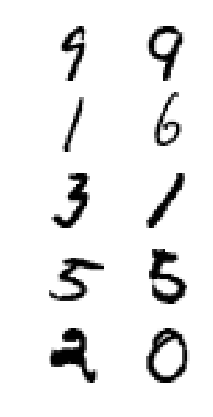

In [65]:
plt.figure(figsize=(3, 3 * batch_size))
plt.subplot(121)
plt.imshow(X_batch[:,0].reshape(28 * batch_size, 28), cmap="binary", interpolation="nearest")
plt.axis('off')
plt.subplot(122)
plt.imshow(X_batch[:,1].reshape(28 * batch_size, 28), cmap="binary", interpolation="nearest")
plt.axis('off')
plt.show()

레이블을 확인해 보겠습니다(0은 "다른 것", 1은 "같은 것"을 의미합니다):

In [66]:
y_batch

array([[1],
       [0],
       [0],
       [1],
       [0]])

완벽하네요!

### 10.3.
_문제: 이 훈련 세트로 DNN을 훈련시키세요. 각각의 이미지 쌍에서 첫 번째 이미지는 DNN A에, 두 번째 이미지는 DNN B에 동시에 주입합니다. 전체 네트워크는 두 이미지가 같은 클래스인지 아닌지 구분하도록 점차 학습될 것입니다._

MNIST 테스트 세트에서 추출한 이미지 쌍으로 테스트 세트를 만듭니다:

In [67]:
X_test1, y_test1 = generate_batch(X_test, y_test, batch_size=len(X_test))

이제 모델을 훈련시킵니다. `batch_size`가 크다는 것외에는 이 단계에 특별한 것은 없습니다. 배치 사이즈가 크지 않으면 모델이 학습을 실패하고 50% 정확도밖에 도달하지 못할 것입니다:

In [68]:
n_epochs = 100
batch_size = 500

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(len(X_train1) // batch_size):
            X_batch, y_batch = generate_batch(X_train1, y_train1, batch_size)
            loss_val, _ = sess.run([loss, training_op], feed_dict={X: X_batch, y: y_batch})
        print(epoch, "훈련 손실:", loss_val)
        if epoch % 5 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test1, y: y_test1})
            print(epoch, "테스트 정확도:", acc_test)

    save_path = saver.save(sess, "./my_digit_comparison_model.ckpt")

0 훈련 손실: 0.6923601
0 테스트 정확도: 0.5031
1 훈련 손실: 0.6937517
2 훈련 손실: 0.6889615
3 훈련 손실: 0.6279487
4 훈련 손실: 0.52220035
5 훈련 손실: 0.53943956
5 테스트 정확도: 0.7317
6 훈련 손실: 0.540305
7 훈련 손실: 0.45393965
8 훈련 손실: 0.4506486
9 훈련 손실: 0.46825838
10 훈련 손실: 0.35033748
10 테스트 정확도: 0.8226
11 훈련 손실: 0.41334054
12 훈련 손실: 0.36943886
13 훈련 손실: 0.3761535
14 훈련 손실: 0.32001546
15 훈련 손실: 0.32761738
15 테스트 정확도: 0.8599
16 훈련 손실: 0.31543648
17 훈련 손실: 0.34082988
18 훈련 손실: 0.28993767
19 훈련 손실: 0.30727518
20 훈련 손실: 0.35425147
20 테스트 정확도: 0.8762
21 훈련 손실: 0.23173122
22 훈련 손실: 0.29069826
23 훈련 손실: 0.24736322
24 훈련 손실: 0.2669435
25 훈련 손실: 0.2391796
25 테스트 정확도: 0.8854
26 훈련 손실: 0.2561812
27 훈련 손실: 0.3061686
28 훈련 손실: 0.2619912
29 훈련 손실: 0.2588208
30 훈련 손실: 0.26606965
30 테스트 정확도: 0.8996
31 훈련 손실: 0.26256466
32 훈련 손실: 0.23858154
33 훈련 손실: 0.21879898
34 훈련 손실: 0.25663126
35 훈련 손실: 0.22745416
35 테스트 정확도: 0.9138
36 훈련 손실: 0.19570524
37 훈련 손실: 0.14133604
38 훈련 손실: 0.15163474
39 훈련 손실: 0.18004769
40 훈련 손실: 0.16298911
40 테스트 정확도: 0

좋습니다. 숫자 비교 작업에서 97.6% 정확도를 달성했습니다. 아주 나쁘지 않네요. 이 모델은 손글씨 숫자를 비교하는 능력을 갖추었습니다!

이 지식을 일반 MNIST 분류 문제에 사용할 수 있는지 확인해 보겠습니다.

### 10.4.
_문제: 이제 DNN A의 은닉층을 동결해서 재사용하고 10개의 뉴런으로 된 소프트맥스 출력 층을 추가한 새로운 DNN을 만듭니다. 이 네트워크를 분할 #2에 대해 훈련시켜보고 클래스당 500개의 이미지만으로도 높은 성능을 얻을 수 있는지 확인해보세요._

모델을 만드는 것은 매우 간단합니다. 하위층을 동결하는 방법이 많이 있습니다. 이 예제에서는 `tf.stop_gradient()` 함수를 사용하겠습니다. 미리 학습된 DNN A를 복원하기 위해 `Saver` 객체가 필요하고 최종 모델을 저장하기 위해 다른 `Saver` 객체가 필요합니다:

In [69]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

dnn_outputs = dnn(X, name="DNN_A")
frozen_outputs = tf.stop_gradient(dnn_outputs)

logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init)
Y_proba = tf.nn.softmax(logits)

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

dnn_A_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="DNN_A")
restore_saver = tf.train.Saver(var_list={var.op.name: var for var in dnn_A_vars})
saver = tf.train.Saver()

이제 훈련입니다! 모든 변수를 초기화하고(새 출력층의 변수를 포함하여), 미리 학습된 DNN A를 복원합니다. 다음에 작은 MNIST 데이터셋(5,000개 이미지)에 이 모델을 훈련시킵니다:

In [70]:
n_epochs = 100
batch_size = 50

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_digit_comparison_model.ckpt")

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 10 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
            print(epoch, "테스트 정확도:", acc_test)

    save_path = saver.save(sess, "./my_mnist_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_digit_comparison_model.ckpt
0 테스트 정확도: 0.9308
10 테스트 정확도: 0.9587
20 테스트 정확도: 0.963
30 테스트 정확도: 0.9629
40 테스트 정확도: 0.9628
50 테스트 정확도: 0.9628
60 테스트 정확도: 0.9628
70 테스트 정확도: 0.9628
80 테스트 정확도: 0.9629
90 테스트 정확도: 0.9629


오 96.7% 정확도네요. 지금까지 훈련시킨 최고의 MNIST 모델은 아니지만 아주 작은 훈련 세트(숫자당 500개 이미지)를 사용한 것을 유념하세요. 전이 학습을 사용하지 않고 그냥 처음부터 학습시킨 DNN과 결과를 비교해 보겠습니다:

In [71]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

dnn_outputs = dnn(X, name="DNN_A")

logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init)
Y_proba = tf.nn.softmax(logits)

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

dnn_A_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="DNN_A")
restore_saver = tf.train.Saver(var_list={var.op.name: var for var in dnn_A_vars})
saver = tf.train.Saver()

In [72]:
n_epochs = 150
batch_size = 50

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 10 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
            print(epoch, "테스트 정확도:", acc_test)

    save_path = saver.save(sess, "./my_mnist_model_final.ckpt")

0 테스트 정확도: 0.8623
10 테스트 정확도: 0.9184
20 테스트 정확도: 0.9378
30 테스트 정확도: 0.9404
40 테스트 정확도: 0.9401
50 테스트 정확도: 0.9402
60 테스트 정확도: 0.9404
70 테스트 정확도: 0.9403
80 테스트 정확도: 0.9402
90 테스트 정확도: 0.9403
100 테스트 정확도: 0.9405
110 테스트 정확도: 0.9402
120 테스트 정확도: 0.9402
130 테스트 정확도: 0.9404
140 테스트 정확도: 0.9404


94.8% 정확도 밖에 안되네요. 전이 학습이 에러율를 5.2%에서 3.3%로 낮추어 주었습니다(36% 이상 에러가 감소했습니다). 더군다나 전이 학습을 사용한 모델은 10번의 에포크만에 96%의 정확도에 도달했습니다.

최종 결과: 전이 학습이 항상 좋은 결과를 내지는 않습니다(연습문제 9에서 보았듯이). 하지만 그렇지 않을 땐 아주 큰 차이를 만들 수 있습니다. 그러므로 꼭 시도해 보세요!